In [ ]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [31]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [2]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [3]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [4]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 172014
Total Plays: 1210147


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 171110


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [7]:
# %%timeit
if 'EPA' not in pbp_data.columns:
    pbp_data["EPA"] = pbp_data.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)

In [8]:
pbp_data.head()

,index,id,offense,defense,home,away,offense_score,defense_score,drive_id,period,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EPA
0,0,322430009008,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Northern Arizona,Arizona State,Northern Arizona,6,0,32243000901,1,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
4,4,322430009005,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408
5,5,322430009004,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,53,46,2,7.0,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,-0.876000,2012,0.048068


In [9]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [13]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'AvgEPA', 'IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EPA.mean()

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_epa = team_off_plays.EPA.mean()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEPA" : [avg_epa]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEPADiff, pbp_data.EPA.min()-pbp_data.EPA.max(), pbp_data.EPA.max()-pbp_data.EPA.min(), 0, 10)
    #return translate(team_stat_pack.IsoPPPDiff, pbp_data.EPA.min(), pbp_data.EPA.max(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 5)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,7) + translate(team_stat_pack.OppSRDiff, -1,1,0,3)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.05 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EPA' not in game_pbp.columns:
        game_pbp['EPA'] = game_pbp.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,1.791667,-0.052381,0.118588,0.994779,-0.66,0.103211,0.124959,-0.040309,4.77238,0.04476
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.103211,-0.124959,0.040309,4.72762,-0.04476


In [14]:
# %%timeit
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/6644] Getting game information for ESPN game_id: 322432006
[1/6644] Started processing game information for ESPN game_id: 322432006
[1/6644] Completed processing game information for ESPN game_id: 322432006
[1/6644] Aggreggating game_id 322432006 to master data copy
[2/6644] Getting game information for ESPN game_id: 322430238
[2/6644] Started processing game information for ESPN game_id: 322430238
[2/6644] Completed processing game information for ESPN game_id: 322430238
[2/6644] Aggreggating game_id 322430238 to master data copy
[3/6644] Getting game information for ESPN game_id: 322432050
[3/6644] Started processing game information for ESPN game_id: 322432050
[3/6644] Completed processing game information for ESPN game_id: 322432050
[3/6644] Aggreggating game_id 322432050 to master data copy
[4/6644] Getting game information for ESPN game_id: 322432117
[4/6644] Started processing game information for ESPN game_id: 322432117
[4/6644] Completed processing game information for ESPN

[32/6644] Completed processing game information for ESPN game_id: 322452005
[32/6644] Aggreggating game_id 322452005 to master data copy
[33/6644] Getting game information for ESPN game_id: 322450120
[33/6644] Started processing game information for ESPN game_id: 322450120
[33/6644] Completed processing game information for ESPN game_id: 322450120
[33/6644] Aggreggating game_id 322450120 to master data copy
[34/6644] Getting game information for ESPN game_id: 322450258
[34/6644] Started processing game information for ESPN game_id: 322450258
[34/6644] Completed processing game information for ESPN game_id: 322450258
[34/6644] Aggreggating game_id 322450258 to master data copy
[35/6644] Getting game information for ESPN game_id: 322450025
[35/6644] Started processing game information for ESPN game_id: 322450025
[35/6644] Completed processing game information for ESPN game_id: 322450025
[35/6644] Aggreggating game_id 322450025 to master data copy
[36/6644] Getting game information for ES

[61/6644] Completed processing game information for ESPN game_id: 322450058
[61/6644] Aggreggating game_id 322450058 to master data copy
[62/6644] Getting game information for ESPN game_id: 322452306
[62/6644] Started processing game information for ESPN game_id: 322452306
[62/6644] Completed processing game information for ESPN game_id: 322452306
[62/6644] Aggreggating game_id 322452306 to master data copy
[63/6644] Getting game information for ESPN game_id: 322450030
[63/6644] Started processing game information for ESPN game_id: 322450030
[63/6644] Completed processing game information for ESPN game_id: 322450030
[63/6644] Aggreggating game_id 322450030 to master data copy
[64/6644] Getting game information for ESPN game_id: 322450084
[64/6644] Started processing game information for ESPN game_id: 322450084
[64/6644] Completed processing game information for ESPN game_id: 322450084
[64/6644] Aggreggating game_id 322450084 to master data copy
[65/6644] Getting game information for ES

[91/6644] Completed processing game information for ESPN game_id: 322522199
[91/6644] Aggreggating game_id 322522199 to master data copy
[92/6644] Getting game information for ESPN game_id: 322520259
[92/6644] Started processing game information for ESPN game_id: 322520259
[92/6644] Completed processing game information for ESPN game_id: 322520259
[92/6644] Aggreggating game_id 322520259 to master data copy
[93/6644] Getting game information for ESPN game_id: 322522636
[93/6644] Started processing game information for ESPN game_id: 322522636
[93/6644] Completed processing game information for ESPN game_id: 322522636
[93/6644] Aggreggating game_id 322522636 to master data copy
[94/6644] Getting game information for ESPN game_id: 322520252
[94/6644] Started processing game information for ESPN game_id: 322520252
[94/6644] Completed processing game information for ESPN game_id: 322520252
[94/6644] Aggreggating game_id 322520252 to master data copy
[95/6644] Getting game information for ES

[122/6644] Completed processing game information for ESPN game_id: 322520195
[122/6644] Aggreggating game_id 322520195 to master data copy
[123/6644] Getting game information for ESPN game_id: 322520008
[123/6644] Started processing game information for ESPN game_id: 322520008
[123/6644] Completed processing game information for ESPN game_id: 322520008
[123/6644] Aggreggating game_id 322520008 to master data copy
[124/6644] Getting game information for ESPN game_id: 322520201
[124/6644] Started processing game information for ESPN game_id: 322520201
[124/6644] Completed processing game information for ESPN game_id: 322520201
[124/6644] Aggreggating game_id 322520201 to master data copy
[125/6644] Getting game information for ESPN game_id: 322520099
[125/6644] Started processing game information for ESPN game_id: 322520099
[125/6644] Completed processing game information for ESPN game_id: 322520099
[125/6644] Aggreggating game_id 322520099 to master data copy
[126/6644] Getting game inf

[152/6644] Completed processing game information for ESPN game_id: 322590194
[152/6644] Aggreggating game_id 322590194 to master data copy
[153/6644] Getting game information for ESPN game_id: 322590221
[153/6644] Started processing game information for ESPN game_id: 322590221
[153/6644] Completed processing game information for ESPN game_id: 322590221
[153/6644] Aggreggating game_id 322590221 to master data copy
[154/6644] Getting game information for ESPN game_id: 322590052
[154/6644] Started processing game information for ESPN game_id: 322590052
[154/6644] Completed processing game information for ESPN game_id: 322590052
[154/6644] Aggreggating game_id 322590052 to master data copy
[155/6644] Getting game information for ESPN game_id: 322592509
[155/6644] Started processing game information for ESPN game_id: 322592509
[155/6644] Completed processing game information for ESPN game_id: 322592509
[155/6644] Aggreggating game_id 322592509 to master data copy
[156/6644] Getting game inf

[182/6644] Completed processing game information for ESPN game_id: 322592633
[182/6644] Aggreggating game_id 322592633 to master data copy
[183/6644] Getting game information for ESPN game_id: 322592751
[183/6644] Started processing game information for ESPN game_id: 322592751
[183/6644] Completed processing game information for ESPN game_id: 322592751
[183/6644] Aggreggating game_id 322592751 to master data copy
[184/6644] Getting game information for ESPN game_id: 322590152
[184/6644] Started processing game information for ESPN game_id: 322590152
[184/6644] Completed processing game information for ESPN game_id: 322590152
[184/6644] Aggreggating game_id 322590152 to master data copy
[185/6644] Getting game information for ESPN game_id: 322592247
[185/6644] Started processing game information for ESPN game_id: 322592247
[185/6644] Completed processing game information for ESPN game_id: 322592247
[185/6644] Aggreggating game_id 322592247 to master data copy
[186/6644] Getting game inf

[213/6644] Completed processing game information for ESPN game_id: 322590254
[213/6644] Aggreggating game_id 322590254 to master data copy
[214/6644] Getting game information for ESPN game_id: 322590026
[214/6644] Started processing game information for ESPN game_id: 322590026
[214/6644] Completed processing game information for ESPN game_id: 322590026
[214/6644] Aggreggating game_id 322590026 to master data copy
[215/6644] Getting game information for ESPN game_id: 322590012
[215/6644] Started processing game information for ESPN game_id: 322590012
[215/6644] Completed processing game information for ESPN game_id: 322590012
[215/6644] Aggreggating game_id 322590012 to master data copy
[216/6644] Getting game information for ESPN game_id: 322590062
[216/6644] Started processing game information for ESPN game_id: 322590062
[216/6644] Completed processing game information for ESPN game_id: 322590062
[216/6644] Aggreggating game_id 322590062 to master data copy
[217/6644] Getting game inf

[244/6644] Completed processing game information for ESPN game_id: 322660077
[244/6644] Aggreggating game_id 322660077 to master data copy
[245/6644] Getting game information for ESPN game_id: 322660265
[245/6644] Started processing game information for ESPN game_id: 322660265
[245/6644] Completed processing game information for ESPN game_id: 322660265
[245/6644] Aggreggating game_id 322660265 to master data copy
[246/6644] Getting game information for ESPN game_id: 322662050
[246/6644] Started processing game information for ESPN game_id: 322662050
[246/6644] Completed processing game information for ESPN game_id: 322662050
[246/6644] Aggreggating game_id 322662050 to master data copy
[247/6644] Getting game information for ESPN game_id: 322660070
[247/6644] Started processing game information for ESPN game_id: 322660070
[247/6644] Completed processing game information for ESPN game_id: 322660070
[247/6644] Aggreggating game_id 322660070 to master data copy
[248/6644] Getting game inf

[274/6644] Completed processing game information for ESPN game_id: 322660009
[274/6644] Aggreggating game_id 322660009 to master data copy
[275/6644] Getting game information for ESPN game_id: 322660062
[275/6644] Started processing game information for ESPN game_id: 322660062
[275/6644] Completed processing game information for ESPN game_id: 322660062
[275/6644] Aggreggating game_id 322660062 to master data copy
[276/6644] Getting game information for ESPN game_id: 322662483
[276/6644] Started processing game information for ESPN game_id: 322662483
[276/6644] Completed processing game information for ESPN game_id: 322662483
[276/6644] Aggreggating game_id 322662483 to master data copy
[277/6644] Getting game information for ESPN game_id: 322710264
[277/6644] Started processing game information for ESPN game_id: 322710264
[277/6644] Completed processing game information for ESPN game_id: 322710264
[277/6644] Aggreggating game_id 322710264 to master data copy
[278/6644] Getting game inf

Could not find drive data for game_id 322732459 on CFB Data API, bailing out
[303/6644] Got 'None' for game_id 322732459's box score, skipping processing
[304/6644] Getting game information for ESPN game_id: 322730113
[304/6644] Started processing game information for ESPN game_id: 322730113
Could not find drive data for game_id 322730113 locally, checking CFB Data API
Could not find drive data for game_id 322730113 on CFB Data API, bailing out
[304/6644] Got 'None' for game_id 322730113's box score, skipping processing
[305/6644] Getting game information for ESPN game_id: 322730242
[305/6644] Started processing game information for ESPN game_id: 322730242
[305/6644] Completed processing game information for ESPN game_id: 322730242
[305/6644] Aggreggating game_id 322730242 to master data copy
[306/6644] Getting game information for ESPN game_id: 322730153
[306/6644] Started processing game information for ESPN game_id: 322730153
[306/6644] Completed processing game information for ESPN

[334/6644] Completed processing game information for ESPN game_id: 322790183
[334/6644] Aggreggating game_id 322790183 to master data copy
[335/6644] Getting game information for ESPN game_id: 322790252
[335/6644] Started processing game information for ESPN game_id: 322790252
[335/6644] Completed processing game information for ESPN game_id: 322790252
[335/6644] Aggreggating game_id 322790252 to master data copy
[336/6644] Getting game information for ESPN game_id: 322802005
[336/6644] Started processing game information for ESPN game_id: 322802005
[336/6644] Completed processing game information for ESPN game_id: 322802005
[336/6644] Aggreggating game_id 322802005 to master data copy
[337/6644] Getting game information for ESPN game_id: 322800195
[337/6644] Started processing game information for ESPN game_id: 322800195
[337/6644] Completed processing game information for ESPN game_id: 322800195
[337/6644] Aggreggating game_id 322800195 to master data copy
[338/6644] Getting game inf

[364/6644] Completed processing game information for ESPN game_id: 322802509
[364/6644] Aggreggating game_id 322802509 to master data copy
[365/6644] Getting game information for ESPN game_id: 322800070
[365/6644] Started processing game information for ESPN game_id: 322800070
[365/6644] Completed processing game information for ESPN game_id: 322800070
[365/6644] Aggreggating game_id 322800070 to master data copy
[366/6644] Getting game information for ESPN game_id: 322800309
[366/6644] Started processing game information for ESPN game_id: 322800309
[366/6644] Completed processing game information for ESPN game_id: 322800309
[366/6644] Aggreggating game_id 322800309 to master data copy
[367/6644] Getting game information for ESPN game_id: 322800167
[367/6644] Started processing game information for ESPN game_id: 322800167
[367/6644] Completed processing game information for ESPN game_id: 322800167
[367/6644] Aggreggating game_id 322800167 to master data copy
[368/6644] Getting game inf

[394/6644] Completed processing game information for ESPN game_id: 322872509
[394/6644] Aggreggating game_id 322872509 to master data copy
[395/6644] Getting game information for ESPN game_id: 322870164
[395/6644] Started processing game information for ESPN game_id: 322870164
[395/6644] Completed processing game information for ESPN game_id: 322870164
[395/6644] Aggreggating game_id 322870164 to master data copy
[396/6644] Getting game information for ESPN game_id: 322870349
[396/6644] Started processing game information for ESPN game_id: 322870349
[396/6644] Completed processing game information for ESPN game_id: 322870349
[396/6644] Aggreggating game_id 322870349 to master data copy
[397/6644] Getting game information for ESPN game_id: 322870127
[397/6644] Started processing game information for ESPN game_id: 322870127
[397/6644] Completed processing game information for ESPN game_id: 322870127
[397/6644] Aggreggating game_id 322870127 to master data copy
[398/6644] Getting game inf

[424/6644] Completed processing game information for ESPN game_id: 322872229
[424/6644] Aggreggating game_id 322872229 to master data copy
[425/6644] Getting game information for ESPN game_id: 322870021
[425/6644] Started processing game information for ESPN game_id: 322870021
[425/6644] Completed processing game information for ESPN game_id: 322870021
[425/6644] Aggreggating game_id 322870021 to master data copy
[426/6644] Getting game information for ESPN game_id: 322872132
[426/6644] Started processing game information for ESPN game_id: 322872132
[426/6644] Completed processing game information for ESPN game_id: 322872132
[426/6644] Aggreggating game_id 322872132 to master data copy
[427/6644] Getting game information for ESPN game_id: 322870264
[427/6644] Started processing game information for ESPN game_id: 322870264
[427/6644] Completed processing game information for ESPN game_id: 322870264
[427/6644] Aggreggating game_id 322870264 to master data copy
[428/6644] Getting game inf

[455/6644] Completed processing game information for ESPN game_id: 322942653
[455/6644] Aggreggating game_id 322942653 to master data copy
[456/6644] Getting game information for ESPN game_id: 322942199
[456/6644] Started processing game information for ESPN game_id: 322942199
[456/6644] Completed processing game information for ESPN game_id: 322942199
[456/6644] Aggreggating game_id 322942199 to master data copy
[457/6644] Getting game information for ESPN game_id: 322942636
[457/6644] Started processing game information for ESPN game_id: 322942636
[457/6644] Completed processing game information for ESPN game_id: 322942636
[457/6644] Aggreggating game_id 322942636 to master data copy
[458/6644] Getting game information for ESPN game_id: 322940059
[458/6644] Started processing game information for ESPN game_id: 322940059
[458/6644] Completed processing game information for ESPN game_id: 322940059
[458/6644] Aggreggating game_id 322940059 to master data copy
[459/6644] Getting game inf

[485/6644] Completed processing game information for ESPN game_id: 322940150
[485/6644] Aggreggating game_id 322940150 to master data copy
[486/6644] Getting game information for ESPN game_id: 322942005
[486/6644] Started processing game information for ESPN game_id: 322942005
[486/6644] Completed processing game information for ESPN game_id: 322942005
[486/6644] Aggreggating game_id 322942005 to master data copy
[487/6644] Getting game information for ESPN game_id: 322942348
[487/6644] Started processing game information for ESPN game_id: 322942348
[487/6644] Completed processing game information for ESPN game_id: 322942348
[487/6644] Aggreggating game_id 322942348 to master data copy
[488/6644] Getting game information for ESPN game_id: 322942294
[488/6644] Started processing game information for ESPN game_id: 322942294
[488/6644] Completed processing game information for ESPN game_id: 322942294
[488/6644] Aggreggating game_id 322942294 to master data copy
[489/6644] Getting game inf

[515/6644] Completed processing game information for ESPN game_id: 323012483
[515/6644] Aggreggating game_id 323012483 to master data copy
[516/6644] Getting game information for ESPN game_id: 323012567
[516/6644] Started processing game information for ESPN game_id: 323012567
[516/6644] Completed processing game information for ESPN game_id: 323012567
[516/6644] Aggreggating game_id 323012567 to master data copy
[517/6644] Getting game information for ESPN game_id: 323010059
[517/6644] Started processing game information for ESPN game_id: 323010059
[517/6644] Completed processing game information for ESPN game_id: 323010059
[517/6644] Aggreggating game_id 323010059 to master data copy
[518/6644] Getting game information for ESPN game_id: 323012306
[518/6644] Started processing game information for ESPN game_id: 323012306
[518/6644] Completed processing game information for ESPN game_id: 323012306
[518/6644] Aggreggating game_id 323012306 to master data copy
[519/6644] Getting game inf

[545/6644] Completed processing game information for ESPN game_id: 323012433
[545/6644] Aggreggating game_id 323012433 to master data copy
[546/6644] Getting game information for ESPN game_id: 323010238
[546/6644] Started processing game information for ESPN game_id: 323010238
[546/6644] Completed processing game information for ESPN game_id: 323010238
[546/6644] Aggreggating game_id 323010238 to master data copy
[547/6644] Getting game information for ESPN game_id: 323010276
[547/6644] Started processing game information for ESPN game_id: 323010276
[547/6644] Completed processing game information for ESPN game_id: 323010276
[547/6644] Aggreggating game_id 323010276 to master data copy
[548/6644] Getting game information for ESPN game_id: 323010166
[548/6644] Started processing game information for ESPN game_id: 323010166
[548/6644] Completed processing game information for ESPN game_id: 323010166
[548/6644] Aggreggating game_id 323010166 to master data copy
[549/6644] Getting game inf

[575/6644] Completed processing game information for ESPN game_id: 323082309
[575/6644] Aggreggating game_id 323082309 to master data copy
[576/6644] Getting game information for ESPN game_id: 323080276
[576/6644] Started processing game information for ESPN game_id: 323080276
[576/6644] Completed processing game information for ESPN game_id: 323080276
[576/6644] Aggreggating game_id 323080276 to master data copy
[577/6644] Getting game information for ESPN game_id: 323080038
[577/6644] Started processing game information for ESPN game_id: 323080038
[577/6644] Completed processing game information for ESPN game_id: 323080038
[577/6644] Aggreggating game_id 323080038 to master data copy
[578/6644] Getting game information for ESPN game_id: 323080277
[578/6644] Started processing game information for ESPN game_id: 323080277
[578/6644] Completed processing game information for ESPN game_id: 323080277
[578/6644] Aggreggating game_id 323080277 to master data copy
[579/6644] Getting game inf

[605/6644] Completed processing game information for ESPN game_id: 323082572
[605/6644] Aggreggating game_id 323082572 to master data copy
[606/6644] Getting game information for ESPN game_id: 323082306
[606/6644] Started processing game information for ESPN game_id: 323082306
[606/6644] Completed processing game information for ESPN game_id: 323082306
[606/6644] Aggreggating game_id 323082306 to master data copy
[607/6644] Getting game information for ESPN game_id: 323080099
[607/6644] Started processing game information for ESPN game_id: 323080099
[607/6644] Completed processing game information for ESPN game_id: 323080099
[607/6644] Aggreggating game_id 323080099 to master data copy
[608/6644] Getting game information for ESPN game_id: 323080068
[608/6644] Started processing game information for ESPN game_id: 323080068
[608/6644] Completed processing game information for ESPN game_id: 323080068
[608/6644] Aggreggating game_id 323080068 to master data copy
[609/6644] Getting game inf

[635/6644] Completed processing game information for ESPN game_id: 323150024
[635/6644] Aggreggating game_id 323150024 to master data copy
[636/6644] Getting game information for ESPN game_id: 323150030
[636/6644] Started processing game information for ESPN game_id: 323150030
[636/6644] Completed processing game information for ESPN game_id: 323150030
[636/6644] Aggreggating game_id 323150030 to master data copy
[637/6644] Getting game information for ESPN game_id: 323150228
[637/6644] Started processing game information for ESPN game_id: 323150228
[637/6644] Completed processing game information for ESPN game_id: 323150228
[637/6644] Aggreggating game_id 323150228 to master data copy
[638/6644] Getting game information for ESPN game_id: 323150333
[638/6644] Started processing game information for ESPN game_id: 323150333
[638/6644] Completed processing game information for ESPN game_id: 323150333
[638/6644] Aggreggating game_id 323150333 to master data copy
[639/6644] Getting game inf

[665/6644] Completed processing game information for ESPN game_id: 323150025
[665/6644] Aggreggating game_id 323150025 to master data copy
[666/6644] Getting game information for ESPN game_id: 323150265
[666/6644] Started processing game information for ESPN game_id: 323150265
[666/6644] Completed processing game information for ESPN game_id: 323150265
[666/6644] Aggreggating game_id 323150265 to master data copy
[667/6644] Getting game information for ESPN game_id: 323152440
[667/6644] Started processing game information for ESPN game_id: 323152440
[667/6644] Completed processing game information for ESPN game_id: 323152440
[667/6644] Aggreggating game_id 323152440 to master data copy
[668/6644] Getting game information for ESPN game_id: 323192050
[668/6644] Started processing game information for ESPN game_id: 323192050
[668/6644] Completed processing game information for ESPN game_id: 323192050
[668/6644] Aggreggating game_id 323192050 to master data copy
[669/6644] Getting game inf

[694/6644] Completed processing game information for ESPN game_id: 323220009
[694/6644] Aggreggating game_id 323220009 to master data copy
[695/6644] Getting game information for ESPN game_id: 323222390
[695/6644] Started processing game information for ESPN game_id: 323222390
[695/6644] Completed processing game information for ESPN game_id: 323222390
[695/6644] Aggreggating game_id 323222390 to master data copy
[696/6644] Getting game information for ESPN game_id: 323220113
[696/6644] Started processing game information for ESPN game_id: 323220113
Could not find drive data for game_id 323220113 locally, checking CFB Data API
Could not find drive data for game_id 323220113 on CFB Data API, bailing out
[696/6644] Got 'None' for game_id 323220113's box score, skipping processing
[697/6644] Getting game information for ESPN game_id: 323220026
[697/6644] Started processing game information for ESPN game_id: 323220026
[697/6644] Completed processing game information for ESPN game_id: 32322

[724/6644] Completed processing game information for ESPN game_id: 323222572
[724/6644] Aggreggating game_id 323222572 to master data copy
[725/6644] Getting game information for ESPN game_id: 323222483
[725/6644] Started processing game information for ESPN game_id: 323222483
[725/6644] Completed processing game information for ESPN game_id: 323222483
[725/6644] Aggreggating game_id 323222483 to master data copy
[726/6644] Getting game information for ESPN game_id: 323220239
[726/6644] Started processing game information for ESPN game_id: 323220239
[726/6644] Completed processing game information for ESPN game_id: 323220239
[726/6644] Aggreggating game_id 323220239 to master data copy
[727/6644] Getting game information for ESPN game_id: 323220254
[727/6644] Started processing game information for ESPN game_id: 323220254
[727/6644] Completed processing game information for ESPN game_id: 323220254
[727/6644] Aggreggating game_id 323220254 to master data copy
[728/6644] Getting game inf

[754/6644] Completed processing game information for ESPN game_id: 323292509
[754/6644] Aggreggating game_id 323292509 to master data copy
[755/6644] Getting game information for ESPN game_id: 323292633
[755/6644] Started processing game information for ESPN game_id: 323292633
[755/6644] Completed processing game information for ESPN game_id: 323292633
[755/6644] Aggreggating game_id 323292633 to master data copy
[756/6644] Getting game information for ESPN game_id: 323290150
[756/6644] Started processing game information for ESPN game_id: 323290150
[756/6644] Completed processing game information for ESPN game_id: 323290150
[756/6644] Aggreggating game_id 323290150 to master data copy
[757/6644] Getting game information for ESPN game_id: 323290098
[757/6644] Started processing game information for ESPN game_id: 323290098
[757/6644] Completed processing game information for ESPN game_id: 323290098
[757/6644] Aggreggating game_id 323290098 to master data copy
[758/6644] Getting game inf

[784/6644] Completed processing game information for ESPN game_id: 323290030
[784/6644] Aggreggating game_id 323290030 to master data copy
[785/6644] Getting game information for ESPN game_id: 323290023
[785/6644] Started processing game information for ESPN game_id: 323290023
[785/6644] Completed processing game information for ESPN game_id: 323290023
[785/6644] Aggreggating game_id 323290023 to master data copy
[786/6644] Getting game information for ESPN game_id: 323290062
[786/6644] Started processing game information for ESPN game_id: 323290062
[786/6644] Completed processing game information for ESPN game_id: 323290062
[786/6644] Aggreggating game_id 323290062 to master data copy
[787/6644] Getting game information for ESPN game_id: 323340164
[787/6644] Started processing game information for ESPN game_id: 323340164
[787/6644] Completed processing game information for ESPN game_id: 323340164
[787/6644] Aggreggating game_id 323340164 to master data copy
[788/6644] Getting game inf

[814/6644] Completed processing game information for ESPN game_id: 332410084
[814/6644] Aggreggating game_id 332410084 to master data copy
[815/6644] Getting game information for ESPN game_id: 332410006
[815/6644] Started processing game information for ESPN game_id: 332410006
[815/6644] Completed processing game information for ESPN game_id: 332410006
[815/6644] Aggreggating game_id 332410006 to master data copy
[816/6644] Getting game information for ESPN game_id: 332412393
[816/6644] Started processing game information for ESPN game_id: 332412393
[816/6644] Completed processing game information for ESPN game_id: 332412393
[816/6644] Aggreggating game_id 332412393 to master data copy
[817/6644] Getting game information for ESPN game_id: 332410041
[817/6644] Started processing game information for ESPN game_id: 332410041
[817/6644] Completed processing game information for ESPN game_id: 332410041
[817/6644] Aggreggating game_id 332410041 to master data copy
[818/6644] Getting game inf

[844/6644] Completed processing game information for ESPN game_id: 332432294
[844/6644] Aggreggating game_id 332432294 to master data copy
[845/6644] Getting game information for ESPN game_id: 332430130
[845/6644] Started processing game information for ESPN game_id: 332430130
[845/6644] Completed processing game information for ESPN game_id: 332430130
[845/6644] Aggreggating game_id 332430130 to master data copy
[846/6644] Getting game information for ESPN game_id: 332430087
[846/6644] Started processing game information for ESPN game_id: 332430087
[846/6644] Completed processing game information for ESPN game_id: 332430087
[846/6644] Aggreggating game_id 332430087 to master data copy
[847/6644] Getting game information for ESPN game_id: 332430197
[847/6644] Started processing game information for ESPN game_id: 332430197
[847/6644] Completed processing game information for ESPN game_id: 332430197
[847/6644] Aggreggating game_id 332430197 to master data copy
[848/6644] Getting game inf

[874/6644] Completed processing game information for ESPN game_id: 332430066
[874/6644] Aggreggating game_id 332430066 to master data copy
[875/6644] Getting game information for ESPN game_id: 332432628
[875/6644] Started processing game information for ESPN game_id: 332432628
[875/6644] Completed processing game information for ESPN game_id: 332432628
[875/6644] Aggreggating game_id 332432628 to master data copy
[876/6644] Getting game information for ESPN game_id: 332430264
[876/6644] Started processing game information for ESPN game_id: 332430264
[876/6644] Completed processing game information for ESPN game_id: 332430264
[876/6644] Aggreggating game_id 332430264 to master data copy
[877/6644] Getting game information for ESPN game_id: 332430026
[877/6644] Started processing game information for ESPN game_id: 332430026
[877/6644] Completed processing game information for ESPN game_id: 332430026
[877/6644] Aggreggating game_id 332430026 to master data copy
[878/6644] Getting game inf

[904/6644] Completed processing game information for ESPN game_id: 332500259
[904/6644] Aggreggating game_id 332500259 to master data copy
[905/6644] Getting game information for ESPN game_id: 332500113
[905/6644] Started processing game information for ESPN game_id: 332500113
[905/6644] Completed processing game information for ESPN game_id: 332500113
[905/6644] Aggreggating game_id 332500113 to master data copy
[906/6644] Getting game information for ESPN game_id: 332502247
[906/6644] Started processing game information for ESPN game_id: 332502247
[906/6644] Completed processing game information for ESPN game_id: 332502247
[906/6644] Aggreggating game_id 332502247 to master data copy
[907/6644] Getting game information for ESPN game_id: 332500254
[907/6644] Started processing game information for ESPN game_id: 332500254
[907/6644] Completed processing game information for ESPN game_id: 332500254
[907/6644] Aggreggating game_id 332500254 to master data copy
[908/6644] Getting game inf

[934/6644] Completed processing game information for ESPN game_id: 332502653
[934/6644] Aggreggating game_id 332502653 to master data copy
[935/6644] Getting game information for ESPN game_id: 332500326
[935/6644] Started processing game information for ESPN game_id: 332500326
[935/6644] Completed processing game information for ESPN game_id: 332500326
[935/6644] Aggreggating game_id 332500326 to master data copy
[936/6644] Getting game information for ESPN game_id: 332500145
[936/6644] Started processing game information for ESPN game_id: 332500145
[936/6644] Completed processing game information for ESPN game_id: 332500145
[936/6644] Aggreggating game_id 332500145 to master data copy
[937/6644] Getting game information for ESPN game_id: 332500195
[937/6644] Started processing game information for ESPN game_id: 332500195
[937/6644] Completed processing game information for ESPN game_id: 332500195
[937/6644] Aggreggating game_id 332500195 to master data copy
[938/6644] Getting game inf

[965/6644] Completed processing game information for ESPN game_id: 332570130
[965/6644] Aggreggating game_id 332570130 to master data copy
[966/6644] Getting game information for ESPN game_id: 332570096
[966/6644] Started processing game information for ESPN game_id: 332570096
[966/6644] Completed processing game information for ESPN game_id: 332570096
[966/6644] Aggreggating game_id 332570096 to master data copy
[967/6644] Getting game information for ESPN game_id: 332570349
[967/6644] Started processing game information for ESPN game_id: 332570349
[967/6644] Completed processing game information for ESPN game_id: 332570349
[967/6644] Aggreggating game_id 332570349 to master data copy
[968/6644] Getting game information for ESPN game_id: 332570151
[968/6644] Started processing game information for ESPN game_id: 332570151
[968/6644] Completed processing game information for ESPN game_id: 332570151
[968/6644] Aggreggating game_id 332570151 to master data copy
[969/6644] Getting game inf

[996/6644] Completed processing game information for ESPN game_id: 332572579
[996/6644] Aggreggating game_id 332572579 to master data copy
[997/6644] Getting game information for ESPN game_id: 332570099
[997/6644] Started processing game information for ESPN game_id: 332570099
[997/6644] Completed processing game information for ESPN game_id: 332570099
[997/6644] Aggreggating game_id 332570099 to master data copy
[998/6644] Getting game information for ESPN game_id: 332570025
[998/6644] Started processing game information for ESPN game_id: 332570025
[998/6644] Completed processing game information for ESPN game_id: 332570025
[998/6644] Aggreggating game_id 332570025 to master data copy
[999/6644] Getting game information for ESPN game_id: 332572306
[999/6644] Started processing game information for ESPN game_id: 332572306
[999/6644] Completed processing game information for ESPN game_id: 332572306
[999/6644] Aggreggating game_id 332572306 to master data copy
[1000/6644] Getting game in

[1026/6644] Completed processing game information for ESPN game_id: 332640135
[1026/6644] Aggreggating game_id 332640135 to master data copy
[1027/6644] Getting game information for ESPN game_id: 332642305
[1027/6644] Started processing game information for ESPN game_id: 332642305
[1027/6644] Completed processing game information for ESPN game_id: 332642305
[1027/6644] Aggreggating game_id 332642305 to master data copy
[1028/6644] Getting game information for ESPN game_id: 332642294
[1028/6644] Started processing game information for ESPN game_id: 332642294
[1028/6644] Completed processing game information for ESPN game_id: 332642294
[1028/6644] Aggreggating game_id 332642294 to master data copy
[1029/6644] Getting game information for ESPN game_id: 332642226
[1029/6644] Started processing game information for ESPN game_id: 332642226
[1029/6644] Completed processing game information for ESPN game_id: 332642226
[1029/6644] Aggreggating game_id 332642226 to master data copy
[1030/6644] G

[1055/6644] Aggreggating game_id 332640295 to master data copy
[1056/6644] Getting game information for ESPN game_id: 332640052
[1056/6644] Started processing game information for ESPN game_id: 332640052
[1056/6644] Completed processing game information for ESPN game_id: 332640052
[1056/6644] Aggreggating game_id 332640052 to master data copy
[1057/6644] Getting game information for ESPN game_id: 332640333
[1057/6644] Started processing game information for ESPN game_id: 332640333
[1057/6644] Completed processing game information for ESPN game_id: 332640333
[1057/6644] Aggreggating game_id 332640333 to master data copy
[1058/6644] Getting game information for ESPN game_id: 332640245
[1058/6644] Started processing game information for ESPN game_id: 332640245
[1058/6644] Completed processing game information for ESPN game_id: 332640245
[1058/6644] Aggreggating game_id 332640245 to master data copy
[1059/6644] Getting game information for ESPN game_id: 332642390
[1059/6644] Started proces

[1085/6644] Completed processing game information for ESPN game_id: 332710356
[1085/6644] Aggreggating game_id 332710356 to master data copy
[1086/6644] Getting game information for ESPN game_id: 332710058
[1086/6644] Started processing game information for ESPN game_id: 332710058
[1086/6644] Completed processing game information for ESPN game_id: 332710058
[1086/6644] Aggreggating game_id 332710058 to master data copy
[1087/6644] Getting game information for ESPN game_id: 332712633
[1087/6644] Started processing game information for ESPN game_id: 332712633
[1087/6644] Completed processing game information for ESPN game_id: 332712633
[1087/6644] Aggreggating game_id 332712633 to master data copy
[1088/6644] Getting game information for ESPN game_id: 332710153
[1088/6644] Started processing game information for ESPN game_id: 332710153
[1088/6644] Completed processing game information for ESPN game_id: 332710153
[1088/6644] Aggreggating game_id 332710153 to master data copy
[1089/6644] G

[1116/6644] Completed processing game information for ESPN game_id: 332710142
[1116/6644] Aggreggating game_id 332710142 to master data copy
[1117/6644] Getting game information for ESPN game_id: 332710194
[1117/6644] Started processing game information for ESPN game_id: 332710194
[1117/6644] Completed processing game information for ESPN game_id: 332710194
[1117/6644] Aggreggating game_id 332710194 to master data copy
[1118/6644] Getting game information for ESPN game_id: 332710166
[1118/6644] Started processing game information for ESPN game_id: 332710166
[1118/6644] Completed processing game information for ESPN game_id: 332710166
[1118/6644] Aggreggating game_id 332710166 to master data copy
[1119/6644] Getting game information for ESPN game_id: 332710167
[1119/6644] Started processing game information for ESPN game_id: 332710167
[1119/6644] Completed processing game information for ESPN game_id: 332710167
[1119/6644] Aggreggating game_id 332710167 to master data copy
[1120/6644] G

[1146/6644] Completed processing game information for ESPN game_id: 332780276
[1146/6644] Aggreggating game_id 332780276 to master data copy
[1147/6644] Getting game information for ESPN game_id: 332782006
[1147/6644] Started processing game information for ESPN game_id: 332782006
[1147/6644] Completed processing game information for ESPN game_id: 332782006
[1147/6644] Aggreggating game_id 332782006 to master data copy
[1148/6644] Getting game information for ESPN game_id: 332780005
[1148/6644] Started processing game information for ESPN game_id: 332780005
[1148/6644] Completed processing game information for ESPN game_id: 332780005
[1148/6644] Aggreggating game_id 332780005 to master data copy
[1149/6644] Getting game information for ESPN game_id: 332782649
[1149/6644] Started processing game information for ESPN game_id: 332782649
[1149/6644] Completed processing game information for ESPN game_id: 332782649
[1149/6644] Aggreggating game_id 332782649 to master data copy
[1150/6644] G

[1176/6644] Completed processing game information for ESPN game_id: 332780238
[1176/6644] Aggreggating game_id 332780238 to master data copy
[1177/6644] Getting game information for ESPN game_id: 332782638
[1177/6644] Started processing game information for ESPN game_id: 332782638
[1177/6644] Completed processing game information for ESPN game_id: 332782638
[1177/6644] Aggreggating game_id 332782638 to master data copy
[1178/6644] Getting game information for ESPN game_id: 332780077
[1178/6644] Started processing game information for ESPN game_id: 332780077
[1178/6644] Completed processing game information for ESPN game_id: 332780077
[1178/6644] Aggreggating game_id 332780077 to master data copy
[1179/6644] Getting game information for ESPN game_id: 332780239
[1179/6644] Started processing game information for ESPN game_id: 332780239
[1179/6644] Completed processing game information for ESPN game_id: 332780239
[1179/6644] Aggreggating game_id 332780239 to master data copy
[1180/6644] G

[1207/6644] Completed processing game information for ESPN game_id: 332852306
[1207/6644] Aggreggating game_id 332852306 to master data copy
[1208/6644] Getting game information for ESPN game_id: 332850120
[1208/6644] Started processing game information for ESPN game_id: 332850120
[1208/6644] Completed processing game information for ESPN game_id: 332850120
[1208/6644] Aggreggating game_id 332850120 to master data copy
[1209/6644] Getting game information for ESPN game_id: 332850152
[1209/6644] Started processing game information for ESPN game_id: 332850152
[1209/6644] Completed processing game information for ESPN game_id: 332850152
[1209/6644] Aggreggating game_id 332850152 to master data copy
[1210/6644] Getting game information for ESPN game_id: 332850036
[1210/6644] Started processing game information for ESPN game_id: 332850036
[1210/6644] Completed processing game information for ESPN game_id: 332850036
[1210/6644] Aggreggating game_id 332850036 to master data copy
[1211/6644] G

[1237/6644] Completed processing game information for ESPN game_id: 332922633
[1237/6644] Aggreggating game_id 332922633 to master data copy
[1238/6644] Getting game information for ESPN game_id: 332920197
[1238/6644] Started processing game information for ESPN game_id: 332920197
[1238/6644] Completed processing game information for ESPN game_id: 332920197
[1238/6644] Aggreggating game_id 332920197 to master data copy
[1239/6644] Getting game information for ESPN game_id: 332922649
[1239/6644] Started processing game information for ESPN game_id: 332922649
[1239/6644] Completed processing game information for ESPN game_id: 332922649
[1239/6644] Aggreggating game_id 332922649 to master data copy
[1240/6644] Getting game information for ESPN game_id: 332922132
[1240/6644] Started processing game information for ESPN game_id: 332922132
[1240/6644] Completed processing game information for ESPN game_id: 332922132
[1240/6644] Aggreggating game_id 332922132 to master data copy
[1241/6644] G

[1267/6644] Completed processing game information for ESPN game_id: 332920239
[1267/6644] Aggreggating game_id 332920239 to master data copy
[1268/6644] Getting game information for ESPN game_id: 332920326
[1268/6644] Started processing game information for ESPN game_id: 332920326
[1268/6644] Completed processing game information for ESPN game_id: 332920326
[1268/6644] Aggreggating game_id 332920326 to master data copy
[1269/6644] Getting game information for ESPN game_id: 332920221
[1269/6644] Started processing game information for ESPN game_id: 332920221
[1269/6644] Completed processing game information for ESPN game_id: 332920221
[1269/6644] Aggreggating game_id 332920221 to master data copy
[1270/6644] Getting game information for ESPN game_id: 332920333
[1270/6644] Started processing game information for ESPN game_id: 332920333
[1270/6644] Completed processing game information for ESPN game_id: 332920333
[1270/6644] Aggreggating game_id 332920333 to master data copy
[1271/6644] G

[1297/6644] Completed processing game information for ESPN game_id: 332992450
[1297/6644] Aggreggating game_id 332992450 to master data copy
[1298/6644] Getting game information for ESPN game_id: 332990195
[1298/6644] Started processing game information for ESPN game_id: 332990195
[1298/6644] Completed processing game information for ESPN game_id: 332990195
[1298/6644] Aggreggating game_id 332990195 to master data copy
[1299/6644] Getting game information for ESPN game_id: 332990189
[1299/6644] Started processing game information for ESPN game_id: 332990189
[1299/6644] Completed processing game information for ESPN game_id: 332990189
[1299/6644] Aggreggating game_id 332990189 to master data copy
[1300/6644] Getting game information for ESPN game_id: 332990113
[1300/6644] Started processing game information for ESPN game_id: 332990113
[1300/6644] Completed processing game information for ESPN game_id: 332990113
[1300/6644] Aggreggating game_id 332990113 to master data copy
[1301/6644] G

[1327/6644] Completed processing game information for ESPN game_id: 332990023
[1327/6644] Aggreggating game_id 332990023 to master data copy
[1328/6644] Getting game information for ESPN game_id: 332990145
[1328/6644] Started processing game information for ESPN game_id: 332990145
[1328/6644] Completed processing game information for ESPN game_id: 332990145
[1328/6644] Aggreggating game_id 332990145 to master data copy
[1329/6644] Getting game information for ESPN game_id: 332990002
[1329/6644] Started processing game information for ESPN game_id: 332990002
[1329/6644] Completed processing game information for ESPN game_id: 332990002
[1329/6644] Aggreggating game_id 332990002 to master data copy
[1330/6644] Getting game information for ESPN game_id: 332992628
[1330/6644] Started processing game information for ESPN game_id: 332992628
[1330/6644] Completed processing game information for ESPN game_id: 332992628
[1330/6644] Aggreggating game_id 332992628 to master data copy
[1331/6644] G

[1357/6644] Completed processing game information for ESPN game_id: 333060295
[1357/6644] Aggreggating game_id 333060295 to master data copy
[1358/6644] Getting game information for ESPN game_id: 333060087
[1358/6644] Started processing game information for ESPN game_id: 333060087
[1358/6644] Completed processing game information for ESPN game_id: 333060087
[1358/6644] Aggreggating game_id 333060087 to master data copy
[1359/6644] Getting game information for ESPN game_id: 333060258
[1359/6644] Started processing game information for ESPN game_id: 333060258
[1359/6644] Completed processing game information for ESPN game_id: 333060258
[1359/6644] Aggreggating game_id 333060258 to master data copy
[1360/6644] Getting game information for ESPN game_id: 333060025
[1360/6644] Started processing game information for ESPN game_id: 333060025
[1360/6644] Completed processing game information for ESPN game_id: 333060025
[1360/6644] Aggreggating game_id 333060025 to master data copy
[1361/6644] G

[1387/6644] Completed processing game information for ESPN game_id: 333060245
[1387/6644] Aggreggating game_id 333060245 to master data copy
[1388/6644] Getting game information for ESPN game_id: 333060278
[1388/6644] Started processing game information for ESPN game_id: 333060278
[1388/6644] Completed processing game information for ESPN game_id: 333060278
[1388/6644] Aggreggating game_id 333060278 to master data copy
[1389/6644] Getting game information for ESPN game_id: 333092084
[1389/6644] Started processing game information for ESPN game_id: 333092084
[1389/6644] Completed processing game information for ESPN game_id: 333092084
[1389/6644] Aggreggating game_id 333092084 to master data copy
[1390/6644] Getting game information for ESPN game_id: 333090193
[1390/6644] Started processing game information for ESPN game_id: 333090193
[1390/6644] Completed processing game information for ESPN game_id: 333090193
[1390/6644] Aggreggating game_id 333090193 to master data copy
[1391/6644] G

[1417/6644] Completed processing game information for ESPN game_id: 333130036
[1417/6644] Aggreggating game_id 333130036 to master data copy
[1418/6644] Getting game information for ESPN game_id: 333130120
[1418/6644] Started processing game information for ESPN game_id: 333130120
[1418/6644] Completed processing game information for ESPN game_id: 333130120
[1418/6644] Aggreggating game_id 333130120 to master data copy
[1419/6644] Getting game information for ESPN game_id: 333130130
[1419/6644] Started processing game information for ESPN game_id: 333130130
[1419/6644] Completed processing game information for ESPN game_id: 333130130
[1419/6644] Aggreggating game_id 333130130 to master data copy
[1420/6644] Getting game information for ESPN game_id: 333130084
[1420/6644] Started processing game information for ESPN game_id: 333130084
[1420/6644] Completed processing game information for ESPN game_id: 333130084
[1420/6644] Aggreggating game_id 333130084 to master data copy
[1421/6644] G

[1447/6644] Completed processing game information for ESPN game_id: 333180202
[1447/6644] Aggreggating game_id 333180202 to master data copy
[1448/6644] Getting game information for ESPN game_id: 333190026
[1448/6644] Started processing game information for ESPN game_id: 333190026
[1448/6644] Completed processing game information for ESPN game_id: 333190026
[1448/6644] Aggreggating game_id 333190026 to master data copy
[1449/6644] Getting game information for ESPN game_id: 333202711
[1449/6644] Started processing game information for ESPN game_id: 333202711
[1449/6644] Completed processing game information for ESPN game_id: 333202711
[1449/6644] Aggreggating game_id 333202711 to master data copy
[1450/6644] Getting game information for ESPN game_id: 333200275
[1450/6644] Started processing game information for ESPN game_id: 333200275
[1450/6644] Completed processing game information for ESPN game_id: 333200275
[1450/6644] Aggreggating game_id 333200275 to master data copy
[1451/6644] G

[1477/6644] Completed processing game information for ESPN game_id: 333200077
[1477/6644] Aggreggating game_id 333200077 to master data copy
[1478/6644] Getting game information for ESPN game_id: 333202483
[1478/6644] Started processing game information for ESPN game_id: 333202483
[1478/6644] Completed processing game information for ESPN game_id: 333202483
[1478/6644] Aggreggating game_id 333202483 to master data copy
[1479/6644] Getting game information for ESPN game_id: 333200038
[1479/6644] Started processing game information for ESPN game_id: 333200038
[1479/6644] Completed processing game information for ESPN game_id: 333200038
[1479/6644] Aggreggating game_id 333200038 to master data copy
[1480/6644] Getting game information for ESPN game_id: 333200058
[1480/6644] Started processing game information for ESPN game_id: 333200058
[1480/6644] Completed processing game information for ESPN game_id: 333200058
[1480/6644] Aggreggating game_id 333200058 to master data copy
[1481/6644] G

[1508/6644] Completed processing game information for ESPN game_id: 333272294
[1508/6644] Aggreggating game_id 333272294 to master data copy
[1509/6644] Getting game information for ESPN game_id: 333272390
[1509/6644] Started processing game information for ESPN game_id: 333272390
[1509/6644] Completed processing game information for ESPN game_id: 333272390
[1509/6644] Aggreggating game_id 333272390 to master data copy
[1510/6644] Getting game information for ESPN game_id: 333270228
[1510/6644] Started processing game information for ESPN game_id: 333270228
[1510/6644] Completed processing game information for ESPN game_id: 333270228
[1510/6644] Aggreggating game_id 333270228 to master data copy
[1511/6644] Getting game information for ESPN game_id: 333270008
[1511/6644] Started processing game information for ESPN game_id: 333270008
[1511/6644] Completed processing game information for ESPN game_id: 333270008
[1511/6644] Aggreggating game_id 333270008 to master data copy
[1512/6644] G

[1538/6644] Completed processing game information for ESPN game_id: 333272229
[1538/6644] Aggreggating game_id 333272229 to master data copy
[1539/6644] Getting game information for ESPN game_id: 333270326
[1539/6644] Started processing game information for ESPN game_id: 333270326
[1539/6644] Completed processing game information for ESPN game_id: 333270326
[1539/6644] Aggreggating game_id 333270326 to master data copy
[1540/6644] Getting game information for ESPN game_id: 333270218
[1540/6644] Started processing game information for ESPN game_id: 333270218
[1540/6644] Completed processing game information for ESPN game_id: 333270218
[1540/6644] Aggreggating game_id 333270218 to master data copy
[1541/6644] Getting game information for ESPN game_id: 333270006
[1541/6644] Started processing game information for ESPN game_id: 333270006
[1541/6644] Completed processing game information for ESPN game_id: 333270006
[1541/6644] Aggreggating game_id 333270006 to master data copy
[1542/6644] G

[1568/6644] Completed processing game information for ESPN game_id: 333330264
[1568/6644] Aggreggating game_id 333330264 to master data copy
[1569/6644] Getting game information for ESPN game_id: 333330023
[1569/6644] Started processing game information for ESPN game_id: 333330023
[1569/6644] Completed processing game information for ESPN game_id: 333330023
[1569/6644] Aggreggating game_id 333330023 to master data copy
[1570/6644] Getting game information for ESPN game_id: 333332483
[1570/6644] Started processing game information for ESPN game_id: 333332483
[1570/6644] Completed processing game information for ESPN game_id: 333332483
[1570/6644] Aggreggating game_id 333332483 to master data copy
[1571/6644] Getting game information for ESPN game_id: 333332116
[1571/6644] Started processing game information for ESPN game_id: 333332116
[1571/6644] Completed processing game information for ESPN game_id: 333332116
[1571/6644] Aggreggating game_id 333332116 to master data copy
[1572/6644] G

[1598/6644] Completed processing game information for ESPN game_id: 333342636
[1598/6644] Aggreggating game_id 333342636 to master data copy
[1599/6644] Getting game information for ESPN game_id: 333342393
[1599/6644] Started processing game information for ESPN game_id: 333342393
[1599/6644] Completed processing game information for ESPN game_id: 333342393
[1599/6644] Aggreggating game_id 333342393 to master data copy
[1600/6644] Getting game information for ESPN game_id: 333340277
[1600/6644] Started processing game information for ESPN game_id: 333340277
[1600/6644] Completed processing game information for ESPN game_id: 333340277
[1600/6644] Aggreggating game_id 333340277 to master data copy
[1601/6644] Getting game information for ESPN game_id: 333340098
[1601/6644] Started processing game information for ESPN game_id: 333340098
[1601/6644] Completed processing game information for ESPN game_id: 333340098
[1601/6644] Aggreggating game_id 333340098 to master data copy
[1602/6644] G

Could not find drive data for game_id 400547834 locally, checking CFB Data API
Could not find drive data for game_id 400547834 bc of issues with 2016 and 2014 data source, bailing out
[1688/6644] Got 'None' for game_id 400547834's box score, skipping processing
[1689/6644] Getting game information for ESPN game_id: 400547837
[1689/6644] Started processing game information for ESPN game_id: 400547837
Could not find drive data for game_id 400547837 locally, checking CFB Data API
Could not find drive data for game_id 400547837 bc of issues with 2016 and 2014 data source, bailing out
[1689/6644] Got 'None' for game_id 400547837's box score, skipping processing
[1690/6644] Getting game information for ESPN game_id: 400547838
[1690/6644] Started processing game information for ESPN game_id: 400547838
Could not find drive data for game_id 400547838 locally, checking CFB Data API
Could not find drive data for game_id 400547838 bc of issues with 2016 and 2014 data source, bailing out
[1690/6644

Could not find drive data for game_id 400548410 locally, checking CFB Data API
Could not find drive data for game_id 400548410 bc of issues with 2016 and 2014 data source, bailing out
[1751/6644] Got 'None' for game_id 400548410's box score, skipping processing
[1752/6644] Getting game information for ESPN game_id: 400547803
[1752/6644] Started processing game information for ESPN game_id: 400547803
Could not find drive data for game_id 400547803 locally, checking CFB Data API
Could not find drive data for game_id 400547803 bc of issues with 2016 and 2014 data source, bailing out
[1752/6644] Got 'None' for game_id 400547803's box score, skipping processing
[1753/6644] Getting game information for ESPN game_id: 400548408
[1753/6644] Started processing game information for ESPN game_id: 400548408
Could not find drive data for game_id 400548408 locally, checking CFB Data API
Could not find drive data for game_id 400548408 bc of issues with 2016 and 2014 data source, bailing out
[1753/6644

Could not find drive data for game_id 400547851 locally, checking CFB Data API
Could not find drive data for game_id 400547851 bc of issues with 2016 and 2014 data source, bailing out
[1812/6644] Got 'None' for game_id 400547851's box score, skipping processing
[1813/6644] Getting game information for ESPN game_id: 400547906
[1813/6644] Started processing game information for ESPN game_id: 400547906
Could not find drive data for game_id 400547906 locally, checking CFB Data API
Could not find drive data for game_id 400547906 bc of issues with 2016 and 2014 data source, bailing out
[1813/6644] Got 'None' for game_id 400547906's box score, skipping processing
[1814/6644] Getting game information for ESPN game_id: 400548390
[1814/6644] Started processing game information for ESPN game_id: 400548390
Could not find drive data for game_id 400548390 locally, checking CFB Data API
Could not find drive data for game_id 400548390 bc of issues with 2016 and 2014 data source, bailing out
[1814/6644

Could not find drive data for game_id 400547667 locally, checking CFB Data API
Could not find drive data for game_id 400547667 bc of issues with 2016 and 2014 data source, bailing out
[1875/6644] Got 'None' for game_id 400547667's box score, skipping processing
[1876/6644] Getting game information for ESPN game_id: 400548268
[1876/6644] Started processing game information for ESPN game_id: 400548268
Could not find drive data for game_id 400548268 locally, checking CFB Data API
Could not find drive data for game_id 400548268 bc of issues with 2016 and 2014 data source, bailing out
[1876/6644] Got 'None' for game_id 400548268's box score, skipping processing
[1877/6644] Getting game information for ESPN game_id: 400547804
[1877/6644] Started processing game information for ESPN game_id: 400547804
Could not find drive data for game_id 400547804 locally, checking CFB Data API
Could not find drive data for game_id 400547804 bc of issues with 2016 and 2014 data source, bailing out
[1877/6644

Could not find drive data for game_id 400548380 locally, checking CFB Data API
Could not find drive data for game_id 400548380 bc of issues with 2016 and 2014 data source, bailing out
[1938/6644] Got 'None' for game_id 400548380's box score, skipping processing
[1939/6644] Getting game information for ESPN game_id: 400547743
[1939/6644] Started processing game information for ESPN game_id: 400547743
Could not find drive data for game_id 400547743 locally, checking CFB Data API
Could not find drive data for game_id 400547743 bc of issues with 2016 and 2014 data source, bailing out
[1939/6644] Got 'None' for game_id 400547743's box score, skipping processing
[1940/6644] Getting game information for ESPN game_id: 400548117
[1940/6644] Started processing game information for ESPN game_id: 400548117
Could not find drive data for game_id 400548117 locally, checking CFB Data API
Could not find drive data for game_id 400548117 bc of issues with 2016 and 2014 data source, bailing out
[1940/6644

Could not find drive data for game_id 400548375 locally, checking CFB Data API
Could not find drive data for game_id 400548375 bc of issues with 2016 and 2014 data source, bailing out
[2001/6644] Got 'None' for game_id 400548375's box score, skipping processing
[2002/6644] Getting game information for ESPN game_id: 400547790
[2002/6644] Started processing game information for ESPN game_id: 400547790
Could not find drive data for game_id 400547790 locally, checking CFB Data API
Could not find drive data for game_id 400547790 bc of issues with 2016 and 2014 data source, bailing out
[2002/6644] Got 'None' for game_id 400547790's box score, skipping processing
[2003/6644] Getting game information for ESPN game_id: 400547812
[2003/6644] Started processing game information for ESPN game_id: 400547812
Could not find drive data for game_id 400547812 locally, checking CFB Data API
Could not find drive data for game_id 400547812 bc of issues with 2016 and 2014 data source, bailing out
[2003/6644

Could not find drive data for game_id 400548213 locally, checking CFB Data API
Could not find drive data for game_id 400548213 bc of issues with 2016 and 2014 data source, bailing out
[2064/6644] Got 'None' for game_id 400548213's box score, skipping processing
[2065/6644] Getting game information for ESPN game_id: 400548427
[2065/6644] Started processing game information for ESPN game_id: 400548427
Could not find drive data for game_id 400548427 locally, checking CFB Data API
Could not find drive data for game_id 400548427 bc of issues with 2016 and 2014 data source, bailing out
[2065/6644] Got 'None' for game_id 400548427's box score, skipping processing
[2066/6644] Getting game information for ESPN game_id: 400547813
[2066/6644] Started processing game information for ESPN game_id: 400547813
Could not find drive data for game_id 400547813 locally, checking CFB Data API
Could not find drive data for game_id 400547813 bc of issues with 2016 and 2014 data source, bailing out
[2066/6644

Could not find drive data for game_id 400547878 locally, checking CFB Data API
Could not find drive data for game_id 400547878 bc of issues with 2016 and 2014 data source, bailing out
[2128/6644] Got 'None' for game_id 400547878's box score, skipping processing
[2129/6644] Getting game information for ESPN game_id: 400547972
[2129/6644] Started processing game information for ESPN game_id: 400547972
Could not find drive data for game_id 400547972 locally, checking CFB Data API
Could not find drive data for game_id 400547972 bc of issues with 2016 and 2014 data source, bailing out
[2129/6644] Got 'None' for game_id 400547972's box score, skipping processing
[2130/6644] Getting game information for ESPN game_id: 400548059
[2130/6644] Started processing game information for ESPN game_id: 400548059
Could not find drive data for game_id 400548059 locally, checking CFB Data API
Could not find drive data for game_id 400548059 bc of issues with 2016 and 2014 data source, bailing out
[2130/6644

Could not find drive data for game_id 400547777 locally, checking CFB Data API
Could not find drive data for game_id 400547777 bc of issues with 2016 and 2014 data source, bailing out
[2191/6644] Got 'None' for game_id 400547777's box score, skipping processing
[2192/6644] Getting game information for ESPN game_id: 400548064
[2192/6644] Started processing game information for ESPN game_id: 400548064
Could not find drive data for game_id 400548064 locally, checking CFB Data API
Could not find drive data for game_id 400548064 bc of issues with 2016 and 2014 data source, bailing out
[2192/6644] Got 'None' for game_id 400548064's box score, skipping processing
[2193/6644] Getting game information for ESPN game_id: 400547923
[2193/6644] Started processing game information for ESPN game_id: 400547923
Could not find drive data for game_id 400547923 locally, checking CFB Data API
Could not find drive data for game_id 400547923 bc of issues with 2016 and 2014 data source, bailing out
[2193/6644

Could not find drive data for game_id 400548305 locally, checking CFB Data API
Could not find drive data for game_id 400548305 bc of issues with 2016 and 2014 data source, bailing out
[2254/6644] Got 'None' for game_id 400548305's box score, skipping processing
[2255/6644] Getting game information for ESPN game_id: 400548236
[2255/6644] Started processing game information for ESPN game_id: 400548236
Could not find drive data for game_id 400548236 locally, checking CFB Data API
Could not find drive data for game_id 400548236 bc of issues with 2016 and 2014 data source, bailing out
[2255/6644] Got 'None' for game_id 400548236's box score, skipping processing
[2256/6644] Getting game information for ESPN game_id: 400547769
[2256/6644] Started processing game information for ESPN game_id: 400547769
Could not find drive data for game_id 400547769 locally, checking CFB Data API
Could not find drive data for game_id 400547769 bc of issues with 2016 and 2014 data source, bailing out
[2256/6644

Could not find drive data for game_id 400548075 locally, checking CFB Data API
Could not find drive data for game_id 400548075 bc of issues with 2016 and 2014 data source, bailing out
[2318/6644] Got 'None' for game_id 400548075's box score, skipping processing
[2319/6644] Getting game information for ESPN game_id: 400548239
[2319/6644] Started processing game information for ESPN game_id: 400548239
Could not find drive data for game_id 400548239 locally, checking CFB Data API
Could not find drive data for game_id 400548239 bc of issues with 2016 and 2014 data source, bailing out
[2319/6644] Got 'None' for game_id 400548239's box score, skipping processing
[2320/6644] Getting game information for ESPN game_id: 400548308
[2320/6644] Started processing game information for ESPN game_id: 400548308
Could not find drive data for game_id 400548308 locally, checking CFB Data API
Could not find drive data for game_id 400548308 bc of issues with 2016 and 2014 data source, bailing out
[2320/6644

Could not find drive data for game_id 400548327 locally, checking CFB Data API
Could not find drive data for game_id 400548327 bc of issues with 2016 and 2014 data source, bailing out
[2381/6644] Got 'None' for game_id 400548327's box score, skipping processing
[2382/6644] Getting game information for ESPN game_id: 400547897
[2382/6644] Started processing game information for ESPN game_id: 400547897
Could not find drive data for game_id 400547897 locally, checking CFB Data API
Could not find drive data for game_id 400547897 bc of issues with 2016 and 2014 data source, bailing out
[2382/6644] Got 'None' for game_id 400547897's box score, skipping processing
[2383/6644] Getting game information for ESPN game_id: 400548167
[2383/6644] Started processing game information for ESPN game_id: 400548167
Could not find drive data for game_id 400548167 locally, checking CFB Data API
Could not find drive data for game_id 400548167 bc of issues with 2016 and 2014 data source, bailing out
[2383/6644

Could not find drive data for game_id 400609077 locally, checking CFB Data API
Could not find drive data for game_id 400609077 bc of issues with 2016 and 2014 data source, bailing out
[2445/6644] Got 'None' for game_id 400609077's box score, skipping processing
[2446/6644] Getting game information for ESPN game_id: 400547725
[2446/6644] Started processing game information for ESPN game_id: 400547725
Could not find drive data for game_id 400547725 locally, checking CFB Data API
Could not find drive data for game_id 400547725 bc of issues with 2016 and 2014 data source, bailing out
[2446/6644] Got 'None' for game_id 400547725's box score, skipping processing
[2447/6644] Getting game information for ESPN game_id: 400547726
[2447/6644] Started processing game information for ESPN game_id: 400547726
Could not find drive data for game_id 400547726 locally, checking CFB Data API
Could not find drive data for game_id 400547726 bc of issues with 2016 and 2014 data source, bailing out
[2447/6644

[2471/6644] Completed processing game information for ESPN game_id: 400787109
[2471/6644] Aggreggating game_id 400787109 to master data copy
[2472/6644] Getting game information for ESPN game_id: 400799923
[2472/6644] Started processing game information for ESPN game_id: 400799923
[2472/6644] Completed processing game information for ESPN game_id: 400799923
[2472/6644] Aggreggating game_id 400799923 to master data copy
[2473/6644] Getting game information for ESPN game_id: 400787107
[2473/6644] Started processing game information for ESPN game_id: 400787107
Could not find drive data for game_id 400787107 locally, checking CFB Data API
Could not find drive data for game_id 400787107 on CFB Data API, bailing out
[2473/6644] Got 'None' for game_id 400787107's box score, skipping processing
[2474/6644] Getting game information for ESPN game_id: 400763587
[2474/6644] Started processing game information for ESPN game_id: 400763587
[2474/6644] Completed processing game information for ESPN ga

[2501/6644] Completed processing game information for ESPN game_id: 400763406
[2501/6644] Aggreggating game_id 400763406 to master data copy
[2502/6644] Getting game information for ESPN game_id: 400763495
[2502/6644] Started processing game information for ESPN game_id: 400763495
[2502/6644] Completed processing game information for ESPN game_id: 400763495
[2502/6644] Aggreggating game_id 400763495 to master data copy
[2503/6644] Getting game information for ESPN game_id: 400763588
[2503/6644] Started processing game information for ESPN game_id: 400763588
[2503/6644] Completed processing game information for ESPN game_id: 400763588
[2503/6644] Aggreggating game_id 400763588 to master data copy
[2504/6644] Getting game information for ESPN game_id: 400763497
[2504/6644] Started processing game information for ESPN game_id: 400763497
[2504/6644] Completed processing game information for ESPN game_id: 400763497
[2504/6644] Aggreggating game_id 400763497 to master data copy
[2505/6644] G

[2531/6644] Completed processing game information for ESPN game_id: 400791346
[2531/6644] Aggreggating game_id 400791346 to master data copy
[2532/6644] Getting game information for ESPN game_id: 400763400
[2532/6644] Started processing game information for ESPN game_id: 400763400
[2532/6644] Completed processing game information for ESPN game_id: 400763400
[2532/6644] Aggreggating game_id 400763400 to master data copy
[2533/6644] Getting game information for ESPN game_id: 400764858
[2533/6644] Started processing game information for ESPN game_id: 400764858
[2533/6644] Completed processing game information for ESPN game_id: 400764858
[2533/6644] Aggreggating game_id 400764858 to master data copy
[2534/6644] Getting game information for ESPN game_id: 400787114
[2534/6644] Started processing game information for ESPN game_id: 400787114
[2534/6644] Completed processing game information for ESPN game_id: 400787114
[2534/6644] Aggreggating game_id 400787114 to master data copy
[2535/6644] G

[2561/6644] Completed processing game information for ESPN game_id: 400787306
[2561/6644] Aggreggating game_id 400787306 to master data copy
[2562/6644] Getting game information for ESPN game_id: 400763415
[2562/6644] Started processing game information for ESPN game_id: 400763415
[2562/6644] Completed processing game information for ESPN game_id: 400763415
[2562/6644] Aggreggating game_id 400763415 to master data copy
[2563/6644] Getting game information for ESPN game_id: 400763416
[2563/6644] Started processing game information for ESPN game_id: 400763416
[2563/6644] Completed processing game information for ESPN game_id: 400763416
[2563/6644] Aggreggating game_id 400763416 to master data copy
[2564/6644] Getting game information for ESPN game_id: 400763412
[2564/6644] Started processing game information for ESPN game_id: 400763412
[2564/6644] Completed processing game information for ESPN game_id: 400763412
[2564/6644] Aggreggating game_id 400763412 to master data copy
[2565/6644] G

[2591/6644] Completed processing game information for ESPN game_id: 400756892
[2591/6644] Aggreggating game_id 400756892 to master data copy
[2592/6644] Getting game information for ESPN game_id: 400787419
[2592/6644] Started processing game information for ESPN game_id: 400787419
[2592/6644] Completed processing game information for ESPN game_id: 400787419
[2592/6644] Aggreggating game_id 400787419 to master data copy
[2593/6644] Getting game information for ESPN game_id: 400763597
[2593/6644] Started processing game information for ESPN game_id: 400763597
[2593/6644] Completed processing game information for ESPN game_id: 400763597
[2593/6644] Aggreggating game_id 400763597 to master data copy
[2594/6644] Getting game information for ESPN game_id: 400763595
[2594/6644] Started processing game information for ESPN game_id: 400763595
[2594/6644] Completed processing game information for ESPN game_id: 400763595
[2594/6644] Aggreggating game_id 400763595 to master data copy
[2595/6644] G

[2621/6644] Completed processing game information for ESPN game_id: 400763510
[2621/6644] Aggreggating game_id 400763510 to master data copy
[2622/6644] Getting game information for ESPN game_id: 400763513
[2622/6644] Started processing game information for ESPN game_id: 400763513
[2622/6644] Completed processing game information for ESPN game_id: 400763513
[2622/6644] Aggreggating game_id 400763513 to master data copy
[2623/6644] Getting game information for ESPN game_id: 400763512
[2623/6644] Started processing game information for ESPN game_id: 400763512
[2623/6644] Completed processing game information for ESPN game_id: 400763512
[2623/6644] Aggreggating game_id 400763512 to master data copy
[2624/6644] Getting game information for ESPN game_id: 400763600
[2624/6644] Started processing game information for ESPN game_id: 400763600
[2624/6644] Completed processing game information for ESPN game_id: 400763600
[2624/6644] Aggreggating game_id 400763600 to master data copy
[2625/6644] G

[2651/6644] Completed processing game information for ESPN game_id: 400763602
[2651/6644] Aggreggating game_id 400763602 to master data copy
[2652/6644] Getting game information for ESPN game_id: 400603859
[2652/6644] Started processing game information for ESPN game_id: 400603859
[2652/6644] Completed processing game information for ESPN game_id: 400603859
[2652/6644] Aggreggating game_id 400603859 to master data copy
[2653/6644] Getting game information for ESPN game_id: 400763509
[2653/6644] Started processing game information for ESPN game_id: 400763509
[2653/6644] Completed processing game information for ESPN game_id: 400763509
[2653/6644] Aggreggating game_id 400763509 to master data copy
[2654/6644] Getting game information for ESPN game_id: 400603855
[2654/6644] Started processing game information for ESPN game_id: 400603855
[2654/6644] Completed processing game information for ESPN game_id: 400603855
[2654/6644] Aggreggating game_id 400603855 to master data copy
[2655/6644] G

[2681/6644] Completed processing game information for ESPN game_id: 400603850
[2681/6644] Aggreggating game_id 400603850 to master data copy
[2682/6644] Getting game information for ESPN game_id: 400757027
[2682/6644] Started processing game information for ESPN game_id: 400757027
[2682/6644] Completed processing game information for ESPN game_id: 400757027
[2682/6644] Aggreggating game_id 400757027 to master data copy
[2683/6644] Getting game information for ESPN game_id: 400757029
[2683/6644] Started processing game information for ESPN game_id: 400757029
[2683/6644] Completed processing game information for ESPN game_id: 400757029
[2683/6644] Aggreggating game_id 400757029 to master data copy
[2684/6644] Getting game information for ESPN game_id: 400757024
[2684/6644] Started processing game information for ESPN game_id: 400757024
[2684/6644] Completed processing game information for ESPN game_id: 400757024
[2684/6644] Aggreggating game_id 400757024 to master data copy
[2685/6644] G

[2712/6644] Completed processing game information for ESPN game_id: 400756937
[2712/6644] Aggreggating game_id 400756937 to master data copy
[2713/6644] Getting game information for ESPN game_id: 400603844
[2713/6644] Started processing game information for ESPN game_id: 400603844
[2713/6644] Completed processing game information for ESPN game_id: 400603844
[2713/6644] Aggreggating game_id 400603844 to master data copy
[2714/6644] Getting game information for ESPN game_id: 400763610
[2714/6644] Started processing game information for ESPN game_id: 400763610
[2714/6644] Completed processing game information for ESPN game_id: 400763610
[2714/6644] Aggreggating game_id 400763610 to master data copy
[2715/6644] Getting game information for ESPN game_id: 400763525
[2715/6644] Started processing game information for ESPN game_id: 400763525
[2715/6644] Completed processing game information for ESPN game_id: 400763525
[2715/6644] Aggreggating game_id 400763525 to master data copy
[2716/6644] G

[2742/6644] Completed processing game information for ESPN game_id: 400787443
[2742/6644] Aggreggating game_id 400787443 to master data copy
[2743/6644] Getting game information for ESPN game_id: 400787244
[2743/6644] Started processing game information for ESPN game_id: 400787244
[2743/6644] Completed processing game information for ESPN game_id: 400787244
[2743/6644] Aggreggating game_id 400787244 to master data copy
[2744/6644] Getting game information for ESPN game_id: 400757037
[2744/6644] Started processing game information for ESPN game_id: 400757037
[2744/6644] Completed processing game information for ESPN game_id: 400757037
[2744/6644] Aggreggating game_id 400757037 to master data copy
[2745/6644] Getting game information for ESPN game_id: 400764873
[2745/6644] Started processing game information for ESPN game_id: 400764873
[2745/6644] Completed processing game information for ESPN game_id: 400764873
[2745/6644] Aggreggating game_id 400764873 to master data copy
[2746/6644] G

[2772/6644] Completed processing game information for ESPN game_id: 400787253
[2772/6644] Aggreggating game_id 400787253 to master data copy
[2773/6644] Getting game information for ESPN game_id: 400763529
[2773/6644] Started processing game information for ESPN game_id: 400763529
[2773/6644] Completed processing game information for ESPN game_id: 400763529
[2773/6644] Aggreggating game_id 400763529 to master data copy
[2774/6644] Getting game information for ESPN game_id: 400763616
[2774/6644] Started processing game information for ESPN game_id: 400763616
[2774/6644] Completed processing game information for ESPN game_id: 400763616
[2774/6644] Aggreggating game_id 400763616 to master data copy
[2775/6644] Getting game information for ESPN game_id: 400764876
[2775/6644] Started processing game information for ESPN game_id: 400764876
[2775/6644] Completed processing game information for ESPN game_id: 400764876
[2775/6644] Aggreggating game_id 400764876 to master data copy
[2776/6644] G

[2802/6644] Completed processing game information for ESPN game_id: 400787250
[2802/6644] Aggreggating game_id 400787250 to master data copy
[2803/6644] Getting game information for ESPN game_id: 400757041
[2803/6644] Started processing game information for ESPN game_id: 400757041
[2803/6644] Completed processing game information for ESPN game_id: 400757041
[2803/6644] Aggreggating game_id 400757041 to master data copy
[2804/6644] Getting game information for ESPN game_id: 400757043
[2804/6644] Started processing game information for ESPN game_id: 400757043
[2804/6644] Completed processing game information for ESPN game_id: 400757043
[2804/6644] Aggreggating game_id 400757043 to master data copy
[2805/6644] Getting game information for ESPN game_id: 400764880
[2805/6644] Started processing game information for ESPN game_id: 400764880
[2805/6644] Completed processing game information for ESPN game_id: 400764880
[2805/6644] Aggreggating game_id 400764880 to master data copy
[2806/6644] G

[2832/6644] Completed processing game information for ESPN game_id: 400603903
[2832/6644] Aggreggating game_id 400603903 to master data copy
[2833/6644] Getting game information for ESPN game_id: 400763435
[2833/6644] Started processing game information for ESPN game_id: 400763435
[2833/6644] Completed processing game information for ESPN game_id: 400763435
[2833/6644] Aggreggating game_id 400763435 to master data copy
[2834/6644] Getting game information for ESPN game_id: 400603904
[2834/6644] Started processing game information for ESPN game_id: 400603904
[2834/6644] Completed processing game information for ESPN game_id: 400603904
[2834/6644] Aggreggating game_id 400603904 to master data copy
[2835/6644] Getting game information for ESPN game_id: 400787448
[2835/6644] Started processing game information for ESPN game_id: 400787448
[2835/6644] Completed processing game information for ESPN game_id: 400787448
[2835/6644] Aggreggating game_id 400787448 to master data copy
[2836/6644] G

[2862/6644] Completed processing game information for ESPN game_id: 400603898
[2862/6644] Aggreggating game_id 400603898 to master data copy
[2863/6644] Getting game information for ESPN game_id: 400763629
[2863/6644] Started processing game information for ESPN game_id: 400763629
[2863/6644] Completed processing game information for ESPN game_id: 400763629
[2863/6644] Aggreggating game_id 400763629 to master data copy
[2864/6644] Getting game information for ESPN game_id: 400757050
[2864/6644] Started processing game information for ESPN game_id: 400757050
[2864/6644] Completed processing game information for ESPN game_id: 400757050
[2864/6644] Aggreggating game_id 400757050 to master data copy
[2865/6644] Getting game information for ESPN game_id: 400764886
[2865/6644] Started processing game information for ESPN game_id: 400764886
[2865/6644] Completed processing game information for ESPN game_id: 400764886
[2865/6644] Aggreggating game_id 400764886 to master data copy
[2866/6644] G

[2892/6644] Completed processing game information for ESPN game_id: 400787260
[2892/6644] Aggreggating game_id 400787260 to master data copy
[2893/6644] Getting game information for ESPN game_id: 400756956
[2893/6644] Started processing game information for ESPN game_id: 400756956
[2893/6644] Completed processing game information for ESPN game_id: 400756956
[2893/6644] Aggreggating game_id 400756956 to master data copy
[2894/6644] Getting game information for ESPN game_id: 400756958
[2894/6644] Started processing game information for ESPN game_id: 400756958
[2894/6644] Completed processing game information for ESPN game_id: 400756958
[2894/6644] Aggreggating game_id 400756958 to master data copy
[2895/6644] Getting game information for ESPN game_id: 400763541
[2895/6644] Started processing game information for ESPN game_id: 400763541
[2895/6644] Completed processing game information for ESPN game_id: 400763541
[2895/6644] Aggreggating game_id 400763541 to master data copy
[2896/6644] G

[2922/6644] Completed processing game information for ESPN game_id: 400764891
[2922/6644] Aggreggating game_id 400764891 to master data copy
[2923/6644] Getting game information for ESPN game_id: 400790884
[2923/6644] Started processing game information for ESPN game_id: 400790884
[2923/6644] Completed processing game information for ESPN game_id: 400790884
[2923/6644] Aggreggating game_id 400790884 to master data copy
[2924/6644] Getting game information for ESPN game_id: 400756960
[2924/6644] Started processing game information for ESPN game_id: 400756960
[2924/6644] Completed processing game information for ESPN game_id: 400756960
[2924/6644] Aggreggating game_id 400756960 to master data copy
[2925/6644] Getting game information for ESPN game_id: 400603887
[2925/6644] Started processing game information for ESPN game_id: 400603887
[2925/6644] Completed processing game information for ESPN game_id: 400603887
[2925/6644] Aggreggating game_id 400603887 to master data copy
[2926/6644] G

[2952/6644] Completed processing game information for ESPN game_id: 400763549
[2952/6644] Aggreggating game_id 400763549 to master data copy
[2953/6644] Getting game information for ESPN game_id: 400787335
[2953/6644] Started processing game information for ESPN game_id: 400787335
[2953/6644] Completed processing game information for ESPN game_id: 400787335
[2953/6644] Aggreggating game_id 400787335 to master data copy
[2954/6644] Getting game information for ESPN game_id: 400603891
[2954/6644] Started processing game information for ESPN game_id: 400603891
[2954/6644] Completed processing game information for ESPN game_id: 400603891
[2954/6644] Aggreggating game_id 400603891 to master data copy
[2955/6644] Getting game information for ESPN game_id: 400757057
[2955/6644] Started processing game information for ESPN game_id: 400757057
[2955/6644] Completed processing game information for ESPN game_id: 400757057
[2955/6644] Aggreggating game_id 400757057 to master data copy
[2956/6644] G

[2983/6644] Completed processing game information for ESPN game_id: 400790885
[2983/6644] Aggreggating game_id 400790885 to master data copy
[2984/6644] Getting game information for ESPN game_id: 400603876
[2984/6644] Started processing game information for ESPN game_id: 400603876
[2984/6644] Completed processing game information for ESPN game_id: 400603876
[2984/6644] Aggreggating game_id 400603876 to master data copy
[2985/6644] Getting game information for ESPN game_id: 400603872
[2985/6644] Started processing game information for ESPN game_id: 400603872
[2985/6644] Completed processing game information for ESPN game_id: 400603872
[2985/6644] Aggreggating game_id 400603872 to master data copy
[2986/6644] Getting game information for ESPN game_id: 400763640
[2986/6644] Started processing game information for ESPN game_id: 400763640
[2986/6644] Completed processing game information for ESPN game_id: 400763640
[2986/6644] Aggreggating game_id 400763640 to master data copy
[2987/6644] G

[3013/6644] Completed processing game information for ESPN game_id: 400763446
[3013/6644] Aggreggating game_id 400763446 to master data copy
[3014/6644] Getting game information for ESPN game_id: 400763639
[3014/6644] Started processing game information for ESPN game_id: 400763639
[3014/6644] Completed processing game information for ESPN game_id: 400763639
[3014/6644] Aggreggating game_id 400763639 to master data copy
[3015/6644] Getting game information for ESPN game_id: 400756970
[3015/6644] Started processing game information for ESPN game_id: 400756970
[3015/6644] Completed processing game information for ESPN game_id: 400756970
[3015/6644] Aggreggating game_id 400756970 to master data copy
[3016/6644] Getting game information for ESPN game_id: 400757065
[3016/6644] Started processing game information for ESPN game_id: 400757065
[3016/6644] Completed processing game information for ESPN game_id: 400757065
[3016/6644] Aggreggating game_id 400757065 to master data copy
[3017/6644] G

[3043/6644] Completed processing game information for ESPN game_id: 400764906
[3043/6644] Aggreggating game_id 400764906 to master data copy
[3044/6644] Getting game information for ESPN game_id: 400763563
[3044/6644] Started processing game information for ESPN game_id: 400763563
[3044/6644] Completed processing game information for ESPN game_id: 400763563
[3044/6644] Aggreggating game_id 400763563 to master data copy
[3045/6644] Getting game information for ESPN game_id: 400763643
[3045/6644] Started processing game information for ESPN game_id: 400763643
[3045/6644] Completed processing game information for ESPN game_id: 400763643
[3045/6644] Aggreggating game_id 400763643 to master data copy
[3046/6644] Getting game information for ESPN game_id: 400763453
[3046/6644] Started processing game information for ESPN game_id: 400763453
[3046/6644] Completed processing game information for ESPN game_id: 400763453
[3046/6644] Aggreggating game_id 400763453 to master data copy
[3047/6644] G

[3073/6644] Completed processing game information for ESPN game_id: 400757069
[3073/6644] Aggreggating game_id 400757069 to master data copy
[3074/6644] Getting game information for ESPN game_id: 400787277
[3074/6644] Started processing game information for ESPN game_id: 400787277
[3074/6644] Completed processing game information for ESPN game_id: 400787277
[3074/6644] Aggreggating game_id 400787277 to master data copy
[3075/6644] Getting game information for ESPN game_id: 400763560
[3075/6644] Started processing game information for ESPN game_id: 400763560
[3075/6644] Completed processing game information for ESPN game_id: 400763560
[3075/6644] Aggreggating game_id 400763560 to master data copy
[3076/6644] Getting game information for ESPN game_id: 400763647
[3076/6644] Started processing game information for ESPN game_id: 400763647
[3076/6644] Completed processing game information for ESPN game_id: 400763647
[3076/6644] Aggreggating game_id 400763647 to master data copy
[3077/6644] G

[3103/6644] Completed processing game information for ESPN game_id: 400763650
[3103/6644] Aggreggating game_id 400763650 to master data copy
[3104/6644] Getting game information for ESPN game_id: 400763652
[3104/6644] Started processing game information for ESPN game_id: 400763652
[3104/6644] Completed processing game information for ESPN game_id: 400763652
[3104/6644] Aggreggating game_id 400763652 to master data copy
[3105/6644] Getting game information for ESPN game_id: 400763456
[3105/6644] Started processing game information for ESPN game_id: 400763456
[3105/6644] Completed processing game information for ESPN game_id: 400763456
[3105/6644] Aggreggating game_id 400763456 to master data copy
[3106/6644] Getting game information for ESPN game_id: 400763568
[3106/6644] Started processing game information for ESPN game_id: 400763568
[3106/6644] Completed processing game information for ESPN game_id: 400763568
[3106/6644] Aggreggating game_id 400763568 to master data copy
[3107/6644] G

[3133/6644] Completed processing game information for ESPN game_id: 400603936
[3133/6644] Aggreggating game_id 400603936 to master data copy
[3134/6644] Getting game information for ESPN game_id: 400603932
[3134/6644] Started processing game information for ESPN game_id: 400603932
[3134/6644] Completed processing game information for ESPN game_id: 400603932
[3134/6644] Aggreggating game_id 400603932 to master data copy
[3135/6644] Getting game information for ESPN game_id: 400757077
[3135/6644] Started processing game information for ESPN game_id: 400757077
[3135/6644] Completed processing game information for ESPN game_id: 400757077
[3135/6644] Aggreggating game_id 400757077 to master data copy
[3136/6644] Getting game information for ESPN game_id: 400785063
[3136/6644] Started processing game information for ESPN game_id: 400785063
[3136/6644] Completed processing game information for ESPN game_id: 400785063
[3136/6644] Aggreggating game_id 400785063 to master data copy
[3137/6644] G

[3163/6644] Completed processing game information for ESPN game_id: 400764915
[3163/6644] Aggreggating game_id 400764915 to master data copy
[3164/6644] Getting game information for ESPN game_id: 400763460
[3164/6644] Started processing game information for ESPN game_id: 400763460
[3164/6644] Completed processing game information for ESPN game_id: 400763460
[3164/6644] Aggreggating game_id 400763460 to master data copy
[3165/6644] Getting game information for ESPN game_id: 400763655
[3165/6644] Started processing game information for ESPN game_id: 400763655
[3165/6644] Completed processing game information for ESPN game_id: 400763655
[3165/6644] Aggreggating game_id 400763655 to master data copy
[3166/6644] Getting game information for ESPN game_id: 400756993
[3166/6644] Started processing game information for ESPN game_id: 400756993
[3166/6644] Completed processing game information for ESPN game_id: 400756993
[3166/6644] Aggreggating game_id 400756993 to master data copy
[3167/6644] G

[3192/6644] Completed processing game information for ESPN game_id: 400763658
[3192/6644] Aggreggating game_id 400763658 to master data copy
[3193/6644] Getting game information for ESPN game_id: 400603925
[3193/6644] Started processing game information for ESPN game_id: 400603925
[3193/6644] Completed processing game information for ESPN game_id: 400603925
[3193/6644] Aggreggating game_id 400603925 to master data copy
[3194/6644] Getting game information for ESPN game_id: 400603922
[3194/6644] Started processing game information for ESPN game_id: 400603922
[3194/6644] Completed processing game information for ESPN game_id: 400603922
[3194/6644] Aggreggating game_id 400603922 to master data copy
[3195/6644] Getting game information for ESPN game_id: 400764916
[3195/6644] Started processing game information for ESPN game_id: 400764916
[3195/6644] Completed processing game information for ESPN game_id: 400764916
[3195/6644] Aggreggating game_id 400764916 to master data copy
[3196/6644] G

[3221/6644] Completed processing game information for ESPN game_id: 400757086
[3221/6644] Aggreggating game_id 400757086 to master data copy
[3222/6644] Getting game information for ESPN game_id: 400757085
[3222/6644] Started processing game information for ESPN game_id: 400757085
[3222/6644] Completed processing game information for ESPN game_id: 400757085
[3222/6644] Aggreggating game_id 400757085 to master data copy
[3223/6644] Getting game information for ESPN game_id: 400787365
[3223/6644] Started processing game information for ESPN game_id: 400787365
[3223/6644] Completed processing game information for ESPN game_id: 400787365
[3223/6644] Aggreggating game_id 400787365 to master data copy
[3224/6644] Getting game information for ESPN game_id: 400763464
[3224/6644] Started processing game information for ESPN game_id: 400763464
[3224/6644] Completed processing game information for ESPN game_id: 400763464
[3224/6644] Aggreggating game_id 400763464 to master data copy
[3225/6644] G

[3251/6644] Completed processing game information for ESPN game_id: 400763580
[3251/6644] Aggreggating game_id 400763580 to master data copy
[3252/6644] Getting game information for ESPN game_id: 400763660
[3252/6644] Started processing game information for ESPN game_id: 400763660
[3252/6644] Completed processing game information for ESPN game_id: 400763660
[3252/6644] Aggreggating game_id 400763660 to master data copy
[3253/6644] Getting game information for ESPN game_id: 400787297
[3253/6644] Started processing game information for ESPN game_id: 400787297
[3253/6644] Completed processing game information for ESPN game_id: 400787297
[3253/6644] Aggreggating game_id 400787297 to master data copy
[3254/6644] Getting game information for ESPN game_id: 400763465
[3254/6644] Started processing game information for ESPN game_id: 400763465
[3254/6644] Completed processing game information for ESPN game_id: 400763465
[3254/6644] Aggreggating game_id 400763465 to master data copy
[3255/6644] G

[3280/6644] Aggreggating game_id 400787482 to master data copy
[3281/6644] Getting game information for ESPN game_id: 400852677
[3281/6644] Started processing game information for ESPN game_id: 400852677
[3281/6644] Completed processing game information for ESPN game_id: 400852677
[3281/6644] Aggreggating game_id 400852677 to master data copy
[3282/6644] Getting game information for ESPN game_id: 400852682
[3282/6644] Started processing game information for ESPN game_id: 400852682
[3282/6644] Completed processing game information for ESPN game_id: 400852682
[3282/6644] Aggreggating game_id 400852682 to master data copy
[3283/6644] Getting game information for ESPN game_id: 400852676
[3283/6644] Started processing game information for ESPN game_id: 400852676
[3283/6644] Completed processing game information for ESPN game_id: 400852676
[3283/6644] Aggreggating game_id 400852676 to master data copy
[3284/6644] Getting game information for ESPN game_id: 400760500
[3284/6644] Started proces

[3310/6644] Completed processing game information for ESPN game_id: 400869265
[3310/6644] Aggreggating game_id 400869265 to master data copy
[3311/6644] Getting game information for ESPN game_id: 400869094
[3311/6644] Started processing game information for ESPN game_id: 400869094
[3311/6644] Completed processing game information for ESPN game_id: 400869094
[3311/6644] Aggreggating game_id 400869094 to master data copy
[3312/6644] Getting game information for ESPN game_id: 400869181
[3312/6644] Started processing game information for ESPN game_id: 400869181
[3312/6644] Completed processing game information for ESPN game_id: 400869181
[3312/6644] Aggreggating game_id 400869181 to master data copy
[3313/6644] Getting game information for ESPN game_id: 400869424
[3313/6644] Started processing game information for ESPN game_id: 400869424
[3313/6644] Completed processing game information for ESPN game_id: 400869424
[3313/6644] Aggreggating game_id 400869424 to master data copy
[3314/6644] G

[3340/6644] Completed processing game information for ESPN game_id: 400869810
[3340/6644] Aggreggating game_id 400869810 to master data copy
[3341/6644] Getting game information for ESPN game_id: 400869808
[3341/6644] Started processing game information for ESPN game_id: 400869808
[3341/6644] Completed processing game information for ESPN game_id: 400869808
[3341/6644] Aggreggating game_id 400869808 to master data copy
[3342/6644] Getting game information for ESPN game_id: 400869343
[3342/6644] Started processing game information for ESPN game_id: 400869343
[3342/6644] Completed processing game information for ESPN game_id: 400869343
[3342/6644] Aggreggating game_id 400869343 to master data copy
[3343/6644] Getting game information for ESPN game_id: 400869425
[3343/6644] Started processing game information for ESPN game_id: 400869425
[3343/6644] Completed processing game information for ESPN game_id: 400869425
[3343/6644] Aggreggating game_id 400869425 to master data copy
[3344/6644] G

[3369/6644] Aggreggating game_id 400869346 to master data copy
[3370/6644] Getting game information for ESPN game_id: 400868946
[3370/6644] Started processing game information for ESPN game_id: 400868946
[3370/6644] Completed processing game information for ESPN game_id: 400868946
[3370/6644] Aggreggating game_id 400868946 to master data copy
[3371/6644] Getting game information for ESPN game_id: 400868979
[3371/6644] Started processing game information for ESPN game_id: 400868979
[3371/6644] Completed processing game information for ESPN game_id: 400868979
[3371/6644] Aggreggating game_id 400868979 to master data copy
[3372/6644] Getting game information for ESPN game_id: 400869351
[3372/6644] Started processing game information for ESPN game_id: 400869351
[3372/6644] Completed processing game information for ESPN game_id: 400869351
[3372/6644] Aggreggating game_id 400869351 to master data copy
[3373/6644] Getting game information for ESPN game_id: 400869429
[3373/6644] Started proces

[3399/6644] Completed processing game information for ESPN game_id: 400868877
[3399/6644] Aggreggating game_id 400868877 to master data copy
[3400/6644] Getting game information for ESPN game_id: 400869276
[3400/6644] Started processing game information for ESPN game_id: 400869276
[3400/6644] Completed processing game information for ESPN game_id: 400869276
[3400/6644] Aggreggating game_id 400869276 to master data copy
[3401/6644] Getting game information for ESPN game_id: 400869512
[3401/6644] Started processing game information for ESPN game_id: 400869512
[3401/6644] Completed processing game information for ESPN game_id: 400869512
[3401/6644] Aggreggating game_id 400869512 to master data copy
[3402/6644] Getting game information for ESPN game_id: 400869655
[3402/6644] Started processing game information for ESPN game_id: 400869655
[3402/6644] Completed processing game information for ESPN game_id: 400869655
[3402/6644] Aggreggating game_id 400869655 to master data copy
[3403/6644] G

[3429/6644] Completed processing game information for ESPN game_id: 400868987
[3429/6644] Aggreggating game_id 400868987 to master data copy
[3430/6644] Getting game information for ESPN game_id: 400868982
[3430/6644] Started processing game information for ESPN game_id: 400868982
[3430/6644] Completed processing game information for ESPN game_id: 400868982
[3430/6644] Aggreggating game_id 400868982 to master data copy
[3431/6644] Getting game information for ESPN game_id: 400868923
[3431/6644] Started processing game information for ESPN game_id: 400868923
[3431/6644] Completed processing game information for ESPN game_id: 400868923
[3431/6644] Aggreggating game_id 400868923 to master data copy
[3432/6644] Getting game information for ESPN game_id: 400868988
[3432/6644] Started processing game information for ESPN game_id: 400868988
[3432/6644] Completed processing game information for ESPN game_id: 400868988
[3432/6644] Aggreggating game_id 400868988 to master data copy
[3433/6644] G

[3459/6644] Completed processing game information for ESPN game_id: 400869720
[3459/6644] Aggreggating game_id 400869720 to master data copy
[3460/6644] Getting game information for ESPN game_id: 400868889
[3460/6644] Started processing game information for ESPN game_id: 400868889
[3460/6644] Completed processing game information for ESPN game_id: 400868889
[3460/6644] Aggreggating game_id 400868889 to master data copy
[3461/6644] Getting game information for ESPN game_id: 400869278
[3461/6644] Started processing game information for ESPN game_id: 400869278
[3461/6644] Completed processing game information for ESPN game_id: 400869278
[3461/6644] Aggreggating game_id 400869278 to master data copy
[3462/6644] Getting game information for ESPN game_id: 400869192
[3462/6644] Started processing game information for ESPN game_id: 400869192
[3462/6644] Completed processing game information for ESPN game_id: 400869192
[3462/6644] Aggreggating game_id 400869192 to master data copy
[3463/6644] G

[3489/6644] Completed processing game information for ESPN game_id: 400869280
[3489/6644] Aggreggating game_id 400869280 to master data copy
[3490/6644] Getting game information for ESPN game_id: 400869360
[3490/6644] Started processing game information for ESPN game_id: 400869360
[3490/6644] Completed processing game information for ESPN game_id: 400869360
[3490/6644] Aggreggating game_id 400869360 to master data copy
[3491/6644] Getting game information for ESPN game_id: 400869445
[3491/6644] Started processing game information for ESPN game_id: 400869445
[3491/6644] Completed processing game information for ESPN game_id: 400869445
[3491/6644] Aggreggating game_id 400869445 to master data copy
[3492/6644] Getting game information for ESPN game_id: 400869814
[3492/6644] Started processing game information for ESPN game_id: 400869814
[3492/6644] Completed processing game information for ESPN game_id: 400869814
[3492/6644] Aggreggating game_id 400869814 to master data copy
[3493/6644] G

[3519/6644] Completed processing game information for ESPN game_id: 400869002
[3519/6644] Aggreggating game_id 400869002 to master data copy
[3520/6644] Getting game information for ESPN game_id: 400869005
[3520/6644] Started processing game information for ESPN game_id: 400869005
[3520/6644] Completed processing game information for ESPN game_id: 400869005
[3520/6644] Aggreggating game_id 400869005 to master data copy
[3521/6644] Getting game information for ESPN game_id: 400869448
[3521/6644] Started processing game information for ESPN game_id: 400869448
[3521/6644] Completed processing game information for ESPN game_id: 400869448
[3521/6644] Aggreggating game_id 400869448 to master data copy
[3522/6644] Getting game information for ESPN game_id: 400869634
[3522/6644] Started processing game information for ESPN game_id: 400869634
[3522/6644] Completed processing game information for ESPN game_id: 400869634
[3522/6644] Aggreggating game_id 400869634 to master data copy
[3523/6644] G

[3549/6644] Completed processing game information for ESPN game_id: 400869286
[3549/6644] Aggreggating game_id 400869286 to master data copy
[3550/6644] Getting game information for ESPN game_id: 400869003
[3550/6644] Started processing game information for ESPN game_id: 400869003
[3550/6644] Completed processing game information for ESPN game_id: 400869003
[3550/6644] Aggreggating game_id 400869003 to master data copy
[3551/6644] Getting game information for ESPN game_id: 400869364
[3551/6644] Started processing game information for ESPN game_id: 400869364
[3551/6644] Completed processing game information for ESPN game_id: 400869364
[3551/6644] Aggreggating game_id 400869364 to master data copy
[3552/6644] Getting game information for ESPN game_id: 400869525
[3552/6644] Started processing game information for ESPN game_id: 400869525
[3552/6644] Completed processing game information for ESPN game_id: 400869525
[3552/6644] Aggreggating game_id 400869525 to master data copy
[3553/6644] G

[3579/6644] Completed processing game information for ESPN game_id: 400869635
[3579/6644] Aggreggating game_id 400869635 to master data copy
[3580/6644] Getting game information for ESPN game_id: 400869528
[3580/6644] Started processing game information for ESPN game_id: 400869528
[3580/6644] Completed processing game information for ESPN game_id: 400869528
[3580/6644] Aggreggating game_id 400869528 to master data copy
[3581/6644] Getting game information for ESPN game_id: 400869530
[3581/6644] Started processing game information for ESPN game_id: 400869530
[3581/6644] Completed processing game information for ESPN game_id: 400869530
[3581/6644] Aggreggating game_id 400869530 to master data copy
[3582/6644] Getting game information for ESPN game_id: 400869818
[3582/6644] Started processing game information for ESPN game_id: 400869818
[3582/6644] Completed processing game information for ESPN game_id: 400869818
[3582/6644] Aggreggating game_id 400869818 to master data copy
[3583/6644] G

[3610/6644] Completed processing game information for ESPN game_id: 400869128
[3610/6644] Aggreggating game_id 400869128 to master data copy
[3611/6644] Getting game information for ESPN game_id: 400869370
[3611/6644] Started processing game information for ESPN game_id: 400869370
Could not find drive data for game_id 400869370 locally, checking CFB Data API
Could not find drive data for game_id 400869370 bc of issues with 2016 and 2014 data source, bailing out
[3611/6644] Got 'None' for game_id 400869370's box score, skipping processing
[3612/6644] Getting game information for ESPN game_id: 400869010
[3612/6644] Started processing game information for ESPN game_id: 400869010
[3612/6644] Completed processing game information for ESPN game_id: 400869010
[3612/6644] Aggreggating game_id 400869010 to master data copy
[3613/6644] Getting game information for ESPN game_id: 400869015
[3613/6644] Started processing game information for ESPN game_id: 400869015
[3613/6644] Completed processing 

[3639/6644] Completed processing game information for ESPN game_id: 400868962
[3639/6644] Aggreggating game_id 400868962 to master data copy
[3640/6644] Getting game information for ESPN game_id: 400869533
[3640/6644] Started processing game information for ESPN game_id: 400869533
[3640/6644] Completed processing game information for ESPN game_id: 400869533
[3640/6644] Aggreggating game_id 400869533 to master data copy
[3641/6644] Getting game information for ESPN game_id: 400869214
[3641/6644] Started processing game information for ESPN game_id: 400869214
[3641/6644] Completed processing game information for ESPN game_id: 400869214
[3641/6644] Aggreggating game_id 400869214 to master data copy
[3642/6644] Getting game information for ESPN game_id: 400869534
[3642/6644] Started processing game information for ESPN game_id: 400869534
[3642/6644] Completed processing game information for ESPN game_id: 400869534
[3642/6644] Aggreggating game_id 400869534 to master data copy
[3643/6644] G

[3669/6644] Completed processing game information for ESPN game_id: 400869217
[3669/6644] Aggreggating game_id 400869217 to master data copy
[3670/6644] Getting game information for ESPN game_id: 400869303
[3670/6644] Started processing game information for ESPN game_id: 400869303
[3670/6644] Completed processing game information for ESPN game_id: 400869303
[3670/6644] Aggreggating game_id 400869303 to master data copy
[3671/6644] Getting game information for ESPN game_id: 400869824
[3671/6644] Started processing game information for ESPN game_id: 400869824
[3671/6644] Completed processing game information for ESPN game_id: 400869824
[3671/6644] Aggreggating game_id 400869824 to master data copy
[3672/6644] Getting game information for ESPN game_id: 400869607
[3672/6644] Started processing game information for ESPN game_id: 400869607
[3672/6644] Completed processing game information for ESPN game_id: 400869607
[3672/6644] Aggreggating game_id 400869607 to master data copy
[3673/6644] G

[3699/6644] Completed processing game information for ESPN game_id: 400868915
[3699/6644] Aggreggating game_id 400868915 to master data copy
[3700/6644] Getting game information for ESPN game_id: 400869026
[3700/6644] Started processing game information for ESPN game_id: 400869026
[3700/6644] Completed processing game information for ESPN game_id: 400869026
[3700/6644] Aggreggating game_id 400869026 to master data copy
[3701/6644] Getting game information for ESPN game_id: 400869671
[3701/6644] Started processing game information for ESPN game_id: 400869671
[3701/6644] Completed processing game information for ESPN game_id: 400869671
[3701/6644] Aggreggating game_id 400869671 to master data copy
[3702/6644] Getting game information for ESPN game_id: 400869465
[3702/6644] Started processing game information for ESPN game_id: 400869465
[3702/6644] Completed processing game information for ESPN game_id: 400869465
[3702/6644] Aggreggating game_id 400869465 to master data copy
[3703/6644] G

[3729/6644] Completed processing game information for ESPN game_id: 400869540
[3729/6644] Aggreggating game_id 400869540 to master data copy
[3730/6644] Getting game information for ESPN game_id: 400869591
[3730/6644] Started processing game information for ESPN game_id: 400869591
[3730/6644] Completed processing game information for ESPN game_id: 400869591
[3730/6644] Aggreggating game_id 400869591 to master data copy
[3731/6644] Getting game information for ESPN game_id: 400869541
[3731/6644] Started processing game information for ESPN game_id: 400869541
[3731/6644] Completed processing game information for ESPN game_id: 400869541
[3731/6644] Aggreggating game_id 400869541 to master data copy
[3732/6644] Getting game information for ESPN game_id: 400869024
[3732/6644] Started processing game information for ESPN game_id: 400869024
[3732/6644] Completed processing game information for ESPN game_id: 400869024
[3732/6644] Aggreggating game_id 400869024 to master data copy
[3733/6644] G

[3758/6644] Completed processing game information for ESPN game_id: 400868964
[3758/6644] Aggreggating game_id 400868964 to master data copy
[3759/6644] Getting game information for ESPN game_id: 400868916
[3759/6644] Started processing game information for ESPN game_id: 400868916
[3759/6644] Completed processing game information for ESPN game_id: 400868916
[3759/6644] Aggreggating game_id 400868916 to master data copy
[3760/6644] Getting game information for ESPN game_id: 400869468
[3760/6644] Started processing game information for ESPN game_id: 400869468
[3760/6644] Completed processing game information for ESPN game_id: 400869468
[3760/6644] Aggreggating game_id 400869468 to master data copy
[3761/6644] Getting game information for ESPN game_id: 400869315
[3761/6644] Started processing game information for ESPN game_id: 400869315
[3761/6644] Completed processing game information for ESPN game_id: 400869315
[3761/6644] Aggreggating game_id 400869315 to master data copy
[3762/6644] G

[3790/6644] Completed processing game information for ESPN game_id: 400869675
[3790/6644] Aggreggating game_id 400869675 to master data copy
[3791/6644] Getting game information for ESPN game_id: 400869031
[3791/6644] Started processing game information for ESPN game_id: 400869031
[3791/6644] Completed processing game information for ESPN game_id: 400869031
[3791/6644] Aggreggating game_id 400869031 to master data copy
[3792/6644] Getting game information for ESPN game_id: 400869832
[3792/6644] Started processing game information for ESPN game_id: 400869832
[3792/6644] Completed processing game information for ESPN game_id: 400869832
[3792/6644] Aggreggating game_id 400869832 to master data copy
[3793/6644] Getting game information for ESPN game_id: 400869645
[3793/6644] Started processing game information for ESPN game_id: 400869645
[3793/6644] Completed processing game information for ESPN game_id: 400869645
[3793/6644] Aggreggating game_id 400869645 to master data copy
[3794/6644] G

[3819/6644] Completed processing game information for ESPN game_id: 400869319
[3819/6644] Aggreggating game_id 400869319 to master data copy
[3820/6644] Getting game information for ESPN game_id: 400869472
[3820/6644] Started processing game information for ESPN game_id: 400869472
[3820/6644] Completed processing game information for ESPN game_id: 400869472
[3820/6644] Aggreggating game_id 400869472 to master data copy
[3821/6644] Getting game information for ESPN game_id: 400869629
[3821/6644] Started processing game information for ESPN game_id: 400869629
[3821/6644] Completed processing game information for ESPN game_id: 400869629
[3821/6644] Aggreggating game_id 400869629 to master data copy
[3822/6644] Getting game information for ESPN game_id: 400869646
[3822/6644] Started processing game information for ESPN game_id: 400869646
[3822/6644] Completed processing game information for ESPN game_id: 400869646
[3822/6644] Aggreggating game_id 400869646 to master data copy
[3823/6644] G

[3849/6644] Completed processing game information for ESPN game_id: 400869396
[3849/6644] Aggreggating game_id 400869396 to master data copy
[3850/6644] Getting game information for ESPN game_id: 400869235
[3850/6644] Started processing game information for ESPN game_id: 400869235
[3850/6644] Completed processing game information for ESPN game_id: 400869235
[3850/6644] Aggreggating game_id 400869235 to master data copy
[3851/6644] Getting game information for ESPN game_id: 400869149
[3851/6644] Started processing game information for ESPN game_id: 400869149
[3851/6644] Completed processing game information for ESPN game_id: 400869149
[3851/6644] Aggreggating game_id 400869149 to master data copy
[3852/6644] Getting game information for ESPN game_id: 400869146
[3852/6644] Started processing game information for ESPN game_id: 400869146
[3852/6644] Completed processing game information for ESPN game_id: 400869146
[3852/6644] Aggreggating game_id 400869146 to master data copy
[3853/6644] G

[3879/6644] Completed processing game information for ESPN game_id: 400869041
[3879/6644] Aggreggating game_id 400869041 to master data copy
[3880/6644] Getting game information for ESPN game_id: 400868882
[3880/6644] Started processing game information for ESPN game_id: 400868882
[3880/6644] Completed processing game information for ESPN game_id: 400868882
[3880/6644] Aggreggating game_id 400868882 to master data copy
[3881/6644] Getting game information for ESPN game_id: 400869610
[3881/6644] Started processing game information for ESPN game_id: 400869610
[3881/6644] Completed processing game information for ESPN game_id: 400869610
[3881/6644] Aggreggating game_id 400869610 to master data copy
[3882/6644] Getting game information for ESPN game_id: 400869478
[3882/6644] Started processing game information for ESPN game_id: 400869478
[3882/6644] Completed processing game information for ESPN game_id: 400869478
[3882/6644] Aggreggating game_id 400869478 to master data copy
[3883/6644] G

[3909/6644] Completed processing game information for ESPN game_id: 400869647
[3909/6644] Aggreggating game_id 400869647 to master data copy
[3910/6644] Getting game information for ESPN game_id: 400869402
[3910/6644] Started processing game information for ESPN game_id: 400869402
[3910/6644] Completed processing game information for ESPN game_id: 400869402
[3910/6644] Aggreggating game_id 400869402 to master data copy
[3911/6644] Getting game information for ESPN game_id: 400869555
[3911/6644] Started processing game information for ESPN game_id: 400869555
[3911/6644] Completed processing game information for ESPN game_id: 400869555
[3911/6644] Aggreggating game_id 400869555 to master data copy
[3912/6644] Getting game information for ESPN game_id: 400869239
[3912/6644] Started processing game information for ESPN game_id: 400869239
[3912/6644] Completed processing game information for ESPN game_id: 400869239
[3912/6644] Aggreggating game_id 400869239 to master data copy
[3913/6644] G

[3939/6644] Completed processing game information for ESPN game_id: 400869845
[3939/6644] Aggreggating game_id 400869845 to master data copy
[3940/6644] Getting game information for ESPN game_id: 400868931
[3940/6644] Started processing game information for ESPN game_id: 400868931
[3940/6644] Completed processing game information for ESPN game_id: 400868931
[3940/6644] Aggreggating game_id 400868931 to master data copy
[3941/6644] Getting game information for ESPN game_id: 400869843
[3941/6644] Started processing game information for ESPN game_id: 400869843
[3941/6644] Completed processing game information for ESPN game_id: 400869843
[3941/6644] Aggreggating game_id 400869843 to master data copy
[3942/6644] Getting game information for ESPN game_id: 400869052
[3942/6644] Started processing game information for ESPN game_id: 400869052
[3942/6644] Completed processing game information for ESPN game_id: 400869052
[3942/6644] Aggreggating game_id 400869052 to master data copy
[3943/6644] G

[3970/6644] Completed processing game information for ESPN game_id: 400869243
[3970/6644] Aggreggating game_id 400869243 to master data copy
[3971/6644] Getting game information for ESPN game_id: 400869241
[3971/6644] Started processing game information for ESPN game_id: 400869241
Could not find drive data for game_id 400869241 locally, checking CFB Data API
Could not find drive data for game_id 400869241 bc of issues with 2016 and 2014 data source, bailing out
[3971/6644] Got 'None' for game_id 400869241's box score, skipping processing
[3972/6644] Getting game information for ESPN game_id: 400869245
[3972/6644] Started processing game information for ESPN game_id: 400869245
[3972/6644] Completed processing game information for ESPN game_id: 400869245
[3972/6644] Aggreggating game_id 400869245 to master data copy
[3973/6644] Getting game information for ESPN game_id: 400869160
[3973/6644] Started processing game information for ESPN game_id: 400869160
[3973/6644] Completed processing 

[3999/6644] Completed processing game information for ESPN game_id: 400869410
[3999/6644] Aggreggating game_id 400869410 to master data copy
[4000/6644] Getting game information for ESPN game_id: 400869848
[4000/6644] Started processing game information for ESPN game_id: 400869848
[4000/6644] Completed processing game information for ESPN game_id: 400869848
[4000/6644] Aggreggating game_id 400869848 to master data copy
[4001/6644] Getting game information for ESPN game_id: 400869492
[4001/6644] Started processing game information for ESPN game_id: 400869492
[4001/6644] Completed processing game information for ESPN game_id: 400869492
[4001/6644] Aggreggating game_id 400869492 to master data copy
[4002/6644] Getting game information for ESPN game_id: 400869595
[4002/6644] Started processing game information for ESPN game_id: 400869595
[4002/6644] Completed processing game information for ESPN game_id: 400869595
[4002/6644] Aggreggating game_id 400869595 to master data copy
[4003/6644] G

[4029/6644] Completed processing game information for ESPN game_id: 400869162
[4029/6644] Aggreggating game_id 400869162 to master data copy
[4030/6644] Getting game information for ESPN game_id: 400869057
[4030/6644] Started processing game information for ESPN game_id: 400869057
[4030/6644] Completed processing game information for ESPN game_id: 400869057
[4030/6644] Aggreggating game_id 400869057 to master data copy
[4031/6644] Getting game information for ESPN game_id: 400869641
[4031/6644] Started processing game information for ESPN game_id: 400869641
[4031/6644] Completed processing game information for ESPN game_id: 400869641
[4031/6644] Aggreggating game_id 400869641 to master data copy
[4032/6644] Getting game information for ESPN game_id: 400869617
[4032/6644] Started processing game information for ESPN game_id: 400869617
[4032/6644] Completed processing game information for ESPN game_id: 400869617
[4032/6644] Aggreggating game_id 400869617 to master data copy
[4033/6644] G

[4059/6644] Completed processing game information for ESPN game_id: 400869650
[4059/6644] Aggreggating game_id 400869650 to master data copy
[4060/6644] Getting game information for ESPN game_id: 400869501
[4060/6644] Started processing game information for ESPN game_id: 400869501
[4060/6644] Completed processing game information for ESPN game_id: 400869501
[4060/6644] Aggreggating game_id 400869501 to master data copy
[4061/6644] Getting game information for ESPN game_id: 400869852
[4061/6644] Started processing game information for ESPN game_id: 400869852
[4061/6644] Completed processing game information for ESPN game_id: 400869852
[4061/6644] Aggreggating game_id 400869852 to master data copy
[4062/6644] Getting game information for ESPN game_id: 400869569
[4062/6644] Started processing game information for ESPN game_id: 400869569
Could not find drive data for game_id 400869569 locally, checking CFB Data API
Could not find drive data for game_id 400869569 bc of issues with 2016 and 

[4089/6644] Completed processing game information for ESPN game_id: 400869169
[4089/6644] Aggreggating game_id 400869169 to master data copy
[4090/6644] Getting game information for ESPN game_id: 400869074
[4090/6644] Started processing game information for ESPN game_id: 400869074
[4090/6644] Completed processing game information for ESPN game_id: 400869074
[4090/6644] Aggreggating game_id 400869074 to master data copy
[4091/6644] Getting game information for ESPN game_id: 400869571
[4091/6644] Started processing game information for ESPN game_id: 400869571
[4091/6644] Completed processing game information for ESPN game_id: 400869571
[4091/6644] Aggreggating game_id 400869571 to master data copy
[4092/6644] Getting game information for ESPN game_id: 400869075
[4092/6644] Started processing game information for ESPN game_id: 400869075
[4092/6644] Completed processing game information for ESPN game_id: 400869075
[4092/6644] Aggreggating game_id 400869075 to master data copy
[4093/6644] G

[4119/6644] Completed processing game information for ESPN game_id: 400938887
[4119/6644] Aggreggating game_id 400938887 to master data copy
[4120/6644] Getting game information for ESPN game_id: 400941786
[4120/6644] Started processing game information for ESPN game_id: 400941786
[4120/6644] Completed processing game information for ESPN game_id: 400941786
[4120/6644] Aggreggating game_id 400941786 to master data copy
[4121/6644] Getting game information for ESPN game_id: 400935257
[4121/6644] Started processing game information for ESPN game_id: 400935257
[4121/6644] Completed processing game information for ESPN game_id: 400935257
[4121/6644] Aggreggating game_id 400935257 to master data copy
[4122/6644] Getting game information for ESPN game_id: 400938591
[4122/6644] Started processing game information for ESPN game_id: 400938591
[4122/6644] Completed processing game information for ESPN game_id: 400938591
[4122/6644] Aggreggating game_id 400938591 to master data copy
[4123/6644] G

[4149/6644] Completed processing game information for ESPN game_id: 400935233
[4149/6644] Aggreggating game_id 400935233 to master data copy
[4150/6644] Getting game information for ESPN game_id: 400935234
[4150/6644] Started processing game information for ESPN game_id: 400935234
[4150/6644] Completed processing game information for ESPN game_id: 400935234
[4150/6644] Aggreggating game_id 400935234 to master data copy
[4151/6644] Getting game information for ESPN game_id: 400933836
[4151/6644] Started processing game information for ESPN game_id: 400933836
[4151/6644] Completed processing game information for ESPN game_id: 400933836
[4151/6644] Aggreggating game_id 400933836 to master data copy
[4152/6644] Getting game information for ESPN game_id: 400935256
[4152/6644] Started processing game information for ESPN game_id: 400935256
[4152/6644] Completed processing game information for ESPN game_id: 400935256
[4152/6644] Aggreggating game_id 400935256 to master data copy
[4153/6644] G

[4178/6644] Completed processing game information for ESPN game_id: 400938595
[4178/6644] Aggreggating game_id 400938595 to master data copy
[4179/6644] Getting game information for ESPN game_id: 400938599
[4179/6644] Started processing game information for ESPN game_id: 400938599
[4179/6644] Completed processing game information for ESPN game_id: 400938599
[4179/6644] Aggreggating game_id 400938599 to master data copy
[4180/6644] Getting game information for ESPN game_id: 400938593
[4180/6644] Started processing game information for ESPN game_id: 400938593
[4180/6644] Completed processing game information for ESPN game_id: 400938593
[4180/6644] Aggreggating game_id 400938593 to master data copy
[4181/6644] Getting game information for ESPN game_id: 400941792
[4181/6644] Started processing game information for ESPN game_id: 400941792
[4181/6644] Completed processing game information for ESPN game_id: 400941792
[4181/6644] Aggreggating game_id 400941792 to master data copy
[4182/6644] G

[4209/6644] Completed processing game information for ESPN game_id: 400938600
[4209/6644] Aggreggating game_id 400938600 to master data copy
[4210/6644] Getting game information for ESPN game_id: 400935239
[4210/6644] Started processing game information for ESPN game_id: 400935239
Could not find drive data for game_id 400935239 locally, checking CFB Data API
Could not find drive data for game_id 400935239 on CFB Data API, bailing out
[4210/6644] Got 'None' for game_id 400935239's box score, skipping processing
[4211/6644] Getting game information for ESPN game_id: 400934503
[4211/6644] Started processing game information for ESPN game_id: 400934503
[4211/6644] Completed processing game information for ESPN game_id: 400934503
[4211/6644] Aggreggating game_id 400934503 to master data copy
[4212/6644] Getting game information for ESPN game_id: 400935242
[4212/6644] Started processing game information for ESPN game_id: 400935242
[4212/6644] Completed processing game information for ESPN ga

[4239/6644] Completed processing game information for ESPN game_id: 400935246
[4239/6644] Aggreggating game_id 400935246 to master data copy
[4240/6644] Getting game information for ESPN game_id: 400935244
[4240/6644] Started processing game information for ESPN game_id: 400935244
[4240/6644] Completed processing game information for ESPN game_id: 400935244
[4240/6644] Aggreggating game_id 400935244 to master data copy
[4241/6644] Getting game information for ESPN game_id: 400934504
[4241/6644] Started processing game information for ESPN game_id: 400934504
[4241/6644] Completed processing game information for ESPN game_id: 400934504
[4241/6644] Aggreggating game_id 400934504 to master data copy
[4242/6644] Getting game information for ESPN game_id: 400945254
[4242/6644] Started processing game information for ESPN game_id: 400945254
[4242/6644] Completed processing game information for ESPN game_id: 400945254
[4242/6644] Aggreggating game_id 400945254 to master data copy
[4243/6644] G

[4269/6644] Completed processing game information for ESPN game_id: 400934498
[4269/6644] Aggreggating game_id 400934498 to master data copy
[4270/6644] Getting game information for ESPN game_id: 400944834
[4270/6644] Started processing game information for ESPN game_id: 400944834
[4270/6644] Completed processing game information for ESPN game_id: 400944834
[4270/6644] Aggreggating game_id 400944834 to master data copy
[4271/6644] Getting game information for ESPN game_id: 400935266
[4271/6644] Started processing game information for ESPN game_id: 400935266
[4271/6644] Completed processing game information for ESPN game_id: 400935266
[4271/6644] Aggreggating game_id 400935266 to master data copy
[4272/6644] Getting game information for ESPN game_id: 400938603
[4272/6644] Started processing game information for ESPN game_id: 400938603
[4272/6644] Completed processing game information for ESPN game_id: 400938603
[4272/6644] Aggreggating game_id 400938603 to master data copy
[4273/6644] G

[4299/6644] Completed processing game information for ESPN game_id: 400937468
[4299/6644] Aggreggating game_id 400937468 to master data copy
[4300/6644] Getting game information for ESPN game_id: 400934510
[4300/6644] Started processing game information for ESPN game_id: 400934510
[4300/6644] Completed processing game information for ESPN game_id: 400934510
[4300/6644] Aggreggating game_id 400934510 to master data copy
[4301/6644] Getting game information for ESPN game_id: 400933856
[4301/6644] Started processing game information for ESPN game_id: 400933856
[4301/6644] Completed processing game information for ESPN game_id: 400933856
[4301/6644] Aggreggating game_id 400933856 to master data copy
[4302/6644] Getting game information for ESPN game_id: 400935349
[4302/6644] Started processing game information for ESPN game_id: 400935349
[4302/6644] Completed processing game information for ESPN game_id: 400935349
[4302/6644] Aggreggating game_id 400935349 to master data copy
[4303/6644] G

[4329/6644] Completed processing game information for ESPN game_id: 400933857
[4329/6644] Aggreggating game_id 400933857 to master data copy
[4330/6644] Getting game information for ESPN game_id: 400933863
[4330/6644] Started processing game information for ESPN game_id: 400933863
[4330/6644] Completed processing game information for ESPN game_id: 400933863
[4330/6644] Aggreggating game_id 400933863 to master data copy
[4331/6644] Getting game information for ESPN game_id: 400935356
[4331/6644] Started processing game information for ESPN game_id: 400935356
[4331/6644] Completed processing game information for ESPN game_id: 400935356
[4331/6644] Aggreggating game_id 400935356 to master data copy
[4332/6644] Getting game information for ESPN game_id: 400933861
[4332/6644] Started processing game information for ESPN game_id: 400933861
[4332/6644] Completed processing game information for ESPN game_id: 400933861
[4332/6644] Aggreggating game_id 400933861 to master data copy
[4333/6644] G

[4359/6644] Completed processing game information for ESPN game_id: 400944902
[4359/6644] Aggreggating game_id 400944902 to master data copy
[4360/6644] Getting game information for ESPN game_id: 400935361
[4360/6644] Started processing game information for ESPN game_id: 400935361
[4360/6644] Completed processing game information for ESPN game_id: 400935361
[4360/6644] Aggreggating game_id 400935361 to master data copy
[4361/6644] Getting game information for ESPN game_id: 400937471
[4361/6644] Started processing game information for ESPN game_id: 400937471
[4361/6644] Completed processing game information for ESPN game_id: 400937471
[4361/6644] Aggreggating game_id 400937471 to master data copy
[4362/6644] Getting game information for ESPN game_id: 400933869
[4362/6644] Started processing game information for ESPN game_id: 400933869
[4362/6644] Completed processing game information for ESPN game_id: 400933869
[4362/6644] Aggreggating game_id 400933869 to master data copy
[4363/6644] G

[4390/6644] Completed processing game information for ESPN game_id: 400935360
[4390/6644] Aggreggating game_id 400935360 to master data copy
[4391/6644] Getting game information for ESPN game_id: 400938615
[4391/6644] Started processing game information for ESPN game_id: 400938615
[4391/6644] Completed processing game information for ESPN game_id: 400938615
[4391/6644] Aggreggating game_id 400938615 to master data copy
[4392/6644] Getting game information for ESPN game_id: 400945260
[4392/6644] Started processing game information for ESPN game_id: 400945260
[4392/6644] Completed processing game information for ESPN game_id: 400945260
[4392/6644] Aggreggating game_id 400945260 to master data copy
[4393/6644] Getting game information for ESPN game_id: 400938620
[4393/6644] Started processing game information for ESPN game_id: 400938620
[4393/6644] Completed processing game information for ESPN game_id: 400938620
[4393/6644] Aggreggating game_id 400938620 to master data copy
[4394/6644] G

[4420/6644] Completed processing game information for ESPN game_id: 400935368
[4420/6644] Aggreggating game_id 400935368 to master data copy
[4421/6644] Getting game information for ESPN game_id: 400933878
[4421/6644] Started processing game information for ESPN game_id: 400933878
[4421/6644] Completed processing game information for ESPN game_id: 400933878
[4421/6644] Aggreggating game_id 400933878 to master data copy
[4422/6644] Getting game information for ESPN game_id: 400944986
[4422/6644] Started processing game information for ESPN game_id: 400944986
[4422/6644] Completed processing game information for ESPN game_id: 400944986
[4422/6644] Aggreggating game_id 400944986 to master data copy
[4423/6644] Getting game information for ESPN game_id: 400941813
[4423/6644] Started processing game information for ESPN game_id: 400941813
[4423/6644] Completed processing game information for ESPN game_id: 400941813
[4423/6644] Aggreggating game_id 400941813 to master data copy
[4424/6644] G

[4450/6644] Completed processing game information for ESPN game_id: 400933872
[4450/6644] Aggreggating game_id 400933872 to master data copy
[4451/6644] Getting game information for ESPN game_id: 400945265
[4451/6644] Started processing game information for ESPN game_id: 400945265
[4451/6644] Completed processing game information for ESPN game_id: 400945265
[4451/6644] Aggreggating game_id 400945265 to master data copy
[4452/6644] Getting game information for ESPN game_id: 400945266
[4452/6644] Started processing game information for ESPN game_id: 400945266
[4452/6644] Completed processing game information for ESPN game_id: 400945266
[4452/6644] Aggreggating game_id 400945266 to master data copy
[4453/6644] Getting game information for ESPN game_id: 400935286
[4453/6644] Started processing game information for ESPN game_id: 400935286
[4453/6644] Completed processing game information for ESPN game_id: 400935286
[4453/6644] Aggreggating game_id 400935286 to master data copy
[4454/6644] G

[4481/6644] Completed processing game information for ESPN game_id: 400933882
[4481/6644] Aggreggating game_id 400933882 to master data copy
[4482/6644] Getting game information for ESPN game_id: 400935376
[4482/6644] Started processing game information for ESPN game_id: 400935376
[4482/6644] Completed processing game information for ESPN game_id: 400935376
[4482/6644] Aggreggating game_id 400935376 to master data copy
[4483/6644] Getting game information for ESPN game_id: 400944850
[4483/6644] Started processing game information for ESPN game_id: 400944850
[4483/6644] Completed processing game information for ESPN game_id: 400944850
[4483/6644] Aggreggating game_id 400944850 to master data copy
[4484/6644] Getting game information for ESPN game_id: 400944988
[4484/6644] Started processing game information for ESPN game_id: 400944988
[4484/6644] Completed processing game information for ESPN game_id: 400944988
[4484/6644] Aggreggating game_id 400944988 to master data copy
[4485/6644] G

[4512/6644] Completed processing game information for ESPN game_id: 400945270
[4512/6644] Aggreggating game_id 400945270 to master data copy
[4513/6644] Getting game information for ESPN game_id: 400935293
[4513/6644] Started processing game information for ESPN game_id: 400935293
[4513/6644] Completed processing game information for ESPN game_id: 400935293
[4513/6644] Aggreggating game_id 400935293 to master data copy
[4514/6644] Getting game information for ESPN game_id: 400945271
[4514/6644] Started processing game information for ESPN game_id: 400945271
[4514/6644] Completed processing game information for ESPN game_id: 400945271
[4514/6644] Aggreggating game_id 400945271 to master data copy
[4515/6644] Getting game information for ESPN game_id: 400944851
[4515/6644] Started processing game information for ESPN game_id: 400944851
[4515/6644] Completed processing game information for ESPN game_id: 400944851
[4515/6644] Aggreggating game_id 400944851 to master data copy
[4516/6644] G

[4542/6644] Completed processing game information for ESPN game_id: 400944998
[4542/6644] Aggreggating game_id 400944998 to master data copy
[4543/6644] Getting game information for ESPN game_id: 400944996
[4543/6644] Started processing game information for ESPN game_id: 400944996
[4543/6644] Completed processing game information for ESPN game_id: 400944996
[4543/6644] Aggreggating game_id 400944996 to master data copy
[4544/6644] Getting game information for ESPN game_id: 400944995
[4544/6644] Started processing game information for ESPN game_id: 400944995
[4544/6644] Completed processing game information for ESPN game_id: 400944995
[4544/6644] Aggreggating game_id 400944995 to master data copy
[4545/6644] Getting game information for ESPN game_id: 400941823
[4545/6644] Started processing game information for ESPN game_id: 400941823
[4545/6644] Completed processing game information for ESPN game_id: 400941823
[4545/6644] Aggreggating game_id 400941823 to master data copy
[4546/6644] G

[4572/6644] Completed processing game information for ESPN game_id: 400945277
[4572/6644] Aggreggating game_id 400945277 to master data copy
[4573/6644] Getting game information for ESPN game_id: 400944994
[4573/6644] Started processing game information for ESPN game_id: 400944994
[4573/6644] Completed processing game information for ESPN game_id: 400944994
[4573/6644] Aggreggating game_id 400944994 to master data copy
[4574/6644] Getting game information for ESPN game_id: 400944857
[4574/6644] Started processing game information for ESPN game_id: 400944857
[4574/6644] Completed processing game information for ESPN game_id: 400944857
[4574/6644] Aggreggating game_id 400944857 to master data copy
[4575/6644] Getting game information for ESPN game_id: 400941824
[4575/6644] Started processing game information for ESPN game_id: 400941824
[4575/6644] Completed processing game information for ESPN game_id: 400941824
[4575/6644] Aggreggating game_id 400941824 to master data copy
[4576/6644] G

[4602/6644] Completed processing game information for ESPN game_id: 400941825
[4602/6644] Aggreggating game_id 400941825 to master data copy
[4603/6644] Getting game information for ESPN game_id: 400938892
[4603/6644] Started processing game information for ESPN game_id: 400938892
[4603/6644] Completed processing game information for ESPN game_id: 400938892
[4603/6644] Aggreggating game_id 400938892 to master data copy
[4604/6644] Getting game information for ESPN game_id: 400935301
[4604/6644] Started processing game information for ESPN game_id: 400935301
[4604/6644] Completed processing game information for ESPN game_id: 400935301
[4604/6644] Aggreggating game_id 400935301 to master data copy
[4605/6644] Getting game information for ESPN game_id: 400935384
[4605/6644] Started processing game information for ESPN game_id: 400935384
[4605/6644] Completed processing game information for ESPN game_id: 400935384
[4605/6644] Aggreggating game_id 400935384 to master data copy
[4606/6644] G

[4632/6644] Completed processing game information for ESPN game_id: 400944861
[4632/6644] Aggreggating game_id 400944861 to master data copy
[4633/6644] Getting game information for ESPN game_id: 400935304
[4633/6644] Started processing game information for ESPN game_id: 400935304
[4633/6644] Completed processing game information for ESPN game_id: 400935304
[4633/6644] Aggreggating game_id 400935304 to master data copy
[4634/6644] Getting game information for ESPN game_id: 400937504
[4634/6644] Started processing game information for ESPN game_id: 400937504
[4634/6644] Completed processing game information for ESPN game_id: 400937504
[4634/6644] Aggreggating game_id 400937504 to master data copy
[4635/6644] Getting game information for ESPN game_id: 400941830
[4635/6644] Started processing game information for ESPN game_id: 400941830
[4635/6644] Completed processing game information for ESPN game_id: 400941830
[4635/6644] Aggreggating game_id 400941830 to master data copy
[4636/6644] G

[4662/6644] Completed processing game information for ESPN game_id: 400933902
[4662/6644] Aggreggating game_id 400933902 to master data copy
[4663/6644] Getting game information for ESPN game_id: 400938644
[4663/6644] Started processing game information for ESPN game_id: 400938644
[4663/6644] Completed processing game information for ESPN game_id: 400938644
[4663/6644] Aggreggating game_id 400938644 to master data copy
[4664/6644] Getting game information for ESPN game_id: 400986609
[4664/6644] Started processing game information for ESPN game_id: 400986609
[4664/6644] Completed processing game information for ESPN game_id: 400986609
[4664/6644] Aggreggating game_id 400986609 to master data copy
[4665/6644] Getting game information for ESPN game_id: 400944865
[4665/6644] Started processing game information for ESPN game_id: 400944865
[4665/6644] Completed processing game information for ESPN game_id: 400944865
[4665/6644] Aggreggating game_id 400944865 to master data copy
[4666/6644] G

[4693/6644] Completed processing game information for ESPN game_id: 400938675
[4693/6644] Aggreggating game_id 400938675 to master data copy
[4694/6644] Getting game information for ESPN game_id: 400941835
[4694/6644] Started processing game information for ESPN game_id: 400941835
[4694/6644] Completed processing game information for ESPN game_id: 400941835
[4694/6644] Aggreggating game_id 400941835 to master data copy
[4695/6644] Getting game information for ESPN game_id: 400935310
[4695/6644] Started processing game information for ESPN game_id: 400935310
[4695/6644] Completed processing game information for ESPN game_id: 400935310
[4695/6644] Aggreggating game_id 400935310 to master data copy
[4696/6644] Getting game information for ESPN game_id: 400933911
[4696/6644] Started processing game information for ESPN game_id: 400933911
[4696/6644] Completed processing game information for ESPN game_id: 400933911
[4696/6644] Aggreggating game_id 400933911 to master data copy
[4697/6644] G

[4724/6644] Completed processing game information for ESPN game_id: 400944869
[4724/6644] Aggreggating game_id 400944869 to master data copy
[4725/6644] Getting game information for ESPN game_id: 400934544
[4725/6644] Started processing game information for ESPN game_id: 400934544
[4725/6644] Completed processing game information for ESPN game_id: 400934544
[4725/6644] Aggreggating game_id 400934544 to master data copy
[4726/6644] Getting game information for ESPN game_id: 400933907
[4726/6644] Started processing game information for ESPN game_id: 400933907
[4726/6644] Completed processing game information for ESPN game_id: 400933907
[4726/6644] Aggreggating game_id 400933907 to master data copy
[4727/6644] Getting game information for ESPN game_id: 400933905
[4727/6644] Started processing game information for ESPN game_id: 400933905
[4727/6644] Completed processing game information for ESPN game_id: 400933905
[4727/6644] Aggreggating game_id 400933905 to master data copy
[4728/6644] G

[4754/6644] Completed processing game information for ESPN game_id: 400944871
[4754/6644] Aggreggating game_id 400944871 to master data copy
[4755/6644] Getting game information for ESPN game_id: 400941840
[4755/6644] Started processing game information for ESPN game_id: 400941840
[4755/6644] Completed processing game information for ESPN game_id: 400941840
[4755/6644] Aggreggating game_id 400941840 to master data copy
[4756/6644] Getting game information for ESPN game_id: 400945299
[4756/6644] Started processing game information for ESPN game_id: 400945299
[4756/6644] Completed processing game information for ESPN game_id: 400945299
[4756/6644] Aggreggating game_id 400945299 to master data copy
[4757/6644] Getting game information for ESPN game_id: 400935316
[4757/6644] Started processing game information for ESPN game_id: 400935316
[4757/6644] Completed processing game information for ESPN game_id: 400935316
[4757/6644] Aggreggating game_id 400935316 to master data copy
[4758/6644] G

[4784/6644] Completed processing game information for ESPN game_id: 400938894
[4784/6644] Aggreggating game_id 400938894 to master data copy
[4785/6644] Getting game information for ESPN game_id: 400945298
[4785/6644] Started processing game information for ESPN game_id: 400945298
[4785/6644] Completed processing game information for ESPN game_id: 400945298
[4785/6644] Aggreggating game_id 400945298 to master data copy
[4786/6644] Getting game information for ESPN game_id: 400933920
[4786/6644] Started processing game information for ESPN game_id: 400933920
[4786/6644] Completed processing game information for ESPN game_id: 400933920
[4786/6644] Aggreggating game_id 400933920 to master data copy
[4787/6644] Getting game information for ESPN game_id: 400944874
[4787/6644] Started processing game information for ESPN game_id: 400944874
[4787/6644] Completed processing game information for ESPN game_id: 400944874
[4787/6644] Aggreggating game_id 400944874 to master data copy
[4788/6644] G

[4814/6644] Completed processing game information for ESPN game_id: 400938665
[4814/6644] Aggreggating game_id 400938665 to master data copy
[4815/6644] Getting game information for ESPN game_id: 400945302
[4815/6644] Started processing game information for ESPN game_id: 400945302
[4815/6644] Completed processing game information for ESPN game_id: 400945302
[4815/6644] Aggreggating game_id 400945302 to master data copy
[4816/6644] Getting game information for ESPN game_id: 400934554
[4816/6644] Started processing game information for ESPN game_id: 400934554
[4816/6644] Completed processing game information for ESPN game_id: 400934554
[4816/6644] Aggreggating game_id 400934554 to master data copy
[4817/6644] Getting game information for ESPN game_id: 400933921
[4817/6644] Started processing game information for ESPN game_id: 400933921
[4817/6644] Completed processing game information for ESPN game_id: 400933921
[4817/6644] Aggreggating game_id 400933921 to master data copy
[4818/6644] G

[4844/6644] Completed processing game information for ESPN game_id: 400935414
[4844/6644] Aggreggating game_id 400935414 to master data copy
[4845/6644] Getting game information for ESPN game_id: 400937524
[4845/6644] Started processing game information for ESPN game_id: 400937524
[4845/6644] Completed processing game information for ESPN game_id: 400937524
[4845/6644] Aggreggating game_id 400937524 to master data copy
[4846/6644] Getting game information for ESPN game_id: 400937522
[4846/6644] Started processing game information for ESPN game_id: 400937522
[4846/6644] Completed processing game information for ESPN game_id: 400937522
[4846/6644] Aggreggating game_id 400937522 to master data copy
[4847/6644] Getting game information for ESPN game_id: 400935411
[4847/6644] Started processing game information for ESPN game_id: 400935411
[4847/6644] Completed processing game information for ESPN game_id: 400935411
[4847/6644] Aggreggating game_id 400935411 to master data copy
[4848/6644] G

[4874/6644] Completed processing game information for ESPN game_id: 400945026
[4874/6644] Aggreggating game_id 400945026 to master data copy
[4875/6644] Getting game information for ESPN game_id: 400933930
[4875/6644] Started processing game information for ESPN game_id: 400933930
[4875/6644] Completed processing game information for ESPN game_id: 400933930
[4875/6644] Aggreggating game_id 400933930 to master data copy
[4876/6644] Getting game information for ESPN game_id: 400945030
[4876/6644] Started processing game information for ESPN game_id: 400945030
[4876/6644] Completed processing game information for ESPN game_id: 400945030
[4876/6644] Aggreggating game_id 400945030 to master data copy
[4877/6644] Getting game information for ESPN game_id: 400934556
[4877/6644] Started processing game information for ESPN game_id: 400934556
[4877/6644] Completed processing game information for ESPN game_id: 400934556
[4877/6644] Aggreggating game_id 400934556 to master data copy
[4878/6644] G

[4904/6644] Completed processing game information for ESPN game_id: 400944879
[4904/6644] Aggreggating game_id 400944879 to master data copy
[4905/6644] Getting game information for ESPN game_id: 400938667
[4905/6644] Started processing game information for ESPN game_id: 400938667
[4905/6644] Completed processing game information for ESPN game_id: 400938667
[4905/6644] Aggreggating game_id 400938667 to master data copy
[4906/6644] Getting game information for ESPN game_id: 400938670
[4906/6644] Started processing game information for ESPN game_id: 400938670
[4906/6644] Completed processing game information for ESPN game_id: 400938670
[4906/6644] Aggreggating game_id 400938670 to master data copy
[4907/6644] Getting game information for ESPN game_id: 400944880
[4907/6644] Started processing game information for ESPN game_id: 400944880
[4907/6644] Completed processing game information for ESPN game_id: 400944880
[4907/6644] Aggreggating game_id 400944880 to master data copy
[4908/6644] G

[4935/6644] Completed processing game information for ESPN game_id: 401000149
[4935/6644] Aggreggating game_id 401000149 to master data copy
[4936/6644] Getting game information for ESPN game_id: 400955150
[4936/6644] Started processing game information for ESPN game_id: 400955150
[4936/6644] Completed processing game information for ESPN game_id: 400955150
[4936/6644] Aggreggating game_id 400955150 to master data copy
[4937/6644] Getting game information for ESPN game_id: 400955152
[4937/6644] Started processing game information for ESPN game_id: 400955152
[4937/6644] Completed processing game information for ESPN game_id: 400955152
[4937/6644] Aggreggating game_id 400955152 to master data copy
[4938/6644] Getting game information for ESPN game_id: 400985387
[4938/6644] Started processing game information for ESPN game_id: 400985387
[4938/6644] Completed processing game information for ESPN game_id: 400985387
[4938/6644] Aggreggating game_id 400985387 to master data copy
[4939/6644] G

[4965/6644] Completed processing game information for ESPN game_id: 401012258
[4965/6644] Aggreggating game_id 401012258 to master data copy
[4966/6644] Getting game information for ESPN game_id: 401022511
[4966/6644] Started processing game information for ESPN game_id: 401022511
[4966/6644] Completed processing game information for ESPN game_id: 401022511
[4966/6644] Aggreggating game_id 401022511 to master data copy
[4967/6644] Getting game information for ESPN game_id: 401020673
[4967/6644] Started processing game information for ESPN game_id: 401020673
[4967/6644] Completed processing game information for ESPN game_id: 401020673
[4967/6644] Aggreggating game_id 401020673 to master data copy
[4968/6644] Getting game information for ESPN game_id: 401020672
[4968/6644] Started processing game information for ESPN game_id: 401020672
[4968/6644] Completed processing game information for ESPN game_id: 401020672
[4968/6644] Aggreggating game_id 401020672 to master data copy
[4969/6644] G

[4995/6644] Completed processing game information for ESPN game_id: 401012683
[4995/6644] Aggreggating game_id 401012683 to master data copy
[4996/6644] Getting game information for ESPN game_id: 401012257
[4996/6644] Started processing game information for ESPN game_id: 401012257
[4996/6644] Completed processing game information for ESPN game_id: 401012257
[4996/6644] Aggreggating game_id 401012257 to master data copy
[4997/6644] Getting game information for ESPN game_id: 401013349
[4997/6644] Started processing game information for ESPN game_id: 401013349
[4997/6644] Completed processing game information for ESPN game_id: 401013349
[4997/6644] Aggreggating game_id 401013349 to master data copy
[4998/6644] Getting game information for ESPN game_id: 401012862
[4998/6644] Started processing game information for ESPN game_id: 401012862
[4998/6644] Completed processing game information for ESPN game_id: 401012862
[4998/6644] Aggreggating game_id 401012862 to master data copy
[4999/6644] G

[5025/6644] Completed processing game information for ESPN game_id: 401012249
[5025/6644] Aggreggating game_id 401012249 to master data copy
[5026/6644] Getting game information for ESPN game_id: 401012888
[5026/6644] Started processing game information for ESPN game_id: 401012888
[5026/6644] Completed processing game information for ESPN game_id: 401012888
[5026/6644] Aggreggating game_id 401012888 to master data copy
[5027/6644] Getting game information for ESPN game_id: 401012254
[5027/6644] Started processing game information for ESPN game_id: 401012254
[5027/6644] Completed processing game information for ESPN game_id: 401012254
[5027/6644] Aggreggating game_id 401012254 to master data copy
[5028/6644] Getting game information for ESPN game_id: 401012246
[5028/6644] Started processing game information for ESPN game_id: 401012246
[5028/6644] Completed processing game information for ESPN game_id: 401012246
[5028/6644] Aggreggating game_id 401012246 to master data copy
[5029/6644] G

[5055/6644] Completed processing game information for ESPN game_id: 401014983
[5055/6644] Aggreggating game_id 401014983 to master data copy
[5056/6644] Getting game information for ESPN game_id: 401013049
[5056/6644] Started processing game information for ESPN game_id: 401013049
[5056/6644] Completed processing game information for ESPN game_id: 401013049
[5056/6644] Aggreggating game_id 401013049 to master data copy
[5057/6644] Getting game information for ESPN game_id: 401013106
[5057/6644] Started processing game information for ESPN game_id: 401013106
[5057/6644] Completed processing game information for ESPN game_id: 401013106
[5057/6644] Aggreggating game_id 401013106 to master data copy
[5058/6644] Getting game information for ESPN game_id: 401020678
[5058/6644] Started processing game information for ESPN game_id: 401020678
[5058/6644] Completed processing game information for ESPN game_id: 401020678
[5058/6644] Aggreggating game_id 401020678 to master data copy
[5059/6644] G

[5085/6644] Completed processing game information for ESPN game_id: 401014986
[5085/6644] Aggreggating game_id 401014986 to master data copy
[5086/6644] Getting game information for ESPN game_id: 401012270
[5086/6644] Started processing game information for ESPN game_id: 401012270
[5086/6644] Completed processing game information for ESPN game_id: 401012270
[5086/6644] Aggreggating game_id 401012270 to master data copy
[5087/6644] Getting game information for ESPN game_id: 401012264
[5087/6644] Started processing game information for ESPN game_id: 401012264
[5087/6644] Completed processing game information for ESPN game_id: 401012264
[5087/6644] Aggreggating game_id 401012264 to master data copy
[5088/6644] Getting game information for ESPN game_id: 401021657
[5088/6644] Started processing game information for ESPN game_id: 401021657
[5088/6644] Completed processing game information for ESPN game_id: 401021657
[5088/6644] Aggreggating game_id 401021657 to master data copy
[5089/6644] G

[5115/6644] Completed processing game information for ESPN game_id: 401012734
[5115/6644] Aggreggating game_id 401012734 to master data copy
[5116/6644] Getting game information for ESPN game_id: 401014988
[5116/6644] Started processing game information for ESPN game_id: 401014988
[5116/6644] Completed processing game information for ESPN game_id: 401014988
[5116/6644] Aggreggating game_id 401014988 to master data copy
[5117/6644] Getting game information for ESPN game_id: 401021659
[5117/6644] Started processing game information for ESPN game_id: 401021659
[5117/6644] Completed processing game information for ESPN game_id: 401021659
[5117/6644] Aggreggating game_id 401021659 to master data copy
[5118/6644] Getting game information for ESPN game_id: 401014993
[5118/6644] Started processing game information for ESPN game_id: 401014993
[5118/6644] Completed processing game information for ESPN game_id: 401014993
[5118/6644] Aggreggating game_id 401014993 to master data copy
[5119/6644] G

[5146/6644] Completed processing game information for ESPN game_id: 401013028
[5146/6644] Aggreggating game_id 401013028 to master data copy
[5147/6644] Getting game information for ESPN game_id: 401012890
[5147/6644] Started processing game information for ESPN game_id: 401012890
[5147/6644] Completed processing game information for ESPN game_id: 401012890
[5147/6644] Aggreggating game_id 401012890 to master data copy
[5148/6644] Getting game information for ESPN game_id: 401012806
[5148/6644] Started processing game information for ESPN game_id: 401012806
[5148/6644] Completed processing game information for ESPN game_id: 401012806
[5148/6644] Aggreggating game_id 401012806 to master data copy
[5149/6644] Getting game information for ESPN game_id: 401012274
[5149/6644] Started processing game information for ESPN game_id: 401012274
[5149/6644] Completed processing game information for ESPN game_id: 401012274
[5149/6644] Aggreggating game_id 401012274 to master data copy
[5150/6644] G

[5176/6644] Completed processing game information for ESPN game_id: 401012745
[5176/6644] Aggreggating game_id 401012745 to master data copy
[5177/6644] Getting game information for ESPN game_id: 401013439
[5177/6644] Started processing game information for ESPN game_id: 401013439
[5177/6644] Completed processing game information for ESPN game_id: 401013439
[5177/6644] Aggreggating game_id 401013439 to master data copy
[5178/6644] Getting game information for ESPN game_id: 401022521
[5178/6644] Started processing game information for ESPN game_id: 401022521
[5178/6644] Completed processing game information for ESPN game_id: 401022521
[5178/6644] Aggreggating game_id 401022521 to master data copy
[5179/6644] Getting game information for ESPN game_id: 401012742
[5179/6644] Started processing game information for ESPN game_id: 401012742
[5179/6644] Completed processing game information for ESPN game_id: 401012742
[5179/6644] Aggreggating game_id 401012742 to master data copy
[5180/6644] G

[5207/6644] Completed processing game information for ESPN game_id: 401013120
[5207/6644] Aggreggating game_id 401013120 to master data copy
[5208/6644] Getting game information for ESPN game_id: 401013059
[5208/6644] Started processing game information for ESPN game_id: 401013059
[5208/6644] Completed processing game information for ESPN game_id: 401013059
[5208/6644] Aggreggating game_id 401013059 to master data copy
[5209/6644] Getting game information for ESPN game_id: 401013029
[5209/6644] Started processing game information for ESPN game_id: 401013029
[5209/6644] Completed processing game information for ESPN game_id: 401013029
[5209/6644] Aggreggating game_id 401013029 to master data copy
[5210/6644] Getting game information for ESPN game_id: 401012284
[5210/6644] Started processing game information for ESPN game_id: 401012284
[5210/6644] Completed processing game information for ESPN game_id: 401012284
[5210/6644] Aggreggating game_id 401012284 to master data copy
[5211/6644] G

[5237/6644] Completed processing game information for ESPN game_id: 401019492
[5237/6644] Aggreggating game_id 401019492 to master data copy
[5238/6644] Getting game information for ESPN game_id: 401012749
[5238/6644] Started processing game information for ESPN game_id: 401012749
[5238/6644] Completed processing game information for ESPN game_id: 401012749
[5238/6644] Aggreggating game_id 401012749 to master data copy
[5239/6644] Getting game information for ESPN game_id: 401019493
[5239/6644] Started processing game information for ESPN game_id: 401019493
[5239/6644] Completed processing game information for ESPN game_id: 401019493
[5239/6644] Aggreggating game_id 401019493 to master data copy
[5240/6644] Getting game information for ESPN game_id: 401012865
[5240/6644] Started processing game information for ESPN game_id: 401012865
[5240/6644] Completed processing game information for ESPN game_id: 401012865
[5240/6644] Aggreggating game_id 401012865 to master data copy
[5241/6644] G

[5267/6644] Completed processing game information for ESPN game_id: 401020750
[5267/6644] Aggreggating game_id 401020750 to master data copy
[5268/6644] Getting game information for ESPN game_id: 401013030
[5268/6644] Started processing game information for ESPN game_id: 401013030
[5268/6644] Completed processing game information for ESPN game_id: 401013030
[5268/6644] Aggreggating game_id 401013030 to master data copy
[5269/6644] Getting game information for ESPN game_id: 401013338
[5269/6644] Started processing game information for ESPN game_id: 401013338
[5269/6644] Completed processing game information for ESPN game_id: 401013338
[5269/6644] Aggreggating game_id 401013338 to master data copy
[5270/6644] Getting game information for ESPN game_id: 401021667
[5270/6644] Started processing game information for ESPN game_id: 401021667
[5270/6644] Completed processing game information for ESPN game_id: 401021667
[5270/6644] Aggreggating game_id 401021667 to master data copy
[5271/6644] G

[5298/6644] Completed processing game information for ESPN game_id: 401012297
[5298/6644] Aggreggating game_id 401012297 to master data copy
[5299/6644] Getting game information for ESPN game_id: 401012754
[5299/6644] Started processing game information for ESPN game_id: 401012754
[5299/6644] Completed processing game information for ESPN game_id: 401012754
[5299/6644] Aggreggating game_id 401012754 to master data copy
[5300/6644] Getting game information for ESPN game_id: 401020689
[5300/6644] Started processing game information for ESPN game_id: 401020689
[5300/6644] Completed processing game information for ESPN game_id: 401020689
[5300/6644] Aggreggating game_id 401020689 to master data copy
[5301/6644] Getting game information for ESPN game_id: 401012753
[5301/6644] Started processing game information for ESPN game_id: 401012753
[5301/6644] Completed processing game information for ESPN game_id: 401012753
[5301/6644] Aggreggating game_id 401012753 to master data copy
[5302/6644] G

[5328/6644] Completed processing game information for ESPN game_id: 401020751
[5328/6644] Aggreggating game_id 401020751 to master data copy
[5329/6644] Getting game information for ESPN game_id: 401013042
[5329/6644] Started processing game information for ESPN game_id: 401013042
[5329/6644] Completed processing game information for ESPN game_id: 401013042
[5329/6644] Aggreggating game_id 401013042 to master data copy
[5330/6644] Getting game information for ESPN game_id: 401012866
[5330/6644] Started processing game information for ESPN game_id: 401012866
[5330/6644] Completed processing game information for ESPN game_id: 401012866
[5330/6644] Aggreggating game_id 401012866 to master data copy
[5331/6644] Getting game information for ESPN game_id: 401013362
[5331/6644] Started processing game information for ESPN game_id: 401013362
[5331/6644] Completed processing game information for ESPN game_id: 401013362
[5331/6644] Aggreggating game_id 401013362 to master data copy
[5332/6644] G

[5358/6644] Completed processing game information for ESPN game_id: 401022531
[5358/6644] Aggreggating game_id 401022531 to master data copy
[5359/6644] Getting game information for ESPN game_id: 401021672
[5359/6644] Started processing game information for ESPN game_id: 401021672
[5359/6644] Completed processing game information for ESPN game_id: 401021672
[5359/6644] Aggreggating game_id 401021672 to master data copy
[5360/6644] Getting game information for ESPN game_id: 401013076
[5360/6644] Started processing game information for ESPN game_id: 401013076
[5360/6644] Completed processing game information for ESPN game_id: 401013076
[5360/6644] Aggreggating game_id 401013076 to master data copy
[5361/6644] Getting game information for ESPN game_id: 401021673
[5361/6644] Started processing game information for ESPN game_id: 401021673
[5361/6644] Completed processing game information for ESPN game_id: 401021673
[5361/6644] Aggreggating game_id 401021673 to master data copy
[5362/6644] G

[5388/6644] Completed processing game information for ESPN game_id: 401015013
[5388/6644] Aggreggating game_id 401015013 to master data copy
[5389/6644] Getting game information for ESPN game_id: 401013370
[5389/6644] Started processing game information for ESPN game_id: 401013370
[5389/6644] Completed processing game information for ESPN game_id: 401013370
[5389/6644] Aggreggating game_id 401013370 to master data copy
[5390/6644] Getting game information for ESPN game_id: 401020758
[5390/6644] Started processing game information for ESPN game_id: 401020758
[5390/6644] Completed processing game information for ESPN game_id: 401020758
[5390/6644] Aggreggating game_id 401020758 to master data copy
[5391/6644] Getting game information for ESPN game_id: 401012766
[5391/6644] Started processing game information for ESPN game_id: 401012766
[5391/6644] Completed processing game information for ESPN game_id: 401012766
[5391/6644] Aggreggating game_id 401012766 to master data copy
[5392/6644] G

[5418/6644] Completed processing game information for ESPN game_id: 401012316
[5418/6644] Aggreggating game_id 401012316 to master data copy
[5419/6644] Getting game information for ESPN game_id: 401019510
[5419/6644] Started processing game information for ESPN game_id: 401019510
[5419/6644] Completed processing game information for ESPN game_id: 401019510
[5419/6644] Aggreggating game_id 401019510 to master data copy
[5420/6644] Getting game information for ESPN game_id: 401012867
[5420/6644] Started processing game information for ESPN game_id: 401012867
[5420/6644] Completed processing game information for ESPN game_id: 401012867
[5420/6644] Aggreggating game_id 401012867 to master data copy
[5421/6644] Getting game information for ESPN game_id: 401012313
[5421/6644] Started processing game information for ESPN game_id: 401012313
[5421/6644] Completed processing game information for ESPN game_id: 401012313
[5421/6644] Aggreggating game_id 401012313 to master data copy
[5422/6644] G

[5448/6644] Completed processing game information for ESPN game_id: 401012318
[5448/6644] Aggreggating game_id 401012318 to master data copy
[5449/6644] Getting game information for ESPN game_id: 401019513
[5449/6644] Started processing game information for ESPN game_id: 401019513
[5449/6644] Completed processing game information for ESPN game_id: 401019513
[5449/6644] Aggreggating game_id 401019513 to master data copy
[5450/6644] Getting game information for ESPN game_id: 401012317
[5450/6644] Started processing game information for ESPN game_id: 401012317
[5450/6644] Completed processing game information for ESPN game_id: 401012317
[5450/6644] Aggreggating game_id 401012317 to master data copy
[5451/6644] Getting game information for ESPN game_id: 401012771
[5451/6644] Started processing game information for ESPN game_id: 401012771
[5451/6644] Completed processing game information for ESPN game_id: 401012771
[5451/6644] Aggreggating game_id 401012771 to master data copy
[5452/6644] G

[5478/6644] Completed processing game information for ESPN game_id: 401022546
[5478/6644] Aggreggating game_id 401022546 to master data copy
[5479/6644] Getting game information for ESPN game_id: 401012774
[5479/6644] Started processing game information for ESPN game_id: 401012774
[5479/6644] Completed processing game information for ESPN game_id: 401012774
[5479/6644] Aggreggating game_id 401012774 to master data copy
[5480/6644] Getting game information for ESPN game_id: 401012319
[5480/6644] Started processing game information for ESPN game_id: 401012319
[5480/6644] Completed processing game information for ESPN game_id: 401012319
[5480/6644] Aggreggating game_id 401012319 to master data copy
[5481/6644] Getting game information for ESPN game_id: 401013364
[5481/6644] Started processing game information for ESPN game_id: 401013364
[5481/6644] Completed processing game information for ESPN game_id: 401013364
[5481/6644] Aggreggating game_id 401013364 to master data copy
[5482/6644] G

[5508/6644] Completed processing game information for ESPN game_id: 401012778
[5508/6644] Aggreggating game_id 401012778 to master data copy
[5509/6644] Getting game information for ESPN game_id: 401022549
[5509/6644] Started processing game information for ESPN game_id: 401022549
[5509/6644] Completed processing game information for ESPN game_id: 401022549
[5509/6644] Aggreggating game_id 401022549 to master data copy
[5510/6644] Getting game information for ESPN game_id: 401013159
[5510/6644] Started processing game information for ESPN game_id: 401013159
[5510/6644] Completed processing game information for ESPN game_id: 401013159
[5510/6644] Aggreggating game_id 401013159 to master data copy
[5511/6644] Getting game information for ESPN game_id: 401019516
[5511/6644] Started processing game information for ESPN game_id: 401019516
[5511/6644] Completed processing game information for ESPN game_id: 401019516
[5511/6644] Aggreggating game_id 401019516 to master data copy
[5512/6644] G

[5538/6644] Completed processing game information for ESPN game_id: 401013166
[5538/6644] Aggreggating game_id 401013166 to master data copy
[5539/6644] Getting game information for ESPN game_id: 401012877
[5539/6644] Started processing game information for ESPN game_id: 401012877
[5539/6644] Completed processing game information for ESPN game_id: 401012877
[5539/6644] Aggreggating game_id 401012877 to master data copy
[5540/6644] Getting game information for ESPN game_id: 401013045
[5540/6644] Started processing game information for ESPN game_id: 401013045
[5540/6644] Completed processing game information for ESPN game_id: 401013045
[5540/6644] Aggreggating game_id 401013045 to master data copy
[5541/6644] Getting game information for ESPN game_id: 401020774
[5541/6644] Started processing game information for ESPN game_id: 401020774
[5541/6644] Completed processing game information for ESPN game_id: 401020774
[5541/6644] Aggreggating game_id 401020774 to master data copy
[5542/6644] G

[5567/6644] Completed processing game information for ESPN game_id: 401012781
[5567/6644] Aggreggating game_id 401012781 to master data copy
[5568/6644] Getting game information for ESPN game_id: 401012330
[5568/6644] Started processing game information for ESPN game_id: 401012330
[5568/6644] Completed processing game information for ESPN game_id: 401012330
[5568/6644] Aggreggating game_id 401012330 to master data copy
[5569/6644] Getting game information for ESPN game_id: 401021683
[5569/6644] Started processing game information for ESPN game_id: 401021683
[5569/6644] Completed processing game information for ESPN game_id: 401021683
[5569/6644] Aggreggating game_id 401021683 to master data copy
[5570/6644] Getting game information for ESPN game_id: 401019519
[5570/6644] Started processing game information for ESPN game_id: 401019519
[5570/6644] Completed processing game information for ESPN game_id: 401019519
[5570/6644] Aggreggating game_id 401019519 to master data copy
[5571/6644] G

[5597/6644] Completed processing game information for ESPN game_id: 401012813
[5597/6644] Aggreggating game_id 401012813 to master data copy
[5598/6644] Getting game information for ESPN game_id: 401012886
[5598/6644] Started processing game information for ESPN game_id: 401012886
[5598/6644] Completed processing game information for ESPN game_id: 401012886
[5598/6644] Aggreggating game_id 401012886 to master data copy
[5599/6644] Getting game information for ESPN game_id: 401012337
[5599/6644] Started processing game information for ESPN game_id: 401012337
[5599/6644] Completed processing game information for ESPN game_id: 401012337
[5599/6644] Aggreggating game_id 401012337 to master data copy
[5600/6644] Getting game information for ESPN game_id: 401012859
[5600/6644] Started processing game information for ESPN game_id: 401012859
[5600/6644] Completed processing game information for ESPN game_id: 401012859
[5600/6644] Aggreggating game_id 401012859 to master data copy
[5601/6644] G

[5627/6644] Completed processing game information for ESPN game_id: 401021702
[5627/6644] Aggreggating game_id 401021702 to master data copy
[5628/6644] Getting game information for ESPN game_id: 401022557
[5628/6644] Started processing game information for ESPN game_id: 401022557
[5628/6644] Completed processing game information for ESPN game_id: 401022557
[5628/6644] Aggreggating game_id 401022557 to master data copy
[5629/6644] Getting game information for ESPN game_id: 401021688
[5629/6644] Started processing game information for ESPN game_id: 401021688
[5629/6644] Completed processing game information for ESPN game_id: 401021688
[5629/6644] Aggreggating game_id 401021688 to master data copy
[5630/6644] Getting game information for ESPN game_id: 401015039
[5630/6644] Started processing game information for ESPN game_id: 401015039
[5630/6644] Completed processing game information for ESPN game_id: 401015039
[5630/6644] Aggreggating game_id 401015039 to master data copy
[5631/6644] G

[5658/6644] Completed processing game information for ESPN game_id: 401012342
[5658/6644] Aggreggating game_id 401012342 to master data copy
[5659/6644] Getting game information for ESPN game_id: 401012878
[5659/6644] Started processing game information for ESPN game_id: 401012878
[5659/6644] Completed processing game information for ESPN game_id: 401012878
[5659/6644] Aggreggating game_id 401012878 to master data copy
[5660/6644] Getting game information for ESPN game_id: 401013375
[5660/6644] Started processing game information for ESPN game_id: 401013375
[5660/6644] Completed processing game information for ESPN game_id: 401013375
[5660/6644] Aggreggating game_id 401013375 to master data copy
[5661/6644] Getting game information for ESPN game_id: 401013036
[5661/6644] Started processing game information for ESPN game_id: 401013036
[5661/6644] Completed processing game information for ESPN game_id: 401013036
[5661/6644] Aggreggating game_id 401013036 to master data copy
[5662/6644] G

[5689/6644] Completed processing game information for ESPN game_id: 401015046
[5689/6644] Aggreggating game_id 401015046 to master data copy
[5690/6644] Getting game information for ESPN game_id: 401012791
[5690/6644] Started processing game information for ESPN game_id: 401012791
[5690/6644] Completed processing game information for ESPN game_id: 401012791
[5690/6644] Aggreggating game_id 401012791 to master data copy
[5691/6644] Getting game information for ESPN game_id: 401013327
[5691/6644] Started processing game information for ESPN game_id: 401013327
[5691/6644] Completed processing game information for ESPN game_id: 401013327
[5691/6644] Aggreggating game_id 401013327 to master data copy
[5692/6644] Getting game information for ESPN game_id: 401013353
[5692/6644] Started processing game information for ESPN game_id: 401013353
[5692/6644] Completed processing game information for ESPN game_id: 401013353
[5692/6644] Aggreggating game_id 401013353 to master data copy
[5693/6644] G

[5719/6644] Completed processing game information for ESPN game_id: 401020790
[5719/6644] Aggreggating game_id 401020790 to master data copy
[5720/6644] Getting game information for ESPN game_id: 401020789
[5720/6644] Started processing game information for ESPN game_id: 401020789
[5720/6644] Completed processing game information for ESPN game_id: 401020789
[5720/6644] Aggreggating game_id 401020789 to master data copy
[5721/6644] Getting game information for ESPN game_id: 401020788
[5721/6644] Started processing game information for ESPN game_id: 401020788
[5721/6644] Completed processing game information for ESPN game_id: 401020788
[5721/6644] Aggreggating game_id 401020788 to master data copy
[5722/6644] Getting game information for ESPN game_id: 401019537
[5722/6644] Started processing game information for ESPN game_id: 401019537
[5722/6644] Completed processing game information for ESPN game_id: 401019537
[5722/6644] Aggreggating game_id 401019537 to master data copy
[5723/6644] G

[5749/6644] Completed processing game information for ESPN game_id: 401022567
[5749/6644] Aggreggating game_id 401022567 to master data copy
[5750/6644] Getting game information for ESPN game_id: 401021701
[5750/6644] Started processing game information for ESPN game_id: 401021701
[5750/6644] Completed processing game information for ESPN game_id: 401021701
[5750/6644] Aggreggating game_id 401021701 to master data copy
[5751/6644] Getting game information for ESPN game_id: 401015053
[5751/6644] Started processing game information for ESPN game_id: 401015053
[5751/6644] Completed processing game information for ESPN game_id: 401015053
[5751/6644] Aggreggating game_id 401015053 to master data copy
[5752/6644] Getting game information for ESPN game_id: 401012801
[5752/6644] Started processing game information for ESPN game_id: 401012801
[5752/6644] Completed processing game information for ESPN game_id: 401012801
[5752/6644] Aggreggating game_id 401012801 to master data copy
[5753/6644] G

[5778/6644] Completed processing game information for ESPN game_id: 401022568
[5778/6644] Aggreggating game_id 401022568 to master data copy
[5779/6644] Getting game information for ESPN game_id: 401056696
[5779/6644] Started processing game information for ESPN game_id: 401056696
[5779/6644] Completed processing game information for ESPN game_id: 401056696
[5779/6644] Aggreggating game_id 401056696 to master data copy
[5780/6644] Getting game information for ESPN game_id: 401056704
[5780/6644] Started processing game information for ESPN game_id: 401056704
[5780/6644] Completed processing game information for ESPN game_id: 401056704
[5780/6644] Aggreggating game_id 401056704 to master data copy
[5781/6644] Getting game information for ESPN game_id: 401098253
[5781/6644] Started processing game information for ESPN game_id: 401098253
[5781/6644] Completed processing game information for ESPN game_id: 401098253
[5781/6644] Aggreggating game_id 401098253 to master data copy
[5782/6644] G

[5808/6644] Completed processing game information for ESPN game_id: 401110731
[5808/6644] Aggreggating game_id 401110731 to master data copy
[5809/6644] Getting game information for ESPN game_id: 401119253
[5809/6644] Started processing game information for ESPN game_id: 401119253
[5809/6644] Completed processing game information for ESPN game_id: 401119253
[5809/6644] Aggreggating game_id 401119253 to master data copy
[5810/6644] Getting game information for ESPN game_id: 401112229
[5810/6644] Started processing game information for ESPN game_id: 401112229
[5810/6644] Completed processing game information for ESPN game_id: 401112229
[5810/6644] Aggreggating game_id 401112229 to master data copy
[5811/6644] Getting game information for ESPN game_id: 401114153
[5811/6644] Started processing game information for ESPN game_id: 401114153
[5811/6644] Completed processing game information for ESPN game_id: 401114153
[5811/6644] Aggreggating game_id 401114153 to master data copy
[5812/6644] G

[5838/6644] Completed processing game information for ESPN game_id: 401119256
[5838/6644] Aggreggating game_id 401119256 to master data copy
[5839/6644] Getting game information for ESPN game_id: 401110729
[5839/6644] Started processing game information for ESPN game_id: 401110729
[5839/6644] Completed processing game information for ESPN game_id: 401110729
[5839/6644] Aggreggating game_id 401110729 to master data copy
[5840/6644] Getting game information for ESPN game_id: 401117857
[5840/6644] Started processing game information for ESPN game_id: 401117857
[5840/6644] Completed processing game information for ESPN game_id: 401117857
[5840/6644] Aggreggating game_id 401117857 to master data copy
[5841/6644] Getting game information for ESPN game_id: 401112257
[5841/6644] Started processing game information for ESPN game_id: 401112257
[5841/6644] Completed processing game information for ESPN game_id: 401112257
[5841/6644] Aggreggating game_id 401112257 to master data copy
[5842/6644] G

[5868/6644] Completed processing game information for ESPN game_id: 401110722
[5868/6644] Aggreggating game_id 401110722 to master data copy
[5869/6644] Getting game information for ESPN game_id: 401110725
[5869/6644] Started processing game information for ESPN game_id: 401110725
[5869/6644] Completed processing game information for ESPN game_id: 401110725
[5869/6644] Aggreggating game_id 401110725 to master data copy
[5870/6644] Getting game information for ESPN game_id: 401112433
[5870/6644] Started processing game information for ESPN game_id: 401112433
[5870/6644] Completed processing game information for ESPN game_id: 401112433
[5870/6644] Aggreggating game_id 401112433 to master data copy
[5871/6644] Getting game information for ESPN game_id: 401128468
[5871/6644] Started processing game information for ESPN game_id: 401128468
[5871/6644] Completed processing game information for ESPN game_id: 401128468
[5871/6644] Aggreggating game_id 401128468 to master data copy
[5872/6644] G

[5898/6644] Completed processing game information for ESPN game_id: 401112444
[5898/6644] Aggreggating game_id 401112444 to master data copy
[5899/6644] Getting game information for ESPN game_id: 401114224
[5899/6644] Started processing game information for ESPN game_id: 401114224
[5899/6644] Completed processing game information for ESPN game_id: 401114224
[5899/6644] Aggreggating game_id 401114224 to master data copy
[5900/6644] Getting game information for ESPN game_id: 401119260
[5900/6644] Started processing game information for ESPN game_id: 401119260
[5900/6644] Completed processing game information for ESPN game_id: 401119260
[5900/6644] Aggreggating game_id 401119260 to master data copy
[5901/6644] Getting game information for ESPN game_id: 401112441
[5901/6644] Started processing game information for ESPN game_id: 401112441
[5901/6644] Completed processing game information for ESPN game_id: 401112441
[5901/6644] Aggreggating game_id 401112441 to master data copy
[5902/6644] G

[5928/6644] Completed processing game information for ESPN game_id: 401112123
[5928/6644] Aggreggating game_id 401112123 to master data copy
[5929/6644] Getting game information for ESPN game_id: 401114252
[5929/6644] Started processing game information for ESPN game_id: 401114252
[5929/6644] Completed processing game information for ESPN game_id: 401114252
[5929/6644] Aggreggating game_id 401114252 to master data copy
[5930/6644] Getting game information for ESPN game_id: 401121937
[5930/6644] Started processing game information for ESPN game_id: 401121937
[5930/6644] Completed processing game information for ESPN game_id: 401121937
[5930/6644] Aggreggating game_id 401121937 to master data copy
[5931/6644] Getting game information for ESPN game_id: 401114248
[5931/6644] Started processing game information for ESPN game_id: 401114248
[5931/6644] Completed processing game information for ESPN game_id: 401114248
[5931/6644] Aggreggating game_id 401114248 to master data copy
[5932/6644] G

[5958/6644] Completed processing game information for ESPN game_id: 401112147
[5958/6644] Aggreggating game_id 401112147 to master data copy
[5959/6644] Getting game information for ESPN game_id: 401112159
[5959/6644] Started processing game information for ESPN game_id: 401112159
[5959/6644] Completed processing game information for ESPN game_id: 401112159
[5959/6644] Aggreggating game_id 401112159 to master data copy
[5960/6644] Getting game information for ESPN game_id: 401112259
[5960/6644] Started processing game information for ESPN game_id: 401112259
[5960/6644] Completed processing game information for ESPN game_id: 401112259
[5960/6644] Aggreggating game_id 401112259 to master data copy
[5961/6644] Getting game information for ESPN game_id: 401110795
[5961/6644] Started processing game information for ESPN game_id: 401110795
[5961/6644] Completed processing game information for ESPN game_id: 401110795
[5961/6644] Aggreggating game_id 401110795 to master data copy
[5962/6644] G

[5988/6644] Completed processing game information for ESPN game_id: 401112086
[5988/6644] Aggreggating game_id 401112086 to master data copy
[5989/6644] Getting game information for ESPN game_id: 401114201
[5989/6644] Started processing game information for ESPN game_id: 401114201
[5989/6644] Completed processing game information for ESPN game_id: 401114201
[5989/6644] Aggreggating game_id 401114201 to master data copy
[5990/6644] Getting game information for ESPN game_id: 401114176
[5990/6644] Started processing game information for ESPN game_id: 401114176
[5990/6644] Completed processing game information for ESPN game_id: 401114176
[5990/6644] Aggreggating game_id 401114176 to master data copy
[5991/6644] Getting game information for ESPN game_id: 401114225
[5991/6644] Started processing game information for ESPN game_id: 401114225
[5991/6644] Completed processing game information for ESPN game_id: 401114225
[5991/6644] Aggreggating game_id 401114225 to master data copy
[5992/6644] G

[6018/6644] Completed processing game information for ESPN game_id: 401112116
[6018/6644] Aggreggating game_id 401112116 to master data copy
[6019/6644] Getting game information for ESPN game_id: 401112240
[6019/6644] Started processing game information for ESPN game_id: 401112240
[6019/6644] Completed processing game information for ESPN game_id: 401112240
[6019/6644] Aggreggating game_id 401112240 to master data copy
[6020/6644] Getting game information for ESPN game_id: 401117503
[6020/6644] Started processing game information for ESPN game_id: 401117503
[6020/6644] Completed processing game information for ESPN game_id: 401117503
[6020/6644] Aggreggating game_id 401117503 to master data copy
[6021/6644] Getting game information for ESPN game_id: 401112141
[6021/6644] Started processing game information for ESPN game_id: 401112141
[6021/6644] Completed processing game information for ESPN game_id: 401112141
[6021/6644] Aggreggating game_id 401112141 to master data copy
[6022/6644] G

[6048/6644] Completed processing game information for ESPN game_id: 401110804
[6048/6644] Aggreggating game_id 401110804 to master data copy
[6049/6644] Getting game information for ESPN game_id: 401114235
[6049/6644] Started processing game information for ESPN game_id: 401114235
[6049/6644] Completed processing game information for ESPN game_id: 401114235
[6049/6644] Aggreggating game_id 401114235 to master data copy
[6050/6644] Getting game information for ESPN game_id: 401112457
[6050/6644] Started processing game information for ESPN game_id: 401112457
[6050/6644] Completed processing game information for ESPN game_id: 401112457
[6050/6644] Aggreggating game_id 401112457 to master data copy
[6051/6644] Getting game information for ESPN game_id: 401114265
[6051/6644] Started processing game information for ESPN game_id: 401114265
[6051/6644] Completed processing game information for ESPN game_id: 401114265
[6051/6644] Aggreggating game_id 401114265 to master data copy
[6052/6644] G

[6078/6644] Completed processing game information for ESPN game_id: 401117508
[6078/6644] Aggreggating game_id 401117508 to master data copy
[6079/6644] Getting game information for ESPN game_id: 401114215
[6079/6644] Started processing game information for ESPN game_id: 401114215
[6079/6644] Completed processing game information for ESPN game_id: 401114215
[6079/6644] Aggreggating game_id 401114215 to master data copy
[6080/6644] Getting game information for ESPN game_id: 401117511
[6080/6644] Started processing game information for ESPN game_id: 401117511
[6080/6644] Completed processing game information for ESPN game_id: 401117511
[6080/6644] Aggreggating game_id 401117511 to master data copy
[6081/6644] Getting game information for ESPN game_id: 401117871
[6081/6644] Started processing game information for ESPN game_id: 401117871
[6081/6644] Completed processing game information for ESPN game_id: 401117871
[6081/6644] Aggreggating game_id 401117871 to master data copy
[6082/6644] G

[6109/6644] Completed processing game information for ESPN game_id: 401112466
[6109/6644] Aggreggating game_id 401112466 to master data copy
[6110/6644] Getting game information for ESPN game_id: 401110809
[6110/6644] Started processing game information for ESPN game_id: 401110809
[6110/6644] Completed processing game information for ESPN game_id: 401110809
[6110/6644] Aggreggating game_id 401110809 to master data copy
[6111/6644] Getting game information for ESPN game_id: 401117873
[6111/6644] Started processing game information for ESPN game_id: 401117873
[6111/6644] Completed processing game information for ESPN game_id: 401117873
[6111/6644] Aggreggating game_id 401117873 to master data copy
[6112/6644] Getting game information for ESPN game_id: 401114269
[6112/6644] Started processing game information for ESPN game_id: 401114269
[6112/6644] Completed processing game information for ESPN game_id: 401114269
[6112/6644] Aggreggating game_id 401114269 to master data copy
[6113/6644] G

[6140/6644] Completed processing game information for ESPN game_id: 401112101
[6140/6644] Aggreggating game_id 401112101 to master data copy
[6141/6644] Getting game information for ESPN game_id: 401112205
[6141/6644] Started processing game information for ESPN game_id: 401112205
[6141/6644] Completed processing game information for ESPN game_id: 401112205
[6141/6644] Aggreggating game_id 401112205 to master data copy
[6142/6644] Getting game information for ESPN game_id: 401117876
[6142/6644] Started processing game information for ESPN game_id: 401117876
[6142/6644] Completed processing game information for ESPN game_id: 401117876
[6142/6644] Aggreggating game_id 401117876 to master data copy
[6143/6644] Getting game information for ESPN game_id: 401112126
[6143/6644] Started processing game information for ESPN game_id: 401112126
[6143/6644] Completed processing game information for ESPN game_id: 401112126
[6143/6644] Aggreggating game_id 401112126 to master data copy
[6144/6644] G

[6170/6644] Completed processing game information for ESPN game_id: 401110816
[6170/6644] Aggreggating game_id 401110816 to master data copy
[6171/6644] Getting game information for ESPN game_id: 401114274
[6171/6644] Started processing game information for ESPN game_id: 401114274
[6171/6644] Completed processing game information for ESPN game_id: 401114274
[6171/6644] Aggreggating game_id 401114274 to master data copy
[6172/6644] Getting game information for ESPN game_id: 401114277
[6172/6644] Started processing game information for ESPN game_id: 401114277
[6172/6644] Completed processing game information for ESPN game_id: 401114277
[6172/6644] Aggreggating game_id 401114277 to master data copy
[6173/6644] Getting game information for ESPN game_id: 401117878
[6173/6644] Started processing game information for ESPN game_id: 401117878
[6173/6644] Completed processing game information for ESPN game_id: 401117878
[6173/6644] Aggreggating game_id 401117878 to master data copy
[6174/6644] G

[6200/6644] Completed processing game information for ESPN game_id: 401119276
[6200/6644] Aggreggating game_id 401119276 to master data copy
[6201/6644] Getting game information for ESPN game_id: 401114283
[6201/6644] Started processing game information for ESPN game_id: 401114283
[6201/6644] Completed processing game information for ESPN game_id: 401114283
[6201/6644] Aggreggating game_id 401114283 to master data copy
[6202/6644] Getting game information for ESPN game_id: 401114343
[6202/6644] Started processing game information for ESPN game_id: 401114343
[6202/6644] Completed processing game information for ESPN game_id: 401114343
[6202/6644] Aggreggating game_id 401114343 to master data copy
[6203/6644] Getting game information for ESPN game_id: 401119277
[6203/6644] Started processing game information for ESPN game_id: 401119277
[6203/6644] Completed processing game information for ESPN game_id: 401119277
[6203/6644] Aggreggating game_id 401119277 to master data copy
[6204/6644] G

[6230/6644] Completed processing game information for ESPN game_id: 401112233
[6230/6644] Aggreggating game_id 401112233 to master data copy
[6231/6644] Getting game information for ESPN game_id: 401112195
[6231/6644] Started processing game information for ESPN game_id: 401112195
[6231/6644] Completed processing game information for ESPN game_id: 401112195
[6231/6644] Aggreggating game_id 401112195 to master data copy
[6232/6644] Getting game information for ESPN game_id: 401110819
[6232/6644] Started processing game information for ESPN game_id: 401110819
[6232/6644] Completed processing game information for ESPN game_id: 401110819
[6232/6644] Aggreggating game_id 401110819 to master data copy
[6233/6644] Getting game information for ESPN game_id: 401114204
[6233/6644] Started processing game information for ESPN game_id: 401114204
[6233/6644] Completed processing game information for ESPN game_id: 401114204
[6233/6644] Aggreggating game_id 401114204 to master data copy
[6234/6644] G

[6260/6644] Completed processing game information for ESPN game_id: 401121956
[6260/6644] Aggreggating game_id 401121956 to master data copy
[6261/6644] Getting game information for ESPN game_id: 401117526
[6261/6644] Started processing game information for ESPN game_id: 401117526
[6261/6644] Completed processing game information for ESPN game_id: 401117526
[6261/6644] Aggreggating game_id 401117526 to master data copy
[6262/6644] Getting game information for ESPN game_id: 401117887
[6262/6644] Started processing game information for ESPN game_id: 401117887
[6262/6644] Completed processing game information for ESPN game_id: 401117887
[6262/6644] Aggreggating game_id 401117887 to master data copy
[6263/6644] Getting game information for ESPN game_id: 401112234
[6263/6644] Started processing game information for ESPN game_id: 401112234
[6263/6644] Completed processing game information for ESPN game_id: 401112234
[6263/6644] Aggreggating game_id 401112234 to master data copy
[6264/6644] G

[6290/6644] Completed processing game information for ESPN game_id: 401114329
[6290/6644] Aggreggating game_id 401114329 to master data copy
[6291/6644] Getting game information for ESPN game_id: 401112487
[6291/6644] Started processing game information for ESPN game_id: 401112487
[6291/6644] Completed processing game information for ESPN game_id: 401112487
[6291/6644] Aggreggating game_id 401112487 to master data copy
[6292/6644] Getting game information for ESPN game_id: 401110827
[6292/6644] Started processing game information for ESPN game_id: 401110827
[6292/6644] Completed processing game information for ESPN game_id: 401110827
[6292/6644] Aggreggating game_id 401110827 to master data copy
[6293/6644] Getting game information for ESPN game_id: 401112226
[6293/6644] Started processing game information for ESPN game_id: 401112226
[6293/6644] Completed processing game information for ESPN game_id: 401112226
[6293/6644] Aggreggating game_id 401112226 to master data copy
[6294/6644] G

[6320/6644] Completed processing game information for ESPN game_id: 401117890
[6320/6644] Aggreggating game_id 401117890 to master data copy
[6321/6644] Getting game information for ESPN game_id: 401114293
[6321/6644] Started processing game information for ESPN game_id: 401114293
[6321/6644] Completed processing game information for ESPN game_id: 401114293
[6321/6644] Aggreggating game_id 401114293 to master data copy
[6322/6644] Getting game information for ESPN game_id: 401112091
[6322/6644] Started processing game information for ESPN game_id: 401112091
[6322/6644] Completed processing game information for ESPN game_id: 401112091
[6322/6644] Aggreggating game_id 401112091 to master data copy
[6323/6644] Getting game information for ESPN game_id: 401114357
[6323/6644] Started processing game information for ESPN game_id: 401114357
[6323/6644] Completed processing game information for ESPN game_id: 401114357
[6323/6644] Aggreggating game_id 401114357 to master data copy
[6324/6644] G

[6350/6644] Completed processing game information for ESPN game_id: 401114179
[6350/6644] Aggreggating game_id 401114179 to master data copy
[6351/6644] Getting game information for ESPN game_id: 401117530
[6351/6644] Started processing game information for ESPN game_id: 401117530
[6351/6644] Completed processing game information for ESPN game_id: 401117530
[6351/6644] Aggreggating game_id 401117530 to master data copy
[6352/6644] Getting game information for ESPN game_id: 401117534
[6352/6644] Started processing game information for ESPN game_id: 401117534
[6352/6644] Completed processing game information for ESPN game_id: 401117534
[6352/6644] Aggreggating game_id 401117534 to master data copy
[6353/6644] Getting game information for ESPN game_id: 401114197
[6353/6644] Started processing game information for ESPN game_id: 401114197
[6353/6644] Completed processing game information for ESPN game_id: 401114197
[6353/6644] Aggreggating game_id 401114197 to master data copy
[6354/6644] G

[6380/6644] Completed processing game information for ESPN game_id: 401112127
[6380/6644] Aggreggating game_id 401112127 to master data copy
[6381/6644] Getting game information for ESPN game_id: 401110836
[6381/6644] Started processing game information for ESPN game_id: 401110836
[6381/6644] Completed processing game information for ESPN game_id: 401110836
[6381/6644] Aggreggating game_id 401110836 to master data copy
[6382/6644] Getting game information for ESPN game_id: 401112496
[6382/6644] Started processing game information for ESPN game_id: 401112496
[6382/6644] Completed processing game information for ESPN game_id: 401112496
[6382/6644] Aggreggating game_id 401112496 to master data copy
[6383/6644] Getting game information for ESPN game_id: 401114301
[6383/6644] Started processing game information for ESPN game_id: 401114301
[6383/6644] Completed processing game information for ESPN game_id: 401114301
[6383/6644] Aggreggating game_id 401114301 to master data copy
[6384/6644] G

[6410/6644] Completed processing game information for ESPN game_id: 401117902
[6410/6644] Aggreggating game_id 401117902 to master data copy
[6411/6644] Getting game information for ESPN game_id: 401112209
[6411/6644] Started processing game information for ESPN game_id: 401112209
[6411/6644] Completed processing game information for ESPN game_id: 401112209
[6411/6644] Aggreggating game_id 401112209 to master data copy
[6412/6644] Getting game information for ESPN game_id: 401114332
[6412/6644] Started processing game information for ESPN game_id: 401114332
[6412/6644] Completed processing game information for ESPN game_id: 401114332
[6412/6644] Aggreggating game_id 401114332 to master data copy
[6413/6644] Getting game information for ESPN game_id: 401112235
[6413/6644] Started processing game information for ESPN game_id: 401112235
[6413/6644] Completed processing game information for ESPN game_id: 401112235
[6413/6644] Aggreggating game_id 401112235 to master data copy
[6414/6644] G

[6440/6644] Completed processing game information for ESPN game_id: 401110845
[6440/6644] Aggreggating game_id 401110845 to master data copy
[6441/6644] Getting game information for ESPN game_id: 401114180
[6441/6644] Started processing game information for ESPN game_id: 401114180
[6441/6644] Completed processing game information for ESPN game_id: 401114180
[6441/6644] Aggreggating game_id 401114180 to master data copy
[6442/6644] Getting game information for ESPN game_id: 401110848
[6442/6644] Started processing game information for ESPN game_id: 401110848
[6442/6644] Completed processing game information for ESPN game_id: 401110848
[6442/6644] Aggreggating game_id 401110848 to master data copy
[6443/6644] Getting game information for ESPN game_id: 401114353
[6443/6644] Started processing game information for ESPN game_id: 401114353
[6443/6644] Completed processing game information for ESPN game_id: 401114353
[6443/6644] Aggreggating game_id 401114353 to master data copy
[6444/6644] G

[6470/6644] Completed processing game information for ESPN game_id: 401114312
[6470/6644] Aggreggating game_id 401114312 to master data copy
[6471/6644] Getting game information for ESPN game_id: 401114338
[6471/6644] Started processing game information for ESPN game_id: 401114338
[6471/6644] Completed processing game information for ESPN game_id: 401114338
[6471/6644] Aggreggating game_id 401114338 to master data copy
[6472/6644] Getting game information for ESPN game_id: 401121969
[6472/6644] Started processing game information for ESPN game_id: 401121969
[6472/6644] Completed processing game information for ESPN game_id: 401121969
[6472/6644] Aggreggating game_id 401121969 to master data copy
[6473/6644] Getting game information for ESPN game_id: 401121970
[6473/6644] Started processing game information for ESPN game_id: 401121970
[6473/6644] Completed processing game information for ESPN game_id: 401121970
[6473/6644] Aggreggating game_id 401121970 to master data copy
[6474/6644] G

[6500/6644] Completed processing game information for ESPN game_id: 401114161
[6500/6644] Aggreggating game_id 401114161 to master data copy
[6501/6644] Getting game information for ESPN game_id: 401112512
[6501/6644] Started processing game information for ESPN game_id: 401112512
[6501/6644] Completed processing game information for ESPN game_id: 401112512
[6501/6644] Aggreggating game_id 401112512 to master data copy
[6502/6644] Getting game information for ESPN game_id: 401114216
[6502/6644] Started processing game information for ESPN game_id: 401114216
[6502/6644] Completed processing game information for ESPN game_id: 401114216
[6502/6644] Aggreggating game_id 401114216 to master data copy
[6503/6644] Getting game information for ESPN game_id: 401117545
[6503/6644] Started processing game information for ESPN game_id: 401117545
[6503/6644] Completed processing game information for ESPN game_id: 401117545
[6503/6644] Aggreggating game_id 401117545 to master data copy
[6504/6644] G

[6530/6644] Completed processing game information for ESPN game_id: 401114318
[6530/6644] Aggreggating game_id 401114318 to master data copy
[6531/6644] Getting game information for ESPN game_id: 401112210
[6531/6644] Started processing game information for ESPN game_id: 401112210
[6531/6644] Completed processing game information for ESPN game_id: 401112210
[6531/6644] Aggreggating game_id 401112210 to master data copy
[6532/6644] Getting game information for ESPN game_id: 401117911
[6532/6644] Started processing game information for ESPN game_id: 401117911
[6532/6644] Completed processing game information for ESPN game_id: 401117911
[6532/6644] Aggreggating game_id 401117911 to master data copy
[6533/6644] Getting game information for ESPN game_id: 401114317
[6533/6644] Started processing game information for ESPN game_id: 401114317
[6533/6644] Completed processing game information for ESPN game_id: 401114317
[6533/6644] Aggreggating game_id 401114317 to master data copy
[6534/6644] G

[6560/6644] Completed processing game information for ESPN game_id: 401112515
[6560/6644] Aggreggating game_id 401112515 to master data copy
[6561/6644] Getting game information for ESPN game_id: 401114162
[6561/6644] Started processing game information for ESPN game_id: 401114162
[6561/6644] Completed processing game information for ESPN game_id: 401114162
[6561/6644] Aggreggating game_id 401114162 to master data copy
[6562/6644] Getting game information for ESPN game_id: 401117910
[6562/6644] Started processing game information for ESPN game_id: 401117910
[6562/6644] Completed processing game information for ESPN game_id: 401117910
[6562/6644] Aggreggating game_id 401117910 to master data copy
[6563/6644] Getting game information for ESPN game_id: 401112120
[6563/6644] Started processing game information for ESPN game_id: 401112120
[6563/6644] Completed processing game information for ESPN game_id: 401112120
[6563/6644] Aggreggating game_id 401112120 to master data copy
[6564/6644] G

[6590/6644] Completed processing game information for ESPN game_id: 401112156
[6590/6644] Aggreggating game_id 401112156 to master data copy
[6591/6644] Getting game information for ESPN game_id: 401110870
[6591/6644] Started processing game information for ESPN game_id: 401110870
[6591/6644] Completed processing game information for ESPN game_id: 401110870
[6591/6644] Aggreggating game_id 401110870 to master data copy
[6592/6644] Getting game information for ESPN game_id: 401117915
[6592/6644] Started processing game information for ESPN game_id: 401117915
[6592/6644] Completed processing game information for ESPN game_id: 401117915
[6592/6644] Aggreggating game_id 401117915 to master data copy
[6593/6644] Getting game information for ESPN game_id: 401110867
[6593/6644] Started processing game information for ESPN game_id: 401110867
[6593/6644] Completed processing game information for ESPN game_id: 401110867
[6593/6644] Aggreggating game_id 401110867 to master data copy
[6594/6644] G

[6620/6644] Completed processing game information for ESPN game_id: 401121981
[6620/6644] Aggreggating game_id 401121981 to master data copy
[6621/6644] Getting game information for ESPN game_id: 401117916
[6621/6644] Started processing game information for ESPN game_id: 401117916
[6621/6644] Completed processing game information for ESPN game_id: 401117916
[6621/6644] Aggreggating game_id 401117916 to master data copy
[6622/6644] Getting game information for ESPN game_id: 401110869
[6622/6644] Started processing game information for ESPN game_id: 401110869
[6622/6644] Completed processing game information for ESPN game_id: 401110869
[6622/6644] Aggreggating game_id 401110869 to master data copy
[6623/6644] Getting game information for ESPN game_id: 401112095
[6623/6644] Started processing game information for ESPN game_id: 401112095
[6623/6644] Completed processing game information for ESPN game_id: 401112095
[6623/6644] Aggreggating game_id 401112095 to master data copy
[6624/6644] G

In [15]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.0,3.000000,0.194641,1.659480,-0.22,0.122680,0.04152,0.006633,5.231521,0.963043
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.0,-3.000000,-0.194641,-1.659480,0.22,-0.122680,-0.04152,-0.006633,4.268479,-0.963043
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.0,0.224359,0.244086,-0.684527,0.22,0.017305,-0.42232,0.042920,4.702730,-0.094540
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.0,-0.224359,-0.244086,0.684527,-0.22,-0.017305,0.42232,-0.042920,4.797270,0.094540
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.0,-0.785714,0.084175,-0.172264,0.00,0.087917,0.26167,0.059391,4.333794,-0.832411


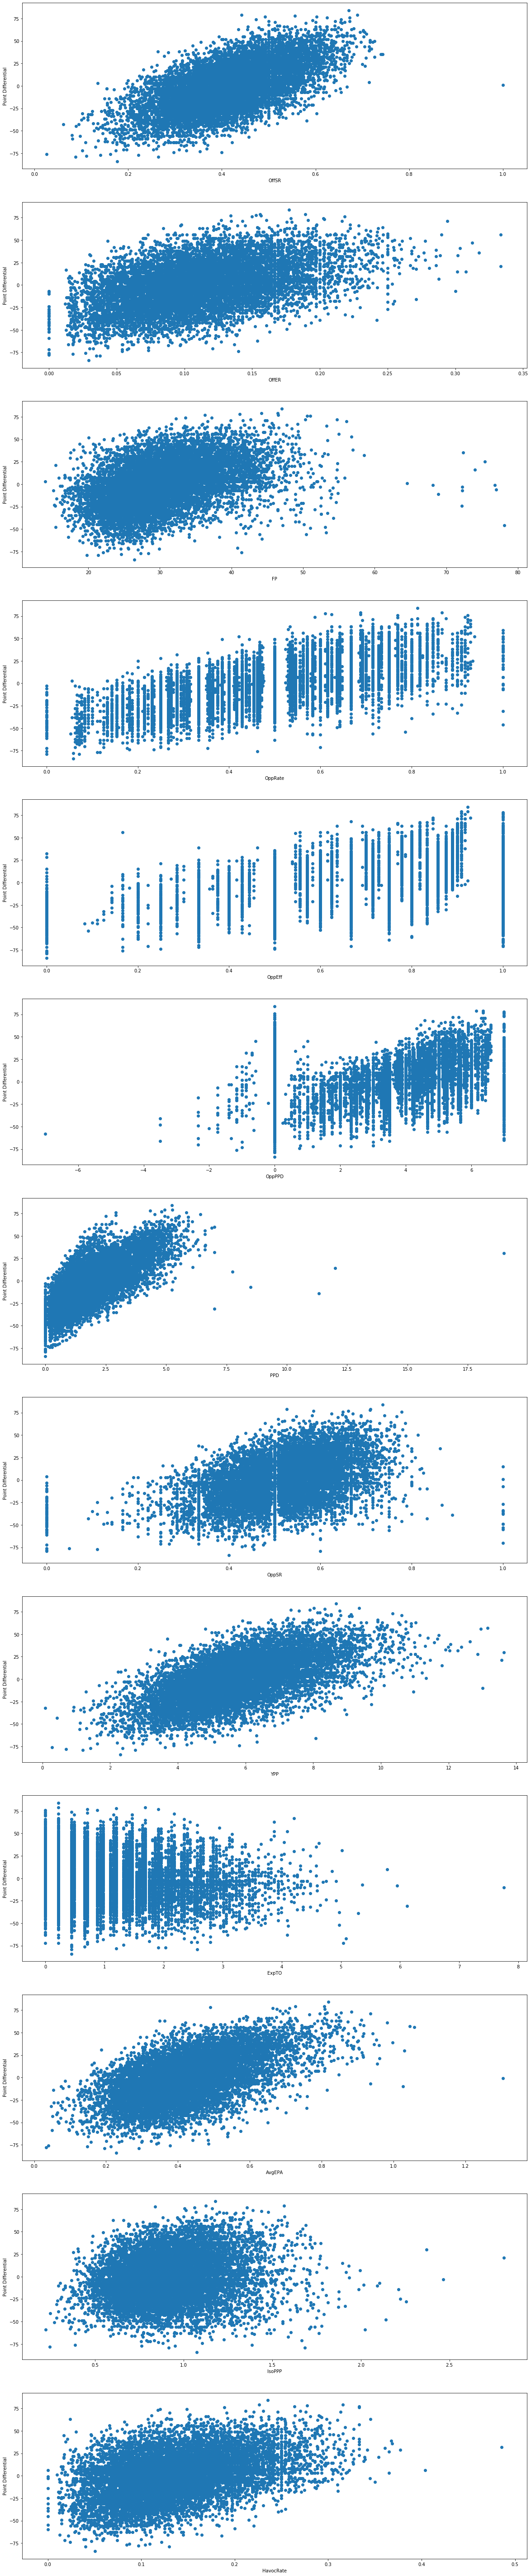

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[inpt], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [17]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0.122680,0.04152,0.006633,5.231521,0.963043,0.902538,1.720674
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,-0.122680,-0.04152,-0.006633,4.268479,-0.963043,0.902538,1.720674
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0.017305,-0.42232,0.042920,4.702730,-0.094540,0.088600,0.163874
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,-0.017305,0.42232,-0.042920,4.797270,0.094540,0.088600,0.163874
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0.087917,0.26167,0.059391,4.333794,-0.832411,0.780114,0.450653


In [18]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [19]:
# outliers

In [20]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0.122680,0.04152,0.006633,5.231521,0.963043,0.902538,1.720674
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0.017305,-0.42232,0.042920,4.702730,-0.094540,0.088600,0.163874
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,-0.017305,0.42232,-0.042920,4.797270,0.094540,0.088600,0.163874
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0.087917,0.26167,0.059391,4.333794,-0.832411,0.780114,0.450653
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,-0.084175,0.172264,0.00,-0.087917,-0.26167,-0.059391,5.166206,0.832411,0.780114,0.450653


In [21]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 21.17434x + 0.03693
Mean Pred Score: -0.1645826167878758
Pred Std Dev: 22.266298407705513
MAPE: 273.3733866626349%
Mean Abs Error: 7.227828731744679
Mdn Abs Error: 5.671515608679966
R-squared: 0.8496168796786849



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.811214,0.626620,0.537764,0.833429,0.613626,0.602440,0.966120,0.581904,0.805122,-0.475969,0.752717,0.226120,0.607751,0.922142,0.922142,0.922142
OffSRDiff,0.811214,1.000000,0.559883,0.377861,0.748129,0.450880,0.463326,0.789708,0.776405,0.764356,-0.351821,0.696829,-0.023177,0.610753,0.875459,0.875459,0.875459
OffERDiff,0.626620,0.559883,1.000000,0.209586,0.566046,0.353741,0.365557,0.607849,0.425796,0.827391,-0.218529,0.781609,0.551606,0.266912,0.610137,0.610137,0.610137
FPDiff,0.537764,0.377861,0.209586,1.000000,0.642738,0.147144,0.149248,0.508393,0.140231,0.307806,-0.297038,0.298817,0.009218,0.342822,0.641330,0.641330,0.641330
OppRateDiff,0.833429,0.748129,0.566046,0.642738,1.000000,0.288336,0.276498,0.817754,0.376049,0.721354,-0.358201,0.652485,0.151133,0.572317,0.906120,0.906120,0.906120
OppEffDiff,0.613626,0.450880,0.353741,0.147144,0.288336,1.000000,0.736400,0.600029,0.536447,0.468431,-0.292364,0.437645,0.165780,0.357352,0.523276,0.523276,0.523276
OppPPDDiff,0.602440,0.463326,0.365557,0.149248,0.276498,0.736400,1.000000,0.586003,0.562189,0.491938,-0.318387,0.468740,0.189956,0.394463,0.595795,0.595795,0.595795
PPDDiff,0.966120,0.789708,0.607849,0.508393,0.817754,0.600029,0.586003,1.000000,0.571026,0.781332,-0.448571,0.728625,0.214183,0.595249,0.898916,0.898916,0.898916
OppSRDiff,0.581904,0.776405,0.425796,0.140231,0.376049,0.536447,0.562189,0.571026,1.000000,0.583894,-0.276571,0.541798,-0.004608,0.436323,0.632904,0.632904,0.632904
YPPDiff,0.805122,0.764356,0.827391,0.307806,0.721354,0.468431,0.491938,0.781332,0.583894,1.000000,-0.336111,0.922589,0.507346,0.510041,0.800006,0.800006,0.800006


In [85]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [86]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -1.0 (exact value: -0.9108385277925253)
Z score: -0.03351504131222812
Win Prob for Virginia Tech: 48.66%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,1.791667,-0.052381,0.118588,0.994779,-0.66,0.103211,0.124959,-0.040309,4.77238,0.04476
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.103211,-0.124959,0.040309,4.72762,-0.04476


In [87]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -16.40551600593977)
Z score: -0.7293952991994184
Win Prob for Georgia Tech: 23.29%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,1.166667,1.361111,0.07619,-0.330005,-0.66,-0.014422,-0.121075,0.018689,4.361737,-0.776527
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-1.166667,-1.361111,-0.07619,0.330005,0.66,0.014422,0.121075,-0.018689,5.138263,0.776527


In [88]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by 2.0 (exact value: 2.3727461450746845)
Z score: 0.11395377513599153
Win Prob for Georgia Tech: 54.54%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,0.5,0.054545,-0.01919,-1.322588,0.0,-0.06305,-0.300725,0.012719,4.694843,-0.110314
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,-0.5,-0.054545,0.01919,1.322588,0.0,0.06305,0.300725,-0.012719,4.805157,0.110314


In [89]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 1.0 (exact value: 0.9797715632002917)
Z score: 0.05139400177948529
Win Prob for Mississippi State: 52.05%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-1.05,0.068182,-0.059649,0.080622,0.22,0.020976,0.092249,0.000243,4.727736,-0.044528
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,1.05,-0.068182,0.059649,-0.080622,-0.22,-0.020976,-0.092249,-0.000243,4.772264,0.044528


In [90]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3.0 (exact value: -2.840368313969765)
Z score: -0.12017200381433416
Win Prob for Texas A&M: 45.22%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.166667,0.340557,0.014666,0.876496,0.0,-0.103285,-0.349878,0.001282,4.817943,0.135886
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.166667,-0.340557,-0.014666,-0.876496,0.0,0.103285,0.349878,-0.001282,4.682057,-0.135886


In [91]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.930991,13,12.0,1.0
2,Alabama,0.926717,12,11.0,1.0
3,Clemson,0.926434,13,12.0,1.0
4,LSU,0.892583,13,12.0,1.0
5,Utah,0.875267,13,11.0,2.0
...,...,...,...,...,...
126,Bowling Green,0.220278,12,3.0,9.0
127,Connecticut,0.189404,12,2.0,10.0
128,UMass,0.111439,12,1.0,11.0
129,Akron,0.109993,12,1.0,11.0


In [92]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.594371,1.405629
21,Clemson,11.523000,1.477000
53,LSU,11.011291,1.988709
2,Alabama,10.294232,1.705768
115,Utah,10.213372,2.786628
...,...,...,...
117,UTEP,3.159821,8.840179
25,Connecticut,2.962945,9.037055
88,Rutgers,2.508271,9.491729
112,UMass,2.025950,9.974050


In [93]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].median()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].median()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.14825606420456128, -23.409311348660722]

In [94]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Georgia,Baylor,7.5,9.368643,0.665728,True,Georgia,Georgia
0,Florida,Virginia,14.0,3.064274,0.557649,False,Florida,Virginia
0,LSU,Oklahoma,11.0,2.328667,0.544578,False,LSU,Oklahoma
0,Penn State,Memphis,7.0,0.763481,0.516623,False,Penn State,Memphis
0,Clemson,Ohio State,2.5,-0.761858,0.489300,False,Ohio State,Ohio State
0,Wisconsin,Oregon,2.5,-2.231640,0.463018,False,Oregon,Oregon


In [95]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by -1.0 (exact value: -0.7024079264096517)
Z score: -0.024154230747022377
Win Prob for Virginia: 49.04%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.571429,-1.0,0.073684,-2.332187,0.66,-0.135068,-0.403644,-0.089435,4.767458,0.034917
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.571429,1.0,-0.073684,2.332187,-0.66,0.135068,0.403644,0.089435,4.732542,-0.034917


In [96]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 11.100924658271158)
Z score: 0.5059443230654123
Win Prob for North Carolina: 69.36%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,0.178571,1.230769,-0.123887,-0.349659,0.0,-0.01403,-0.235394,0.079888,5.01126,0.522519
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,-0.178571,-1.230769,0.123887,0.349659,0.0,0.01403,0.235394,-0.079888,4.48874,-0.522519


In [97]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 17.0 (exact value: 17.302534619234372)
Z score: 0.7844643467985477
Win Prob for Pittsburgh: 78.36%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.833333,0.659341,0.20743,1.49512,0.0,0.130501,-0.248736,0.038746,5.157701,0.815402
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.833333,-0.659341,-0.20743,-1.49512,0.0,-0.130501,0.248736,-0.038746,4.342299,-0.815402


In [98]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.506396170225608)
Z score: -0.41954946360571943
Win Prob for Auburn: 33.74%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.063492,-0.538462,0.114729,1.117419,0.44,0.063274,-0.083465,-0.033763,4.975351,0.450702
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.063492,0.538462,-0.114729,-1.117419,-0.44,-0.063274,0.083465,0.033763,4.524649,-0.450702


In [99]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 40.0 (exact value: 40.303702545189616)
Z score: 1.8174680147093047
Win Prob for Georgia: 96.54%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,2.666667,3.276786,-0.047059,4.45067,0.0,0.330151,0.455922,0.020115,5.700839,1.901678
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-2.666667,-3.276786,0.047059,-4.45067,0.0,-0.330151,-0.455922,-0.020115,3.799161,-1.901678


In [100]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 26.0 (exact value: 26.078122750334035)
Z score: 1.1785841043987948
Win Prob for Clemson: 88.07%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 7.0 (exact value: 7.467832185596912)
Z score: 0.34277878894066655
Win Prob for Georgia Tech: 63.41%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -9.0 (exact value: -9.432126576244341)
Z score: -0.4162139476334928
Win Prob for The Citadel: 33.86%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 22.0 (exact value: 22.000273093551932)
Z score: 0.9954441148902146
Win Prob for Temple: 84.02%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 11.100924658271158)
Z score: 0.5059443230654

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5805,401111653,2019,Georgia Tech,Clemson,-38.0,11.928191
5900,401112441,2019,Georgia Tech,South Florida,4.0,63.411756
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,66.137327
6106,401112469,2019,Georgia Tech,Temple,-22.0,15.976016
6165,401112475,2019,Georgia Tech,North Carolina,-16.0,30.644787
6198,401112480,2019,Georgia Tech,Duke,-18.0,27.231299
6251,401112488,2019,Georgia Tech,Miami,7.0,23.287995
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,21.638385
6418,401112504,2019,Georgia Tech,Virginia,-5.0,24.569737
6480,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.212634


In [101]:
retrieve_win_probs("Ohio State", 2019)

Game: Florida Atlantic @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 24.0
Proj MOV: Ohio State by 25.0 (exact value: 24.530738361082353)
Z score: 1.109089644164839
Win Prob for Ohio State: 86.63%
---
Game: Cincinnati @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 42.0
Proj MOV: Ohio State by 44.0 (exact value: 44.09014407920204)
Z score: 1.9875205966284477
Win Prob for Ohio State: 97.66%
---
Game: Ohio State @ Indiana
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 40.0 (exact value: 40.1240463205972)
Z score: 1.8093994879473423
Win Prob for Ohio State: 96.48%
---
Game: Miami (OH) @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 71.0
Proj MOV: Ohio State by 67.0 (exact value: 67.35874317261253)
Z score: 3.0325348449490455
Win Prob for Ohio State: 99.88%
---
Game: Ohio State @ Nebraska
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 41.0 (exact value: 40.918367124765844)
Z score: 1.8450731679467873
Win P

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5827,401112251,2019,Ohio State,Florida Atlantic,24.0,86.630424
5888,401112252,2019,Ohio State,Cincinnati,42.0,97.656763
5958,401112159,2019,Ohio State,Indiana,41.0,96.480552
6042,401112253,2019,Ohio State,Miami (OH),71.0,99.878745
6127,401112241,2019,Ohio State,Nebraska,41.0,96.748655
6174,401112216,2019,Ohio State,Michigan State,24.0,82.553776
6241,401112248,2019,Ohio State,Northwestern,49.0,97.402018
6307,401112254,2019,Ohio State,Wisconsin,31.0,86.966957
6410,401112209,2019,Ohio State,Maryland,59.0,97.640216
6475,401112255,2019,Ohio State,Rutgers,35.0,93.030131


In [102]:
retrieve_win_probs("Georgia Tech", 2018)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 53.0 (exact value: 53.17964560373309)
Z score: 2.395738494282488
Win Prob for Georgia Tech: 99.17%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 9.0 (exact value: 9.460186078105398)
Z score: 0.4322572400072798
Win Prob for South Florida: 66.72%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 5.0 (exact value: 5.336336897467341)
Z score: 0.24705136945221032
Win Prob for Pittsburgh: 59.76%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 30.0 (exact value: 29.624739226732583)
Z score: 1.3378659217650435
Win Prob for Clemson: 90.95%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.33463362377324)
Z score

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
4986,401013090,2018,Georgia Tech,Alcorn State,41.0,99.170654
5039,401013100,2018,Georgia Tech,South Florida,-11.0,33.277723
5135,401013112,2018,Georgia Tech,Pittsburgh,-5.0,40.243423
5206,401013120,2018,Georgia Tech,Clemson,-28.0,9.047007
5249,401013134,2018,Georgia Tech,Bowling Green,46.0,95.809861
5304,401013138,2018,Georgia Tech,Louisville,35.0,95.907942
5373,401013145,2018,Georgia Tech,Duke,-14.0,19.644876
5473,401013153,2018,Georgia Tech,Virginia Tech,21.0,76.449985
5545,401013165,2018,Georgia Tech,North Carolina,10.0,79.513528
5636,401013172,2018,Georgia Tech,Miami,6.0,53.823780


In [103]:
retrieve_win_probs("Clemson", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 26.0 (exact value: 26.078122750334035)
Z score: 1.1785841043987948
Win Prob for Clemson: 88.07%
---
Game: Texas A&M @ Clemson
Actual Winner: Clemson
MOV: Clemson by 14.0
Proj MOV: Clemson by 11.0 (exact value: 10.82447340151921)
Z score: 0.49352864212509584
Win Prob for Clemson: 68.92%
---
Game: Clemson @ Syracuse
Actual Winner: Clemson
MOV: Clemson by 35.0
Proj MOV: Clemson by 31.0 (exact value: 30.526503605797835)
Z score: 1.3783649918194172
Win Prob for Clemson: 91.60%
---
Game: Charlotte @ Clemson
Actual Winner: Clemson
MOV: Clemson by 42.0
Proj MOV: Clemson by 49.0 (exact value: 48.91689436487931)
Z score: 2.204294404169216
Win Prob for Clemson: 98.62%
---
Game: Clemson @ North Carolina
Actual Winner: Clemson
MOV: Clemson by 1.0
Proj MOV: Clemson by -0.0 (exact value: -0.1349051056292694)
Z score: 0.0013328444007709942
Win Prob for Clemson: 50.05%
---
Game: Florida State @ Clemson
Actual 

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5805,401111653,2019,Clemson,Georgia Tech,38.0,88.071809
5910,401110784,2019,Clemson,Texas A&M,14.0,68.918045
6011,401112449,2019,Clemson,Syracuse,35.0,91.595469
6068,401112456,2019,Clemson,Charlotte,42.0,98.624818
6101,401112467,2019,Clemson,North Carolina,1.0,50.053173
6207,401112479,2019,Clemson,Florida State,31.0,85.486288
6253,401112485,2019,Clemson,Louisville,35.0,91.583399
6345,401112490,2019,Clemson,Boston College,52.0,92.018107
6381,401112496,2019,Clemson,Wofford,45.0,97.715567
6445,401112503,2019,Clemson,NC State,45.0,96.195608


In [104]:
retrieve_win_probs("Georgia Tech", 2016)

Game: Georgia Tech @ Boston College
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -5.0 (exact value: -5.221851234961884)
Z score: -0.22712659848409653
Win Prob for Georgia Tech: 41.02%
---
Game: Mercer @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 25.0
Proj MOV: Georgia Tech by 31.0 (exact value: 31.101798730209044)
Z score: 1.4042020265109185
Win Prob for Georgia Tech: 91.99%
---
Game: Vanderbilt @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 31.0
Proj MOV: Georgia Tech by 31.0 (exact value: 30.952419351134363)
Z score: 1.3974932608086235
Win Prob for Georgia Tech: 91.89%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 19.0
Proj MOV: Clemson by 20.0 (exact value: 20.264820966467113)
Z score: 0.9175033590758469
Win Prob for Clemson: 82.06%
---
Game: Miami @ Georgia Tech
Actual Winner: Miami
MOV: Miami by 14.0
Proj MOV: Miami by 6.0 (exact value: 6.3814866041720135)
Z score: 0.29399000682998777
W

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
3312,400869424,2016,Georgia Tech,Boston College,3.0,41.016265
3393,400869433,2016,Georgia Tech,Mercer,25.0,91.987065
3462,400869001,2016,Georgia Tech,Vanderbilt,31.0,91.886735
3513,400869446,2016,Georgia Tech,Clemson,-19.0,17.943947
3577,400869721,2016,Georgia Tech,Miami,-14.0,38.438277
3650,400869458,2016,Georgia Tech,Pittsburgh,-3.0,42.938814
3702,400869464,2016,Georgia Tech,Georgia Southern,11.0,73.593276
3817,400869474,2016,Georgia Tech,Duke,3.0,35.551779
3873,400869480,2016,Georgia Tech,North Carolina,-28.0,23.942339
3944,400869486,2016,Georgia Tech,Virginia Tech,10.0,46.255602


In [105]:
retrieve_win_probs("Alabama", 2012)

Game: Michigan @ Alabama
Actual Winner: Alabama
MOV: Alabama by 27.0
Proj MOV: Alabama by 37.0 (exact value: 37.31067946549816)
Z score: 1.6830485874256174
Win Prob for Alabama: 95.38%
---
Game: Western Kentucky @ Alabama
Actual Winner: Alabama
MOV: Alabama by 35.0
Proj MOV: Alabama by 28.0 (exact value: 28.409909356471374)
Z score: 1.2833067917283778
Win Prob for Alabama: 90.03%
---
Game: Alabama @ Arkansas
Actual Winner: Alabama
MOV: Alabama by 52.0
Proj MOV: Alabama by 32.0 (exact value: 32.13240652169661)
Z score: 1.4504875730627833
Win Prob for Alabama: 92.65%
---
Game: Florida Atlantic @ Alabama
Actual Winner: Alabama
MOV: Alabama by 33.0
Proj MOV: Alabama by 48.0 (exact value: 48.40617540601462)
Z score: 2.181357544637685
Win Prob for Alabama: 98.54%
---
Game: Ole Miss @ Alabama
Actual Winner: Alabama
MOV: Alabama by 19.0
Proj MOV: Alabama by 20.0 (exact value: 19.500914028981757)
Z score: 0.883195593883003
Win Prob for Alabama: 81.14%
---
Game: Alabama @ Missouri
Actual Winner:

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
67,322450333,2012,Alabama,Michigan,27.0,95.381716
101,322520333,2012,Alabama,Western Kentucky,35.0,90.030769
167,322590008,2012,Alabama,Arkansas,52.0,92.653870
247,322660333,2012,Alabama,Florida Atlantic,33.0,98.542151
326,322730333,2012,Alabama,Ole Miss,19.0,81.143470
417,322870142,2012,Alabama,Missouri,32.0,82.319594
477,322942633,2012,Alabama,Tennessee,31.0,79.032902
551,323010333,2012,Alabama,Mississippi State,31.0,86.197092
606,323080099,2012,Alabama,LSU,4.0,57.255467
637,323150333,2012,Alabama,Texas A&M,-5.0,51.052045


In [106]:
predict_matchup("Georgia Tech","Georgia", 2015)
# calculate_box_score(400547779, 2014)

[0.32710591891466, -10.138075108374869]

In [107]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 55.0 (exact value: 54.881186070047484)
Z score: 2.4721562461314237
Win Prob for Georgia Tech: 99.33%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 49.0 (exact value: 49.03302189403866)
Z score: 2.2095097986201933
Win Prob for Georgia Tech: 98.64%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 12.0 (exact value: 12.089806084617335)
Z score: 0.550355900070235
Win Prob for Notre Dame: 70.90%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 17.0 (exact value: 16.799642656692413)
Z score: 0.7618790048915189
Win Prob for Duke: 77.69%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 8.0 (exact value: 8.367894724781655)
Z score: 0.38320142779622

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2461,400756895,2015,Georgia Tech,Alcorn State,63.0,99.328496
2570,400756910,2015,Georgia Tech,Tulane,55.0,98.643040
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,29.103764
2692,400756933,2015,Georgia Tech,Duke,-14.0,22.306611
2767,400756942,2015,Georgia Tech,North Carolina,-7.0,35.078521
2830,400756948,2015,Georgia Tech,Clemson,-19.0,16.840051
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,26.794424
2965,400756962,2015,Georgia Tech,Florida State,6.0,26.115169
2997,400756972,2015,Georgia Tech,Virginia,-6.0,26.123597
3091,400756979,2015,Georgia Tech,Virginia Tech,-2.0,30.424702


In [108]:
predict_matchup("Georgia Tech","Florida State",2015)

[0.2420194826563849, -15.747010577767622]

In [109]:
predict_matchup("Army","Navy", 2019)

[0.41882987770744173, -4.726676417851377]

In [110]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 55.0 (exact value: 54.881186070047484)
Z score: 2.4721562461314237
Win Prob for Georgia Tech: 99.33%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 49.0 (exact value: 49.03302189403866)
Z score: 2.2095097986201933
Win Prob for Georgia Tech: 98.64%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 12.0 (exact value: 12.089806084617335)
Z score: 0.550355900070235
Win Prob for Notre Dame: 70.90%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 17.0 (exact value: 16.799642656692413)
Z score: 0.7618790048915189
Win Prob for Duke: 77.69%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 8.0 (exact value: 8.367894724781655)
Z score: 0.38320142779622

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2461,400756895,2015,Georgia Tech,Alcorn State,63.0,99.328496
2570,400756910,2015,Georgia Tech,Tulane,55.0,98.643040
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,29.103764
2692,400756933,2015,Georgia Tech,Duke,-14.0,22.306611
2767,400756942,2015,Georgia Tech,North Carolina,-7.0,35.078521
2830,400756948,2015,Georgia Tech,Clemson,-19.0,16.840051
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,26.794424
2965,400756962,2015,Georgia Tech,Florida State,6.0,26.115169
2997,400756972,2015,Georgia Tech,Virginia,-6.0,26.123597
3091,400756979,2015,Georgia Tech,Virginia Tech,-2.0,30.424702


In [111]:
retrieve_win_probs("Georgia Tech", 2013)

Game: Elon @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 70.0
Proj MOV: Georgia Tech by 35.0 (exact value: 35.11412698870264)
Z score: 1.5843993895851993
Win Prob for Georgia Tech: 94.34%
---
Game: Georgia Tech @ Duke
Actual Winner: Georgia Tech
MOV: Georgia Tech by 24.0
Proj MOV: Georgia Tech by 23.0 (exact value: 22.728731578771438)
Z score: 1.0281598573940254
Win Prob for Georgia Tech: 84.81%
---
Game: North Carolina @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 8.0
Proj MOV: Georgia Tech by -0.0 (exact value: -0.41297672489965287)
Z score: -0.011155608514876339
Win Prob for Georgia Tech: 49.55%
---
Game: Virginia Tech @ Georgia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 7.0
Proj MOV: Virginia Tech by 6.0 (exact value: 5.948746050854835)
Z score: 0.2745552294191441
Win Prob for Virginia Tech: 60.82%
---
Game: Georgia Tech @ Miami
Actual Winner: Miami
MOV: Miami by 15.0
Proj MOV: Miami by 11.0 (exact value: 11.097677984384937)
Z score:

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
831,332430059,2013,Georgia Tech,Elon,70.0,94.344857
980,332570150,2013,Georgia Tech,Duke,24.0,84.806268
1019,332640059,2013,Georgia Tech,North Carolina,8.0,49.554965
1077,332690059,2013,Georgia Tech,Virginia Tech,-7.0,39.182898
1150,332782390,2013,Georgia Tech,Miami,-15.0,30.649905
1219,332850252,2013,Georgia Tech,BYU,-18.0,33.968910
1246,332920059,2013,Georgia Tech,Syracuse,56.0,96.757048
1294,332990258,2013,Georgia Tech,Virginia,10.0,55.059791
1376,333060059,2013,Georgia Tech,Pittsburgh,11.0,69.850746
1445,333180228,2013,Georgia Tech,Clemson,-24.0,8.884720


In [112]:
predict_matchup("Georgia Tech","Syracuse",2013)

[0.5420829451938354, 2.1885798410829604]

In [114]:
generate_win_prob(401013177,2018)

Game: Virginia @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -5.0 (exact value: -5.251150002302768)
Z score: -0.228442433150659
Win Prob for Georgia Tech: 40.97%
---


0.4096511522669328